In [644]:
#Astropy
import astropy
from astropy.io import fits
from astropy.table import Table
from astropy import units as u

# Dlnpyutils and ages
from dlnpyutils.utils import bspline,mad,interp
import dlnpyutils.robust as robust
import ages as ages

# dust_extinction
from dust_extinction.parameter_averages import CCM89,O94,F99,VCG04,GCC09,M14,F19,D22

# functools
from functools import partial

# Matplotlib
import matplotlib
import matplotlib.pyplot as plt
# %matplotlib inline
matplotlib.rcParams.update({'font.size': 25,'axes.facecolor':'w'})
from matplotlib import rc
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

#Numpy/Scipy
import numpy as np
import scipy
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit

# pdb
import pdb

# tqdm 
from tqdm.notebook import tqdm

In [569]:
def closest(data,value):
    '''
    Find nearest value in array to given value

    Inputs:
    ------
        data:  array-like
               data to search through

        value: float or int
               value of interest

    Output:
    ------
        close: float or int
               value in data closest to given value
    '''

    data = np.asarray(data)

    return data[(np.abs(np.subtract(data,value))).argmin()]

def sfdebv_2_ext(ebv,wave):
    '''
    Convert Schlegel Reddening to extinction using Schlafly et al. 2010 and Fitzpatrick 1999
    
    Inputs:
    ------
        ebv:  float
              Schlegel E(B-V) value
              
        wave: float
              wavelength of band to calculate extinction in mircons
        
    Output:
    ------
        ext:  float
              extinction in the band with the effective wavelength of wave
    '''
    
    micron_ext = (0.78/1.32)*ebv # Schlafly et al. 2010
    ext = f99(wave)/f99(1)*micron_ext # Fitzpatrick 1999
    return ext

import astropy.units as u
def convert_sfdebv(wave,ebv,rv=3.1):
    '''
    Convert Schlegel Reddening to extinction using Schlafly et al. 2010
    
    Inputs:
    ------
        wave: wavelength of band to calculate extinction in mircons
        ebv: Schlegel E(B-V) value
        
    Output:
    ------
        new_extinction: extinction in the band with the effective wavelength of wave
    '''
    
    micron_extinction = (0.78/1.32)*ebv
    fitz = F99(Rv=rv)
    return fitz(1/(wave*u.micron))/fitz(1*u.micron)*micron_extinction

import astropy.units as u
from dust_extinction.parameter_averages import CCM89,O94,F99,VCG04,GCC09,M14,F19,D22

def extcoeff(wavelength,rv=3.1,law='CCM89',ref='G'):

    '''
    Calculate the relative extincion law coefficients for a given wavelength relative to the 
    BP, G, RP, J, H, K or user defined band

    Input:
    -----
        wavelength: float
                    Effective wavelength of band of interest in microns
        
        law:        str
                    extinction law to use
                         
                    Available Extinction Laws: 
                    -------------------------
                        
                    CCM89 - Cardelli, Clayton, & Mathis 1989
                    O94 - O'Donnell 1994
                    F99 - Fitzpatrick 1999
                    F04 - Fitzpatrick 2004
                    VCG04 - Valencic, Clayton, & Gordon 2004
                    GCC09 - Grodon, Cartledge, & Clayton 2009
                    M14 - Maiz Apellaniz et al 2014
                    F19 - Fitzpatrick, Massa, Gordon, Bohlin & Clayton 2019
                    D22 - Decleir et al. 2022

        rv:         float
                    Rv (=Av/E(B-V)) extinction law slope. Default is 3.1
        
        ref:        str or float
                    reference filter. Can be 'BP', 'G', 'RP', 'J', 'H', 'K' 
                    or user defined float that is the wavelength in microns of the band

    Output:
    ------
        ext_coeff:  float
                    calculated extinction coefficients for the BP, G, RP, J, H, and K bands 
                    relative to the Gaia G band

    '''

    leff = {'BP':0.5387,'G':0.6419,'RP':0.7667,'J':1.2345,'H':1.6393,'K':2.1757}
    
    # select the extinction model
    if law == 'CCM89':
        ext_model = CCM89(Rv=rv)

    elif law == 'O94':
        ext_model = O94(Rv=rv)

    elif law == 'F99':
        ext_model = F99(Rv=rv)

    elif law == 'F04':
        ext_model = F04(Rv=rv)

    elif law == 'VCG04':
        ext_model = VCG04(Rv=rv)

    elif law == 'GCC09':
        ext_model = GCC09(Rv=rv)

    elif law == 'M14':
        ext_model = M14(Rv=rv)

    elif law == 'F19':
        ext_model = F19(Rv=rv)

    elif law == 'D22':
        ext_model = D22(Rv=rv)   

    # Calculate the relative extinction coefficient
    if type(ref) == str:
        ext_coeff = ext_model(wavelength*u.micron)/ext_model(leff[ref]*u.micron)
    
    elif type(ref) == float:
        ext_coeff = ext_model(wavelength*u.micron)/ext_model(ref*u.micron)
    
    return ext_coeff

### Geometry

import MagellanicStream as MagellanicStream

def LMCdisk_cart(ra, dec):
    
    '''
    Calculate the position of stars in the LMC disk plane with 
    center at the LMC center in cartesian coordinates (x, y).
    This also calculates the distance to the individual stars.
    
    This follows van der Marel and Cioni 2001 with parameters from Choi et al. 2018 (SMASHing the LMC: 
    Mapping a Ring-like Stellar Overdensity in the LMC Disk)
    
    Input
    - ra: right ascension of stars
    - dec: declination of stars
    
    Output
    - x_m: x coordinate
    - y_m: y coordinate
    - dis: distance to LMC star
    '''
    alph0 = np.radians(82.25) #right ascension of center of LMC
    delt0 = np.radians(-69.50) #declination of center of LMC
    pa = np.radians(149.23+90.00) #146.37 #position angle of line of nodes
    io = np.radians(25.86) #27.81 #inclination of LMC disk
    d0 = 49.90 #distance to center of LMC
    
    #convert to radians
    ra = np.radians(ra)
    dec = np.radians(dec)
    sd = np.sin(delt0)
    cd = np.cos(delt0)
    
    cr = cd*np.cos(dec)*np.cos(ra-alph0)+sd*np.sin(dec)
    srcp = -np.cos(dec)*np.sin(ra-alph0)
    srsp = cd*np.sin(dec) - sd*np.cos(dec)*np.cos(ra-alph0)
    dis = d0*np.cos(io)/(np.cos(io)*cr - np.sin(io)*np.cos(pa)*srsp + np.sin(io)*np.sin(pa)*srcp)
    
    x_m = dis*srcp
    y_m = dis*(np.cos(io)*srsp + np.sin(io)*cr) - d0*np.sin(io)
    
    return x_m, y_m, dis

def elliptical_radius(x,y):
    '''
    Calculate elliptical radius from cartesian(x,y) using equation 6 form Choi et al. 2018 (SMASHing the LMC: 
    Mapping a Ring-like Stellar Overdensity in the LMC Disk)
    
    Parameters:
    ----------
        x: x cartesian coordinate
        y: y cartesian coordinate
        psi: semimajor axis position angle
    Returns:
    -------
        ell_r: elliptical radius
    '''
    
    
    b_a = 0.836 # disk axis ratio
    psi = 227.24 + 90 # position angle of semi major axis
    cpsi = np.cos(np.radians(psi)) 
    spsi = np.cos(np.radians(psi))
    
    ell_r = np.sqrt(np.square(x*cpsi-y*spsi) + np.square(b_a*(x*spsi + y*cpsi)))
    
    return ell_r

def superellipse_radius(x,y):
    b_a = 0.836 # disk axis ratio
    psi = 227.24 + 90 # position angle of semi major axis
    c0 = 2.999 # bar shape parameter
    cpsi = np.cos(np.radians(psi)) 
    spsi = np.cos(np.radians(psi))
    
    sell_r = (np.abs(x*cpsi-y*spsi)**c0 + np.abs(b_a*(x*spsi + y*cpsi))**c0)**(1/c0)
    
    return sell_r

# Gaia

In [570]:
# import
# mcs = fits.getdata('/Users/joshuapovick/Desktop/Research/gaiadr3mcmaps_fits/mcs_rgb_lessstrict_gaiadr3_specpars.fits.gz')
# mcs = mcs[(mcs['parallax']<0.2)&(np.sqrt((80.8926-mcs['ra'])**2+(-72.1859-mcs['dec'])**2)<=30.)]

mcs = fits.getdata('/Users/joshuapovick/Desktop/Research/LMC_Ages/Age_Fitting/notebooks/lmc_josh.fits.gz')
mcs = mcs[(np.isfinite(mcs['ra'])==True)&(np.isfinite(mcs['dec'])==True)]

# # Teff and Log(g) cut
# mcs = mcs[np.where((mcs['best_teff']<5300)&(mcs['best_logg']<3.7))]

# parallax_cut = np.where(mcs['parallax']/mcs['parallax_error']<5.)

# ###
# plt.figure(figsize=[12,10])

# plt.scatter(mcs['mlon'][parallax_cut],mcs['mlat'][parallax_cut],c=mcs['best_feh'][parallax_cut],cmap='nipy_spectral',s=10)

# plt.colorbar()

# plt.gca().invert_xaxis()

# plt.title(r'Color as [Fe/H]')
# plt.xlabel(r'L${\rm _{MS}}$')
# plt.ylabel(r'B${\rm _{MS}}$')
# plt.show()

In [571]:
#30$^\circ$ of the origin of the Magellanic Stream ($\alpha=80.8926^\circ$, $\delta=-72.1859^\circ$)
# u

# APOGEE LMC 

In [572]:
lmcdr17 = fits.getdata('/Users/joshuapovick/Desktop/Research/fits/lmc_rgbmembers.dr17rev1_qacuts.fits.gz')

apoafe = lmcdr17['ALPHA_M']+lmcdr17['M_H']-lmcdr17['FE_H']
apoafe_err = np.sqrt(lmcdr17['ALPHA_M_ERR']**2+lmcdr17['M_H_ERR']**2+lmcdr17['FE_H']**2)

salfeh = lmcdr17['FE_H']+np.log10(0.659*(10**(apoafe))+0.341)
salfeh_err = np.sqrt(lmcdr17['FE_H_ERR']**2+((1-0.341/(0.659*(10**(apoafe))+0.341))*apoafe_err)**2)

diane = fits.getdata('/Users/joshuapovick/Desktop/Research/fits/output_LMC_DR16_all.fits.gz')

_, diane_idx, me_idx = np.intersect1d(diane['APOGEE_ID'],lmcdr17['APOGEE_ID'], return_indices=True)

In [573]:
smcdr17 = fits.getdata('/Users/joshuapovick/Desktop/Research/fits/smc_rgbmembers.dr17rev1_qacuts.fits.gz')
print(len(smcdr17))
del smcdr17

2062


In [574]:
len(np.unique(lmcdr17['FIELD']))

36

In [575]:
len(lmcdr17)

6130

In [576]:
### Position/Distances of the LMC stars

from dlnpyutils import coords
import astropy.units as u
from astropy.coordinates import SkyCoord

lmcx, lmcy, lmcdis = LMCdisk_cart(lmcdr17['RA'], lmcdr17['DEC'])
lmcr = elliptical_radius(lmcx,lmcy)
lmcsr = superellipse_radius(lmcx,lmcy)

### lmcdr17
gc = SkyCoord(ra=lmcdr17['RA']*u.degree, dec=lmcdr17['DEC']*u.degree, frame='icrs')
lms_lmc,bms_lmc = coords.gal2mag(gc.galactic.l.value,gc.galactic.b.value)

for i in range(len(lms_lmc)):
    if lms_lmc[i] > 180.:
        lms_lmc[i] = lms_lmc[i]-360
        
gaiax, gaiay, gaiadis = LMCdisk_cart(mcs['ra'], mcs['dec'])

# gaiax = gaiax[np.where((np.isfinite(gaiax)==True)&(np.isfinite(gaiay==True))&(np.isfinite(gaiadis==True)))]
# gaiay = gaiay[np.where((np.isfinite(gaiax)==True)&(np.isfinite(gaiay==True))&(np.isfinite(gaiadis==True)))]
# gaiadis = gaiadis[np.where((np.isfinite(gaiax)==True)&(np.isfinite(gaiay==True))&(np.isfinite(gaiadis==True)))]

gaiar = elliptical_radius(gaiax,gaiay)
gaiasr = superellipse_radius(gaiax,gaiay)


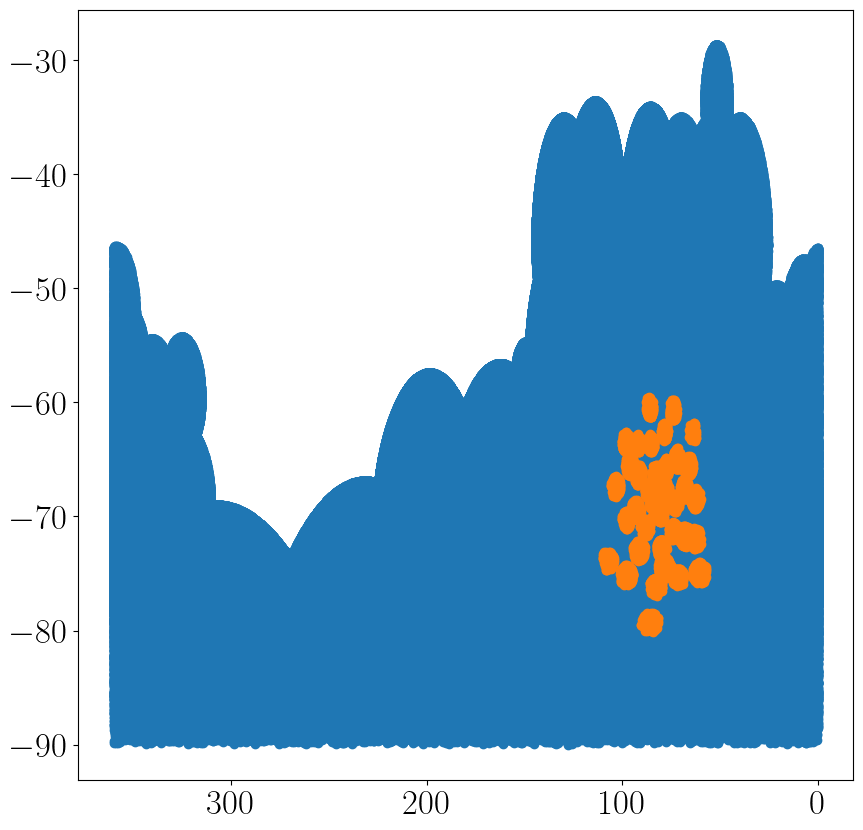

In [577]:
plt.figure(figsize=[10,10])
plt.scatter(mcs['ra'],mcs['dec'])
plt.scatter(lmcdr17['RA'],lmcdr17['DEC'])
plt.gca().invert_xaxis()

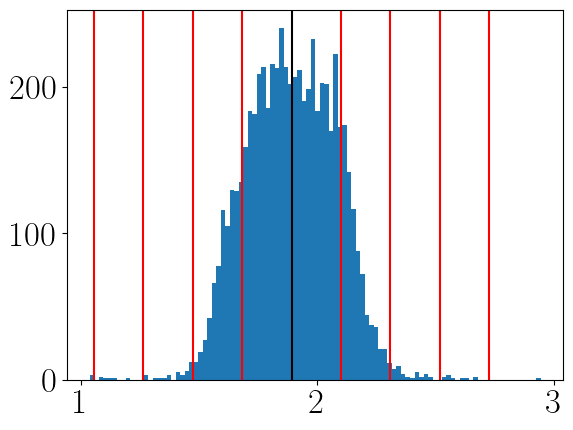

In [578]:
plt.hist(np.sqrt(lmcdr17['GAIAEDR3_PMRA']**2+lmcdr17['GAIAEDR3_PMDEC']**2),bins=100)
plt.axvline(np.nanmedian(np.sqrt(lmcdr17['GAIAEDR3_PMRA']**2+lmcdr17['GAIAEDR3_PMDEC']**2)),c='k')
for i in range(5)[1:]:
    plt.axvline(np.nanmedian(np.sqrt(lmcdr17['GAIAEDR3_PMRA']**2+lmcdr17['GAIAEDR3_PMDEC']**2))+
                i*mad(np.sqrt(lmcdr17['GAIAEDR3_PMRA']**2+lmcdr17['GAIAEDR3_PMDEC']**2)),c='r')
    plt.axvline(np.nanmedian(np.sqrt(lmcdr17['GAIAEDR3_PMRA']**2+lmcdr17['GAIAEDR3_PMDEC']**2))-
                i*mad(np.sqrt(lmcdr17['GAIAEDR3_PMRA']**2+lmcdr17['GAIAEDR3_PMDEC']**2)),c='r')
    
pm_rad = np.nanmedian(np.sqrt(lmcdr17['GAIAEDR3_PMRA']**2+lmcdr17['GAIAEDR3_PMDEC']**2))+2*mad(np.sqrt(lmcdr17['GAIAEDR3_PMRA']**2+lmcdr17['GAIAEDR3_PMDEC']**2))

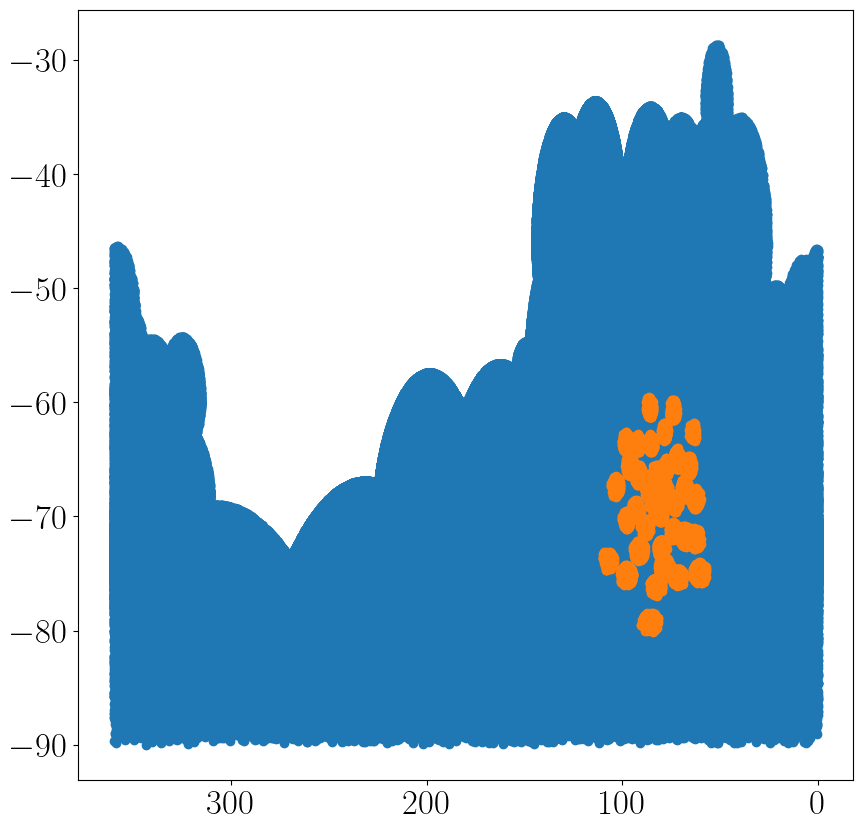

In [579]:
mcs_pm_med = np.sqrt(mcs['pmra']**2+mcs['pmdec']**2)-np.nanmedian(np.sqrt(lmcdr17['GAIAEDR3_PMRA']**2+lmcdr17['GAIAEDR3_PMDEC']**2))

# plt.hist(mcs_pm_med)

madx2 = 2*mad(np.sqrt(lmcdr17['GAIAEDR3_PMRA']**2+lmcdr17['GAIAEDR3_PMDEC']**2))

plt.figure(figsize=[10,10])
plt.scatter(mcs['ra'][(mcs_pm_med>-madx2)&(mcs_pm_med<madx2)],mcs['dec'][(mcs_pm_med>-madx2)&(mcs_pm_med<madx2)])
plt.scatter(lmcdr17['RA'],lmcdr17['DEC'])
plt.gca().invert_xaxis()

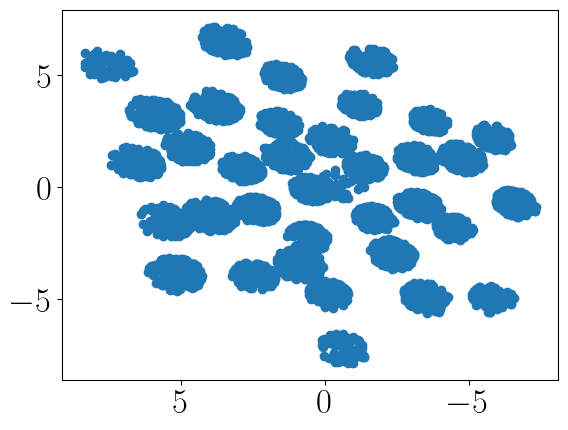

In [580]:
plt.scatter(lmcx,lmcy)
plt.gca().invert_xaxis()

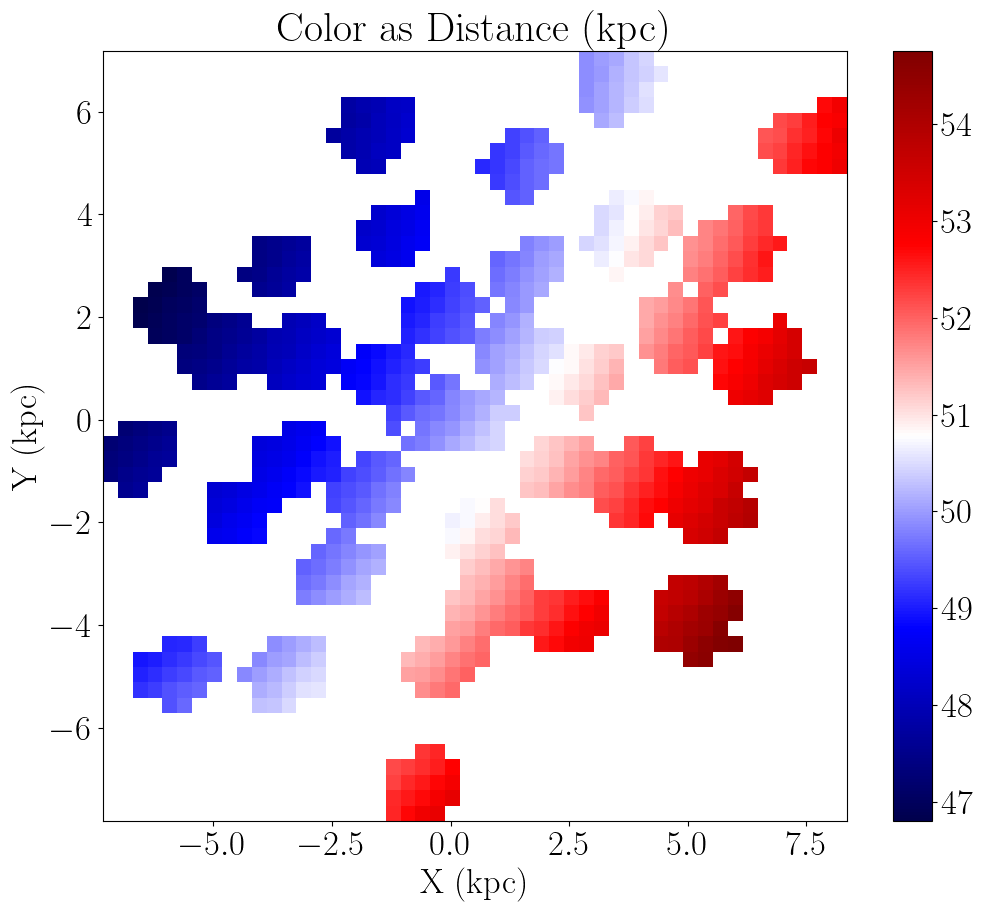

In [581]:
from scipy.stats import binned_statistic_2d

plt.figure(figsize=[12,10])
ret = binned_statistic_2d(lmcx,lmcy,lmcdis,'median',bins=50)
im = plt.imshow(ret.statistic.T, origin='lower',
                    extent=[ret.x_edge[0],ret.x_edge[-1],ret.y_edge[0],ret.y_edge[-1]],
                    aspect='auto',interpolation='nearest',cmap='seismic')
plt.colorbar()

# plt.gca().invert_xaxis()

plt.title(r'Color as Distance (kpc)')
plt.xlabel(r'X (kpc)')
plt.ylabel(r'Y (kpc)')
# plt.savefig('../plots/lmc_map_distance.png',dpi=300,bbox_inches='tight')
plt.show()

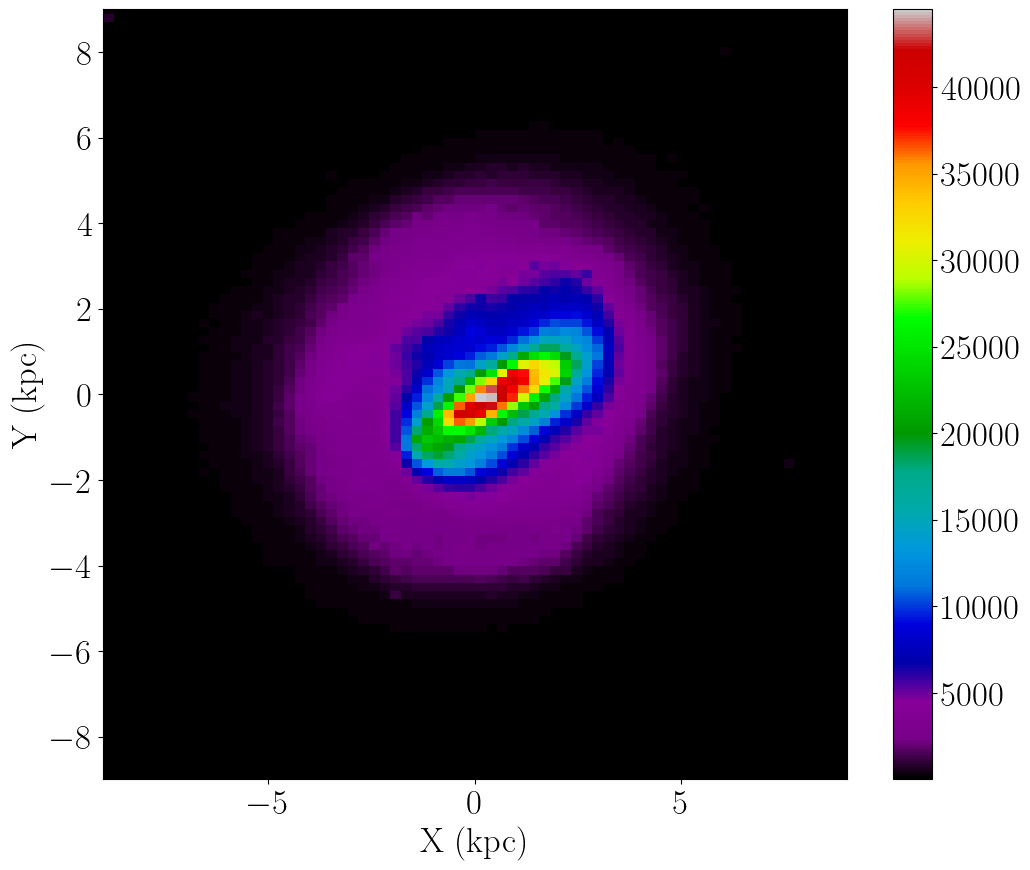

In [582]:
plt.figure(figsize=[12,10])
ret = binned_statistic_2d(gaiax,gaiay,gaiax,'count',bins=500)
ret.statistic[ret.statistic==0] = np.nan
im = plt.imshow(ret.statistic.T, origin='lower',
                    extent=[ret.x_edge[0],ret.x_edge[-1],ret.y_edge[0],ret.y_edge[-1]],
                    aspect='auto',interpolation='nearest',cmap='nipy_spectral',alpha=1)
plt.colorbar()

# plt.scatter(lmcx,lmcy,s=10)

plt.xlim(-9,9)
plt.ylim(-9,9)

# plt.gca().invert_xaxis()

# plt.title(r'Color as Distance (kpc)')
plt.xlabel(r'X (kpc)')
plt.ylabel(r'Y (kpc)')
# plt.savefig('../plots/lmc_map_distance.png',dpi=300,bbox_inches='tight')
plt.show()

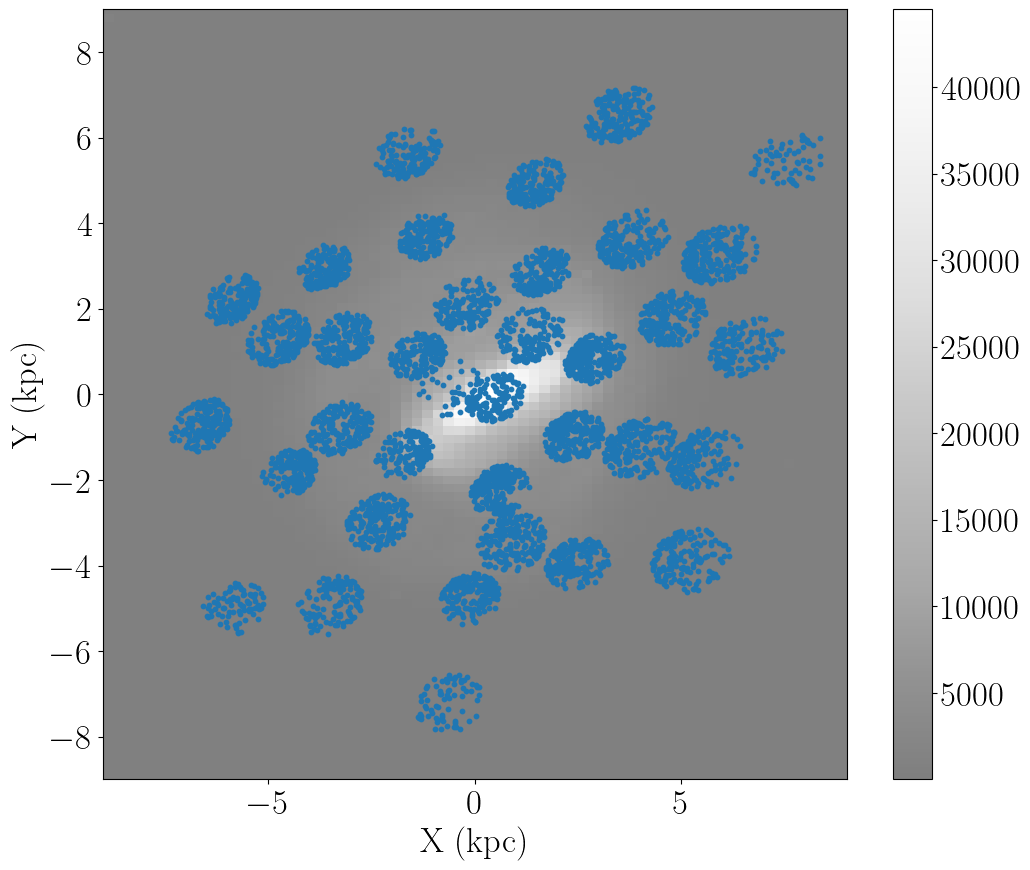

In [583]:
plt.figure(figsize=[12,10])
ret = binned_statistic_2d(gaiax,gaiay,gaiax,'count',bins=500)
ret.statistic[ret.statistic==0] = np.nan
im = plt.imshow(ret.statistic.T, origin='lower',
                    extent=[ret.x_edge[0],ret.x_edge[-1],ret.y_edge[0],ret.y_edge[-1]],
                    aspect='auto',interpolation='nearest',cmap='Greys_r',alpha=0.5)
plt.colorbar()

plt.scatter(lmcx,lmcy,s=10)

plt.xlim(-9,9)
plt.ylim(-9,9)

# plt.gca().invert_xaxis()

# plt.title(r'Color as Distance (kpc)')
plt.xlabel(r'X (kpc)')
plt.ylabel(r'Y (kpc)')
# plt.savefig('../plots/lmc_map_distance.png',dpi=300,bbox_inches='tight')
plt.show()

# Calculated Age Read in 

In [584]:
agetab = Table.read('lmc_lm_wgtage_21OCT2022.fits')

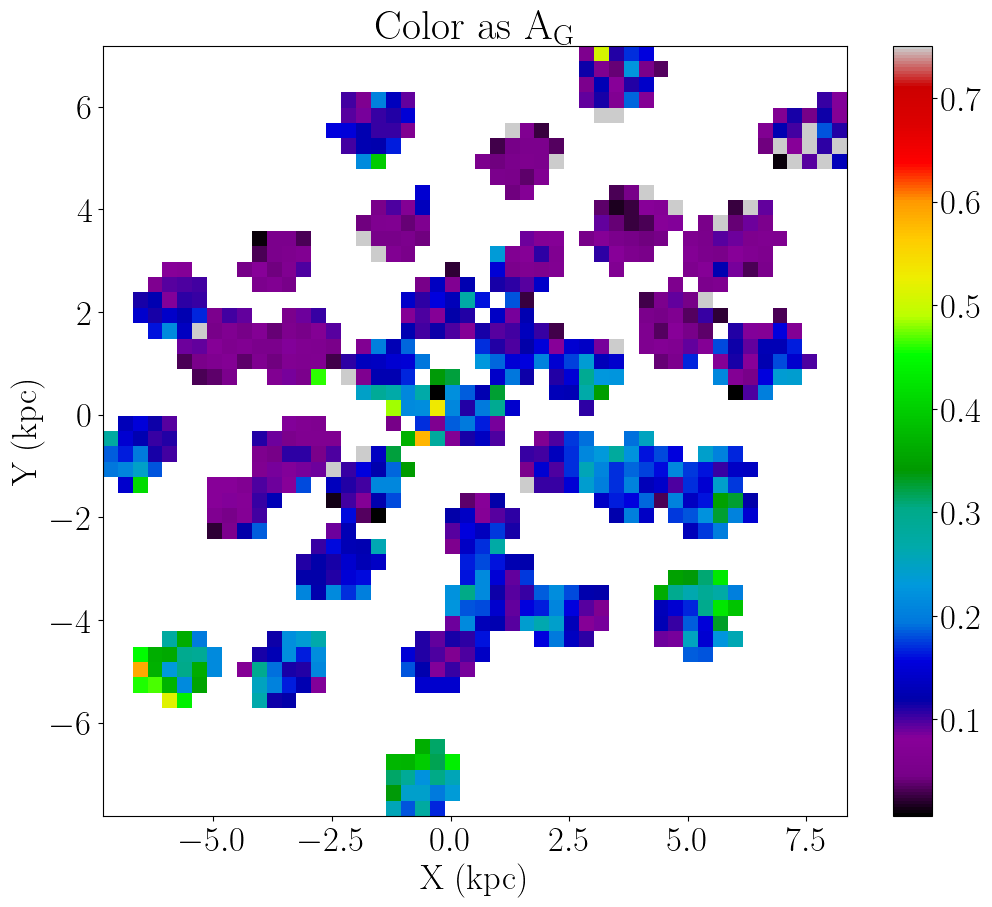

In [585]:
plt.figure(figsize=[12,10])
ret = binned_statistic_2d(lmcx,lmcy,agetab['EXT'][:,1],'median',bins=50)
im = plt.imshow(ret.statistic.T, origin='lower',
                    extent=[ret.x_edge[0],ret.x_edge[-1],ret.y_edge[0],ret.y_edge[-1]],
                    aspect='auto',interpolation='nearest',cmap='nipy_spectral',vmax=0.75)
plt.colorbar()

plt.title(r'Color as A$_{\rm G}$')
plt.xlabel(r'X (kpc)')
plt.ylabel(r'Y (kpc)')
plt.savefig('lmc_map_ag.png',dpi=300,bbox_inches='tight')
plt.show()

(array([2665., 1865.,  818.,  258.,  101.,   30.,    9.,    5.,    0.,
           0.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

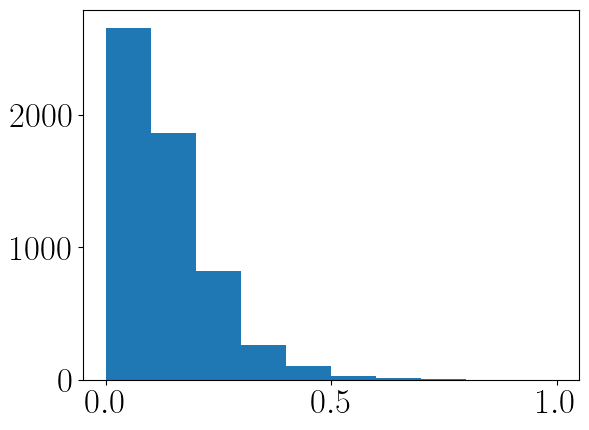

In [586]:
plt.hist(agetab['EXT'][:,1],range=(0,1))

# Age Map and Gradient

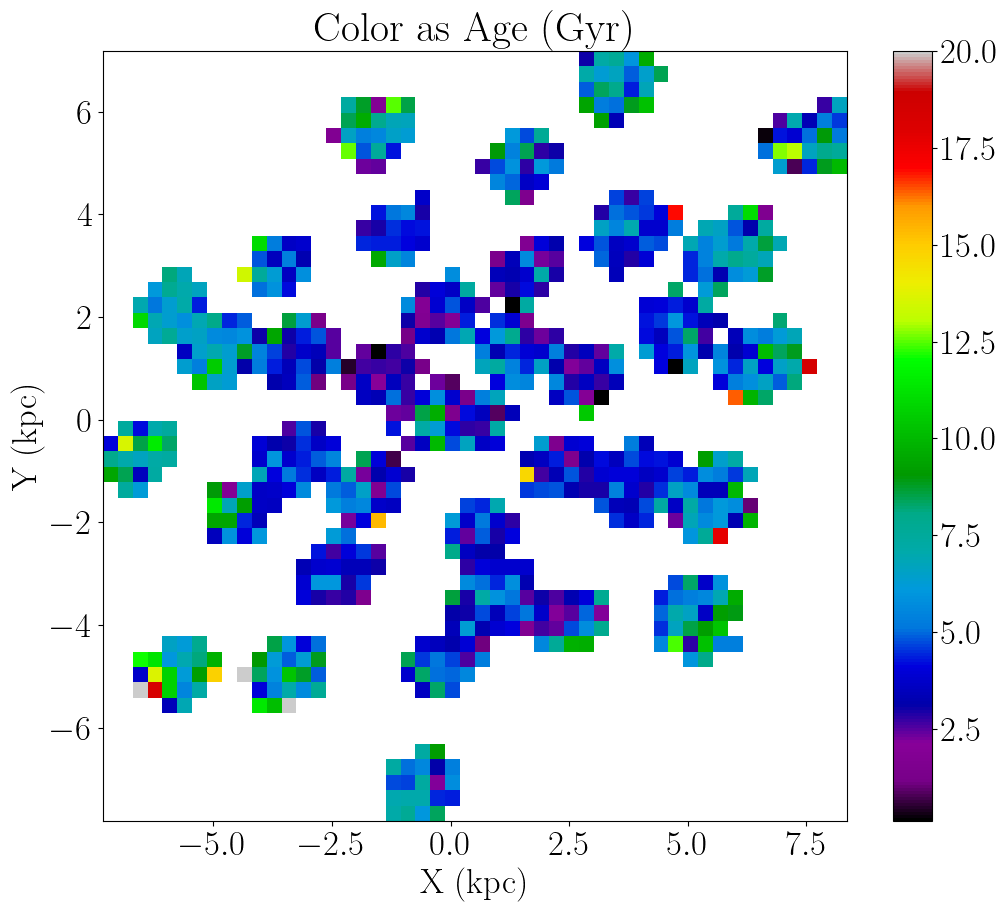

In [587]:
plt.figure(figsize=[12,10])
ret = binned_statistic_2d(lmcx,lmcy,agetab['AGE'],'median',bins=50)
im = plt.imshow(ret.statistic.T, origin='lower',
                    extent=[ret.x_edge[0],ret.x_edge[-1],ret.y_edge[0],ret.y_edge[-1]],
                    aspect='auto',interpolation='nearest',cmap='nipy_spectral',vmax=20)
plt.colorbar()

plt.title(r'Color as Age (Gyr)')
plt.xlabel(r'X (kpc)')
plt.ylabel(r'Y (kpc)')
plt.savefig('../plots/lmc_map_age.png',bbox_inches='tight')
plt.show()

In [588]:
import numpy as np
from scipy.optimize import minimize
from scipy.stats import binned_statistic

### MLE Functions

def linmodl(m,b,x):
    '''
    Slope-intercept form of a line
    
    Parameters:
    ----------
        m: slope of line
        x: exog of line
        b: intercept of line
        
    Returns:
    -------
        y: endog of line
    '''
    y = m*x + b
    return y

def lnL(theta,x,y,yerr):
    '''
    Log likelihood for linmodl
    
    Parameters:
    ----------
        theta: parameters to plug into linmodl (m,b)
        x: exog of line
        y: endog of line
        yerr: endog error
    
    Returns:
    -------
        lnl: log likelihood 
    '''
    
    m, b = theta
    modl = linmodl(m,b,x)
    inv_sig2 = np.reciprocal(np.square(yerr))
    lnl = -0.5 * np.sum(np.multiply(np.square((y - modl)),inv_sig2) - np.log(inv_sig2/(2*np.pi)))
    return lnl

### MCMC Specific

def lnPrior(theta):
    '''
    Using a flat prior to calculate the log prior
    
    Parameters:
    ----------
    theta: model parameters
    
    '''
    m, b = theta
    if -1.0 < m < 1.0 and -2.0 < b < 2.0:
        return 0.0
    return -np.inf

def lnProb(theta, x, y, yerr):
    '''
    Calculate the log probability
    
    Parameters:
    ----------
    theta: model parameters
    x: x coordinate data
    y: y coordinate data
    y_err: y error
    
    '''
    
    lnP = lnPrior(theta)
    if not np.isfinite(lnP):
        return -np.inf
    return lnP + lnL(theta, x, y, yerr)

def MLELinearParameters(rad,age,bin_width):
    '''
    Calculate the MLE parameters for a linear abundance trend
    
    Inputs:
    ------
        rad:         array-like
                     radial coordinate
        
        age:         array-like
                     ages
                     
        
        #age_err:     array-like
        #             error in ages
                     
        bin_width:   float
                     width of bin
        
    Outputs:
    ------- 
        mle_m,mle_b: floats
                     MLE parameters
    '''
    
    # bin data and calculate statistic and error for each bin
    bins = np.arange(np.floor(np.min(rad)),np.ceil(np.max(rad))+bin_width,bin_width)
    bin_stats, _, _ = binned_statistic(rad,age,statistic='median',bins=bins)
    
    # get MAD of each bin
    bin_stats_err, _, _ = binned_statistic(rad,age,statistic=lambda y: mad(y),bins=bins)
    
    # shift radial values to center of bins
    center_rad_bins = np.delete(bin_edges,-1)+0.5*bin_width
    
    # calculate guess for MLE
    m_guess = (bin_stats[1]-bin_stats[0])/(center_rad_bins[1]-center_rad_bins[0])
    b_guess = bin_stats[0]
    
    # do MLE with log likelihood (lnL)
    nll = lambda *args: -lnL(*args)
    initial = np.array([m_guess, b_guess]) + 0.1 * np.random.randn(2)
    soln = minimize(nll, initial, args=(center_rad_bins, bin_stats, bin_stats_err))
    mle_m, mle_b = soln.x
    
    # Initialize MCMC
    pos = np.array([mle_m,mle_b]) + 1e-4 * np.random.randn(32, 2)
    nwalkers, ndim = pos.shape
    sampler = emcee.EnsembleSampler(
    nwalkers, ndim, lnProb, args=(center_rad_bins, bin_stats, bin_stats_err)
    )
    sampler.run_MCMC(pos,5000,progress=True)
    
    # Plot
    fig, axes = plt.subplots(2, figsize=(10, 5), sharex=True)
    samples = sampler.get_chain()
    labels = ["m", "b"]
    for i in range(ndim):
        ax = axes[i]
        ax.plot(samples[:, :, i], "k", alpha=0.3)
        ax.set_xlim(0, len(samples))
        ax.set_ylabel(labels[i])
        ax.yaxis.set_label_coords(-0.1, 0.5)

    axes[-1].set_xlabel("step number");
    
    return mle_m,mle_b

In [589]:
# cln = np.where((np.isfinite(agetab['AGE'])==True)&(agetab['AGE']!=999999.0)&(lmcdr17['SNR']>100.))

# mle_m, mle_b = MLELinearParameters(lmcr[cln],agetab['AGE'][cln],1.0)
# print(mle_m)
# print(mle_b)

In [590]:
# import emcee

# pos = np.array([mle_m,mle_b]) + 1e-4 * np.random.randn(32, 2)
# nwalkers, ndim = pos.shape

# sampler = emcee.EnsembleSampler(
#     nwalkers, ndim, lnProb, args=(lmcr[cln], agetab['AGE'][cln], agetab['AGE_ERR'][cln])
# )
# sampler.run_mcmc(pos, 5000, progress=True);

In [591]:
cln = np.where((np.isfinite(agetab['AGE'])==True)&(agetab['AGE']!=999999.0)&(lmcdr17['SNR']>100.))
rad = lmcr[cln]
age = agetab['AGE'][cln]
bin_width = 0.5

# bin data and calculate statistic and error for each bin
bins = np.arange(np.floor(np.min(rad)),np.ceil(np.max(rad))+bin_width,bin_width)
bin_stats, bin_edges, _ = binned_statistic(rad,age,statistic='median',bins=bins)

# # get MAD of each bin
bin_stats_err, _, _ = binned_statistic(rad,age,statistic=mad,bins=bins)#lambda y: mad(y)

# # shift radial values to center of bins
center_rad_bins = np.delete(bin_edges,-1)+0.5*bin_width

fincut, = np.where((np.isfinite(bin_stats)==True)&(np.isfinite(bin_stats_err)==True))#&(bin_stats_err!=0.))
bin_stats = bin_stats[fincut]
bin_stats_err = bin_stats_err[fincut]
center_rad_bins = center_rad_bins[fincut]

# calculate guess for MLE
m_guess = (bin_stats[1]-bin_stats[0])/(center_rad_bins[1]-center_rad_bins[0])
b_guess = bin_stats[0]

# do MLE with log likelihood (lnL)
nll = lambda *args: -lnL(*args)
initial = np.array([m_guess, b_guess]) + 0.1 * np.random.randn(2)
soln = minimize(nll, initial, args=(lmcr, agetab['AGE'], agetab['AGE_ERR']))
mle_m, mle_b = soln.x

# # Initialize MCMC
# pos = np.array([mle_m,mle_b]) + 1e-2 * np.random.randn(32, 2)
# nwalkers, ndim = pos.shape
# sampler = emcee.EnsembleSampler(
#     nwalkers, ndim, lnProb, args=(lmcr[cln], agetab['AGE'][cln], agetab['AGE_ERR'])
# )
# sampler.run_mcmc(pos, 10000, progress=True);

# # Plot
# fig, axes = plt.subplots(2, figsize=(10, 5), sharex=True)
# samples = sampler.get_chain()
# labels = ["m", "b"]
# for i in range(ndim):
#     ax = axes[i]
#     ax.plot(samples[:, :, i], "k", alpha=0.3)
#     ax.set_xlim(0, len(samples))
#     ax.set_ylabel(labels[i])
#     ax.yaxis.set_label_coords(-0.1, 0.5)

# axes[-1].set_xlabel("step number");

In [592]:
# bin_stats_err

In [593]:
# fincut, = np.where((np.isfinite(bin_stats)==True)&(np.isfinite(bin_stats_err)==True))
# plt.plot(center_rad_bins[fincut],bin_stats[fincut])
# plt.plot(np.linspace(0,max(lmcr)),mle_m*np.linspace(0,max(lmcr)+mle_b))

In [594]:
# plt.figure(figsize=[12,7])
# # plt.scatter(lmcr[cln],agetab['AGE'][cln])
# plt.plot(center_rad_bins, bin_stats,c='k')
# plt.plot(np.linspace(0,8.5),mle_m*np.linspace(0,8.5)+mle_b,c='k')
# # plt.ylim(0,20)

In [595]:
# plt.figure(figsize=[12,10])
# plt.scatter(lmcr,agetab['AGE'],s=10)
# plt.plot(center_rad_bins,bin_stats,c='k',lw=3)
# plt.ylim(0,20)

In [596]:
med_fld_age = 999999.0*np.ones(len(np.unique(lmcdr17['FIELD'])))
mad_fld_age = 999999.0*np.ones(len(np.unique(lmcdr17['FIELD'])))

fld_centers = 999999.0*np.ones((len(np.unique(lmcdr17['FIELD'])),2))

fld_radius = 999999.0*np.ones(len(np.unique(lmcdr17['FIELD'])))

fld_feh = 999999.0*np.ones(len(np.unique(lmcdr17['FIELD'])))
fld_feh_mad = 999999.0*np.ones(len(np.unique(lmcdr17['FIELD'])))

fld_pa = 999999.0*np.ones(len(np.unique(lmcdr17['FIELD'])))

for i in range(len(np.unique(lmcdr17['FIELD']))):
    fld, = np.where(lmcdr17['FIELD']==np.unique(lmcdr17['FIELD'])[i])
    
    med_fld_age[i] = np.nanmedian(agetab['AGE'][fld])
    mad_fld_age[i] = mad(agetab['AGE'][fld])
    
    medx = np.nanmedian(lmcx[fld])
    medy = np.nanmedian(lmcy[fld])
    
    fld_centers[i,0] = medx
    fld_centers[i,1] = medy
    
    fld_radius[i] = np.nanmedian(lmcr[fld])
    
    fld_feh[i] = np.nanmedian(lmcdr17['FE_H'][fld]) 
    fld_feh_mad[i] = mad(lmcdr17['FE_H'][fld]) 
    fld_pa[i] = np.nanmedian(lmcdr17['LMCPA'][fld]) 

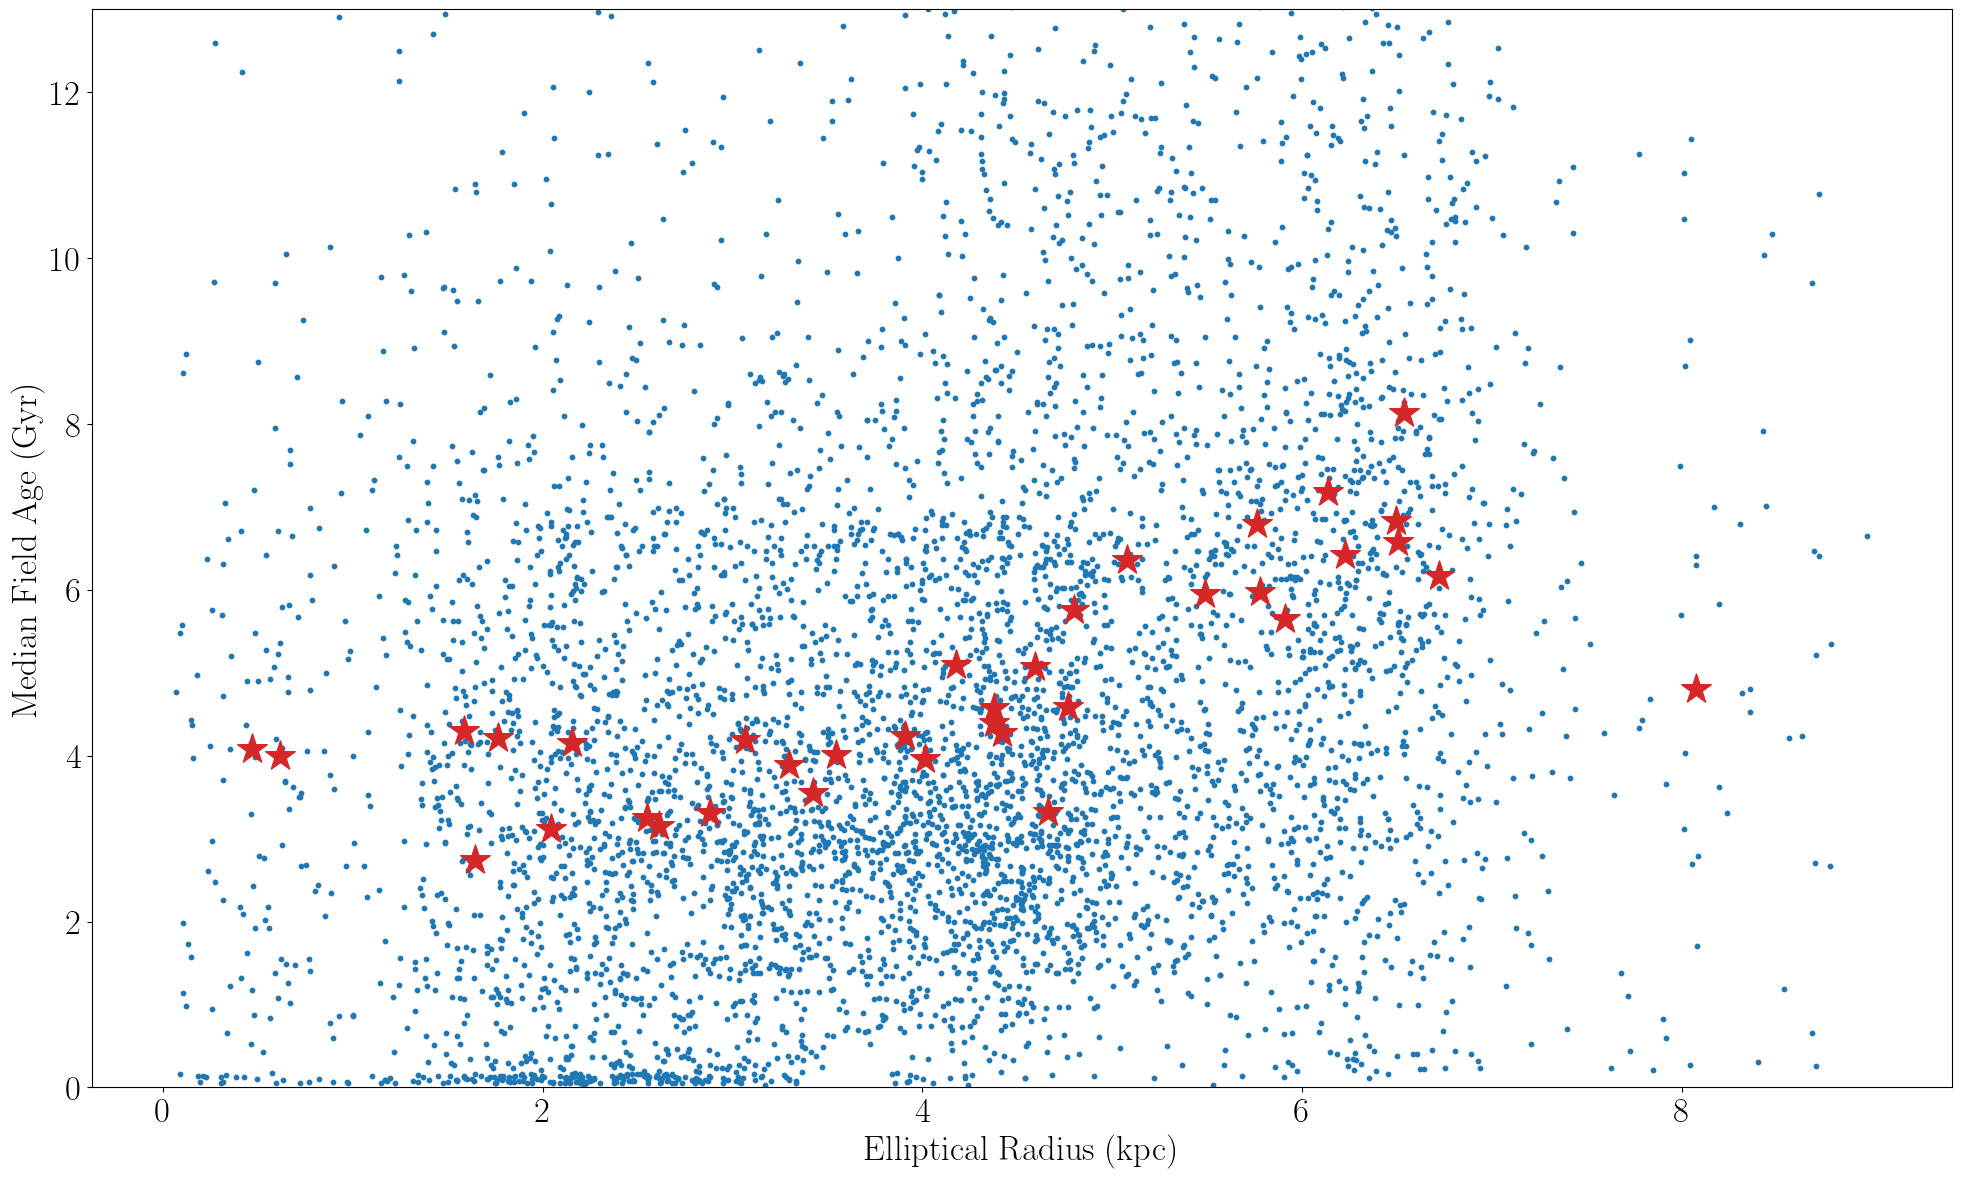

In [597]:
plt.figure(figsize=[24,14])
plt.scatter(lmcr,agetab['AGE'],c='tab:blue',s=10)
plt.scatter(fld_radius,med_fld_age,c='tab:red',marker='*',s=500)
# plt.plot(center_rad_bins,bin_stats,c='k',lw=3)
plt.ylim(0,13)
plt.xlabel(r'Elliptical Radius (kpc)')
plt.ylabel(r'Median Field Age (Gyr)')
# plt.savefig('lmc_fld_age_radius.png',bbox_inches='tight')
plt.show()

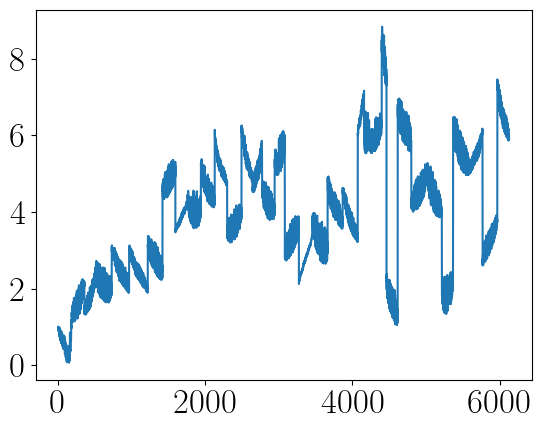

In [598]:
plt.plot(lmcsr)

(array([  52.,  194.,  138.,  104.,  379.,  660.,  930., 1075.,  888.,
        1710.]),
 array([-8.04877822e-01, -7.24390040e-01, -6.43902258e-01, -5.63414476e-01,
        -4.82926693e-01, -4.02438911e-01, -3.21951129e-01, -2.41463347e-01,
        -1.60975565e-01, -8.04877824e-02, -2.52213361e-10]),
 <BarContainer object of 10 artists>)

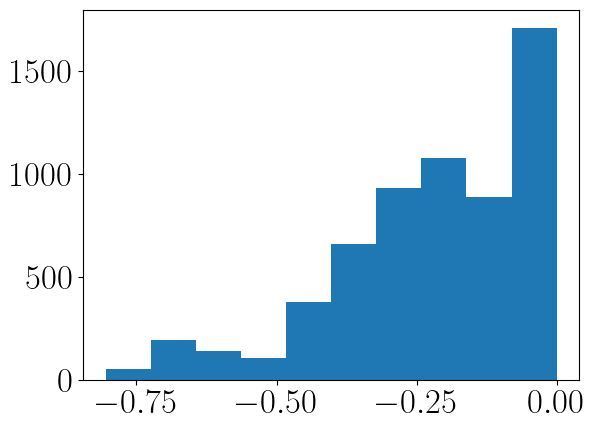

In [599]:
plt.hist(lmcsr-lmcr)

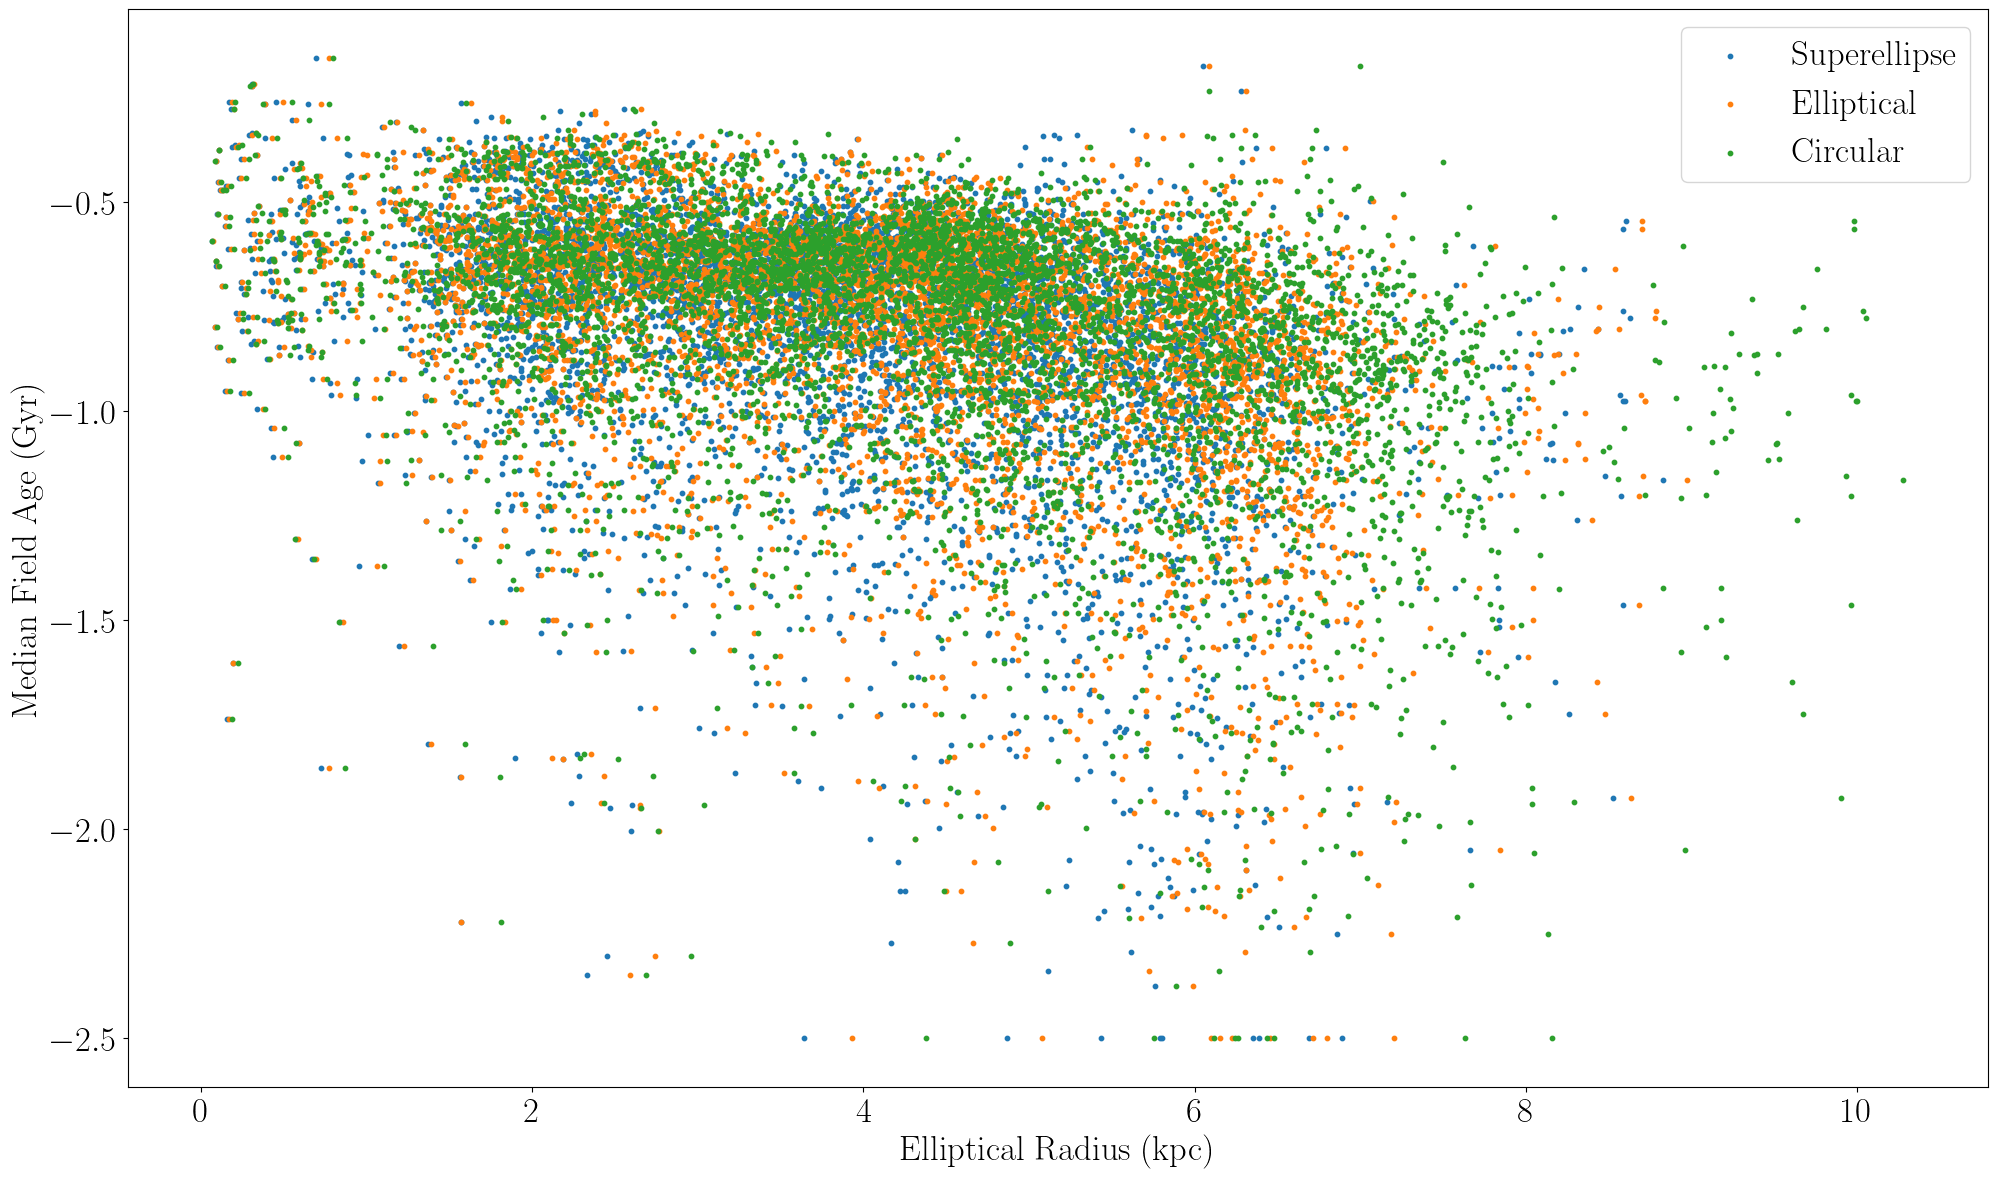

In [600]:
plt.figure(figsize=[24,14])
plt.scatter(lmcsr,lmcdr17['FE_H'],s=10,label='Superellipse')
plt.scatter(lmcr,lmcdr17['FE_H'],s=10,label='Elliptical')
plt.scatter(np.sqrt(lmcx**2+lmcy**2),lmcdr17['FE_H'],s=10,label='Circular')
plt.legend()
# plt.scatter(fld_radius,med_fld_age,c='tab:red',marker='*',s=500)
# plt.plot(center_rad_bins,bin_stats,c='k',lw=3)
# plt.ylim(0,13)
plt.xlabel(r'Elliptical Radius (kpc)')
plt.ylabel(r'Median Field Age (Gyr)')
# plt.savefig('lmc_fld_age_radius.png',bbox_inches='tight')
plt.show()

In [601]:
# chi_sq = []

# sidx = np.argsort(fld_radius)
# for i in range(10)[1:]:
    
#     p = np.poly1d(np.polyfit(fld_radius[sidx][:-1],med_fld_age[sidx][:-1],i,w=1/mad_fld_age[sidx][:-1]))
    
#     chi_sq.append(sum(np.square(np.divide(med_fld_age[sidx][:-1]-p(fld_radius[sidx][:-1]),mad_fld_age[sidx][:-1])))) #/(len(fld_radius[:-1]-(i+1))))
    
# chi_sq = np.array(chi_sq)
    
# plt.scatter(range(10)[1:],chi_sq)
# plt.xlabel(r'Polynomial Order')
# plt.ylabel(r'Chi Sq')
# # plt.savefig(r'chisq_age_radius_polyfit.png',bbox_inches='tight')
# plt.show()

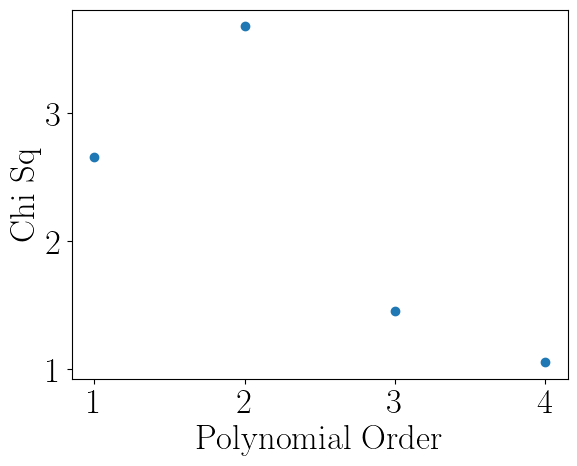

In [602]:
chi_sq = []

sidx = np.argsort(fld_radius)
for i in range(5)[1:]:
    
    p = np.poly1d(robust.polyfit(fld_radius[sidx],med_fld_age[sidx],i))
    
    chi_sq.append(sum(np.square(np.divide(med_fld_age[sidx]-p(fld_radius[sidx]),mad_fld_age[sidx])))) #/(len(fld_radius[:-1]-(i+1))))
    
chi_sq = np.array(chi_sq)
    
plt.scatter(np.arange(len(chi_sq))+1,chi_sq)
plt.xlabel(r'Polynomial Order')
plt.ylabel(r'Chi Sq')
# plt.savefig(r'chisq_age_radius_polyfit.png',bbox_inches='tight')
plt.show()

         4          3         2
-0.0221 x + 0.2865 x - 1.009 x + 0.9739 x + 3.778


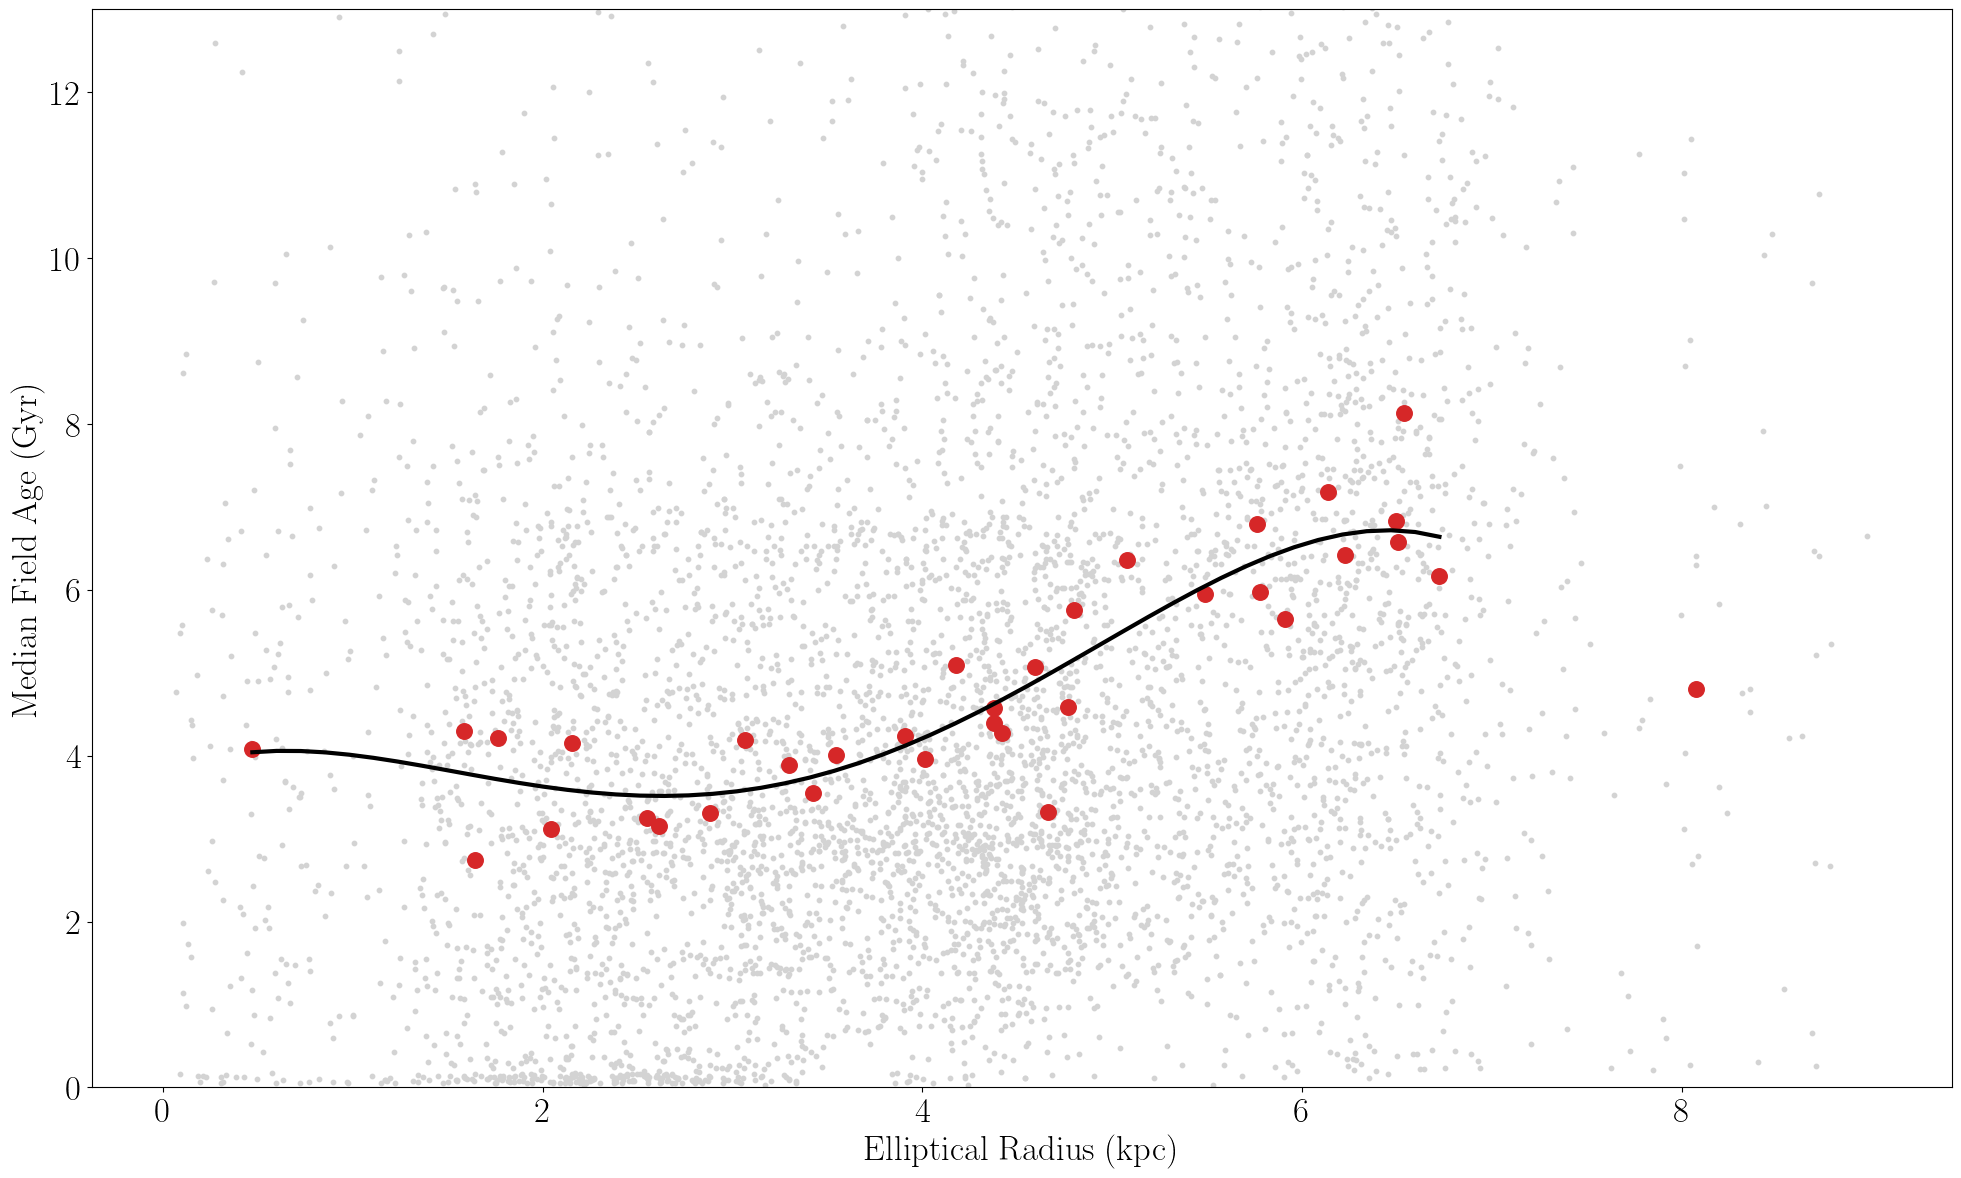

In [603]:
p_raw = np.poly1d(robust.polyfit(fld_radius[fld_radius<8],med_fld_age[fld_radius<8],4))
print(p_raw)

plt.figure(figsize=[24,14])
plt.scatter(lmcr,agetab['AGE'],c='lightgray',s=10)
plt.scatter(fld_radius[:-1],med_fld_age[:-1],c='tab:red',marker='.',s=500)
xs_rads = np.linspace(min(fld_radius[np.argsort(fld_radius)][:-1]),max(fld_radius[np.argsort(fld_radius)][:-1]))
plt.plot(xs_rads,p_raw(xs_rads),c='k',lw=3)
plt.ylim(0,13)
plt.xlabel(r'Elliptical Radius (kpc)')
plt.ylabel(r'Median Field Age (Gyr)')
# plt.savefig('lmc_fld_age_radius_w_poly.png',bbox_inches='tight')
plt.show()

In [604]:
# p2 = np.poly1d(np.polyfit(fld_radius[sidx][:-1],med_fld_age[sidx][:-1],2,w=1/mad_fld_age[sidx][:-1]))

# plt.figure(figsize=[24,14])
# plt.scatter(lmcr,agetab['AGE'],c='lightgray',s=10)
# plt.scatter(fld_radius[:-1],med_fld_age[:-1],c='tab:red',marker='.',s=500)
# xs_rads = np.linspace(min(fld_radius[np.argsort(fld_radius)][:-1]),max(fld_radius[np.argsort(fld_radius)][:-1]))
# plt.plot(xs_rads,p2(xs_rads),c='k',lw=3)
# plt.ylim(0,13)
# plt.xlabel(r'Elliptical Radius (kpc)')
# plt.ylabel(r'Median Field Age (Gyr)')
# plt.savefig('lmc_fld_age_radius_w_poly.png',bbox_inches='tight')
# plt.show()

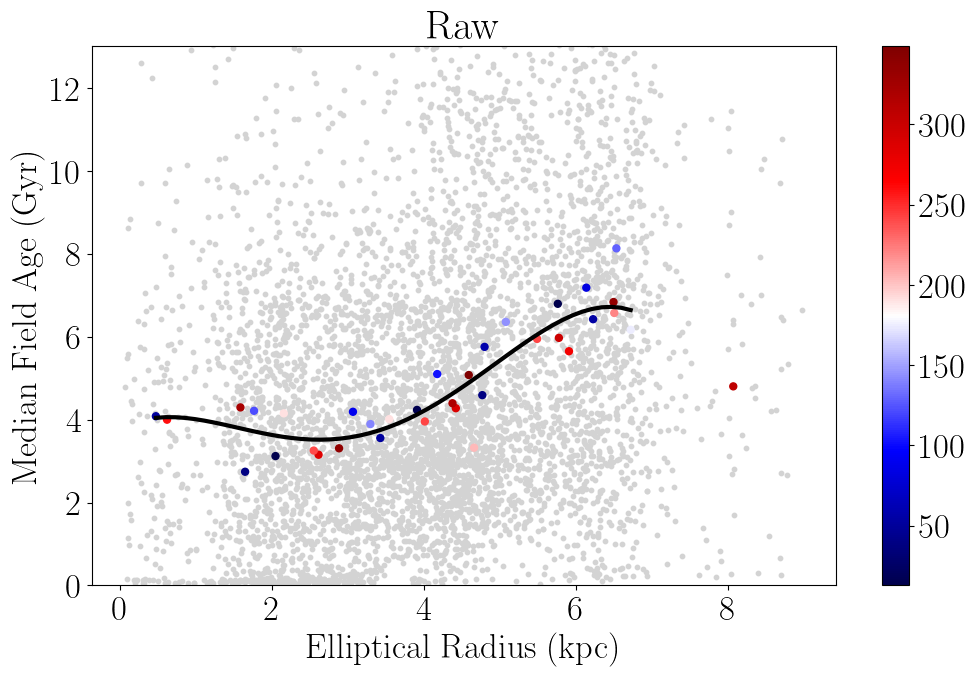

In [605]:
plt.figure(figsize=[12,7])
plt.scatter(lmcr,agetab['AGE'],c='lightgray',s=10)
plt.scatter(fld_radius,med_fld_age,c=fld_pa,marker='.',s=100,cmap='seismic')
# plt.scatter(fld_radius[south_fld],med_fld_age[south_fld],c=fld_pa[south_fld],marker='v',s=100,cmap='twilight_shifted',label='South')
plt.colorbar()
# plt.legend()
xs_rads = np.linspace(min(fld_radius[np.argsort(fld_radius)][:-1]),max(fld_radius[np.argsort(fld_radius)][:-1]))
plt.plot(xs_rads,p_raw(xs_rads),c='k',lw=3)
plt.ylim(0,13)
plt.title(r'Raw')
plt.xlabel(r'Elliptical Radius (kpc)')
plt.ylabel(r'Median Field Age (Gyr)')
plt.savefig('lmc_fld_age_radius_w_poly.png',bbox_inches='tight')
plt.show()

# subract poly from points and plot on sky or you could plot res vs pa color coded by radius

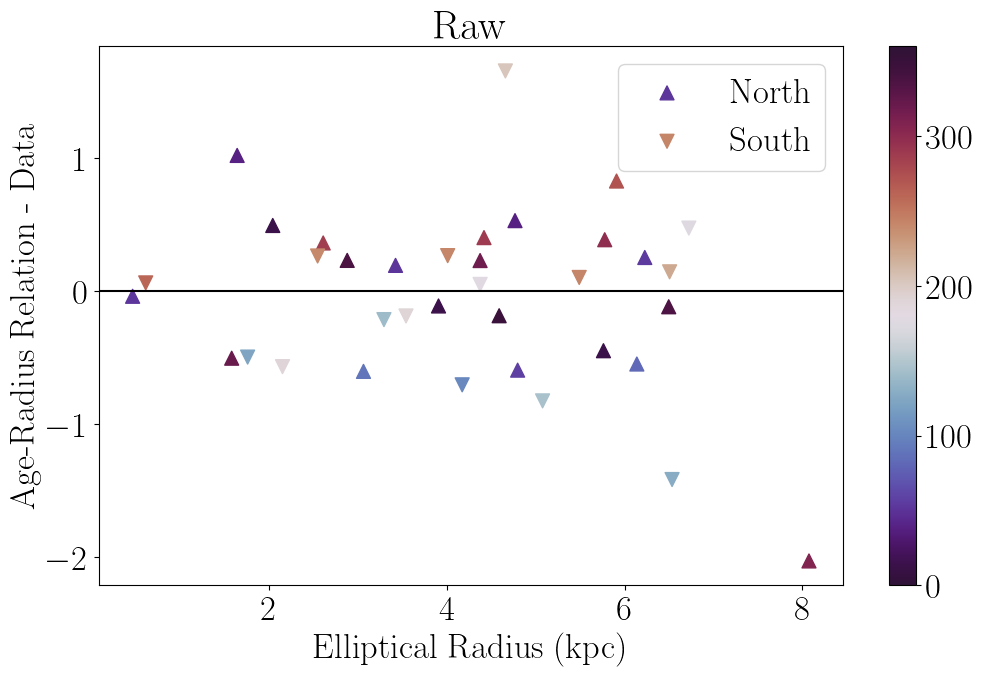

In [606]:
north_fld, = np.where((fld_pa<=90.)|(fld_pa>=270.))
south_fld, = np.where((fld_pa>90.)&(fld_pa<270.))

raw_res_fld_age = p_raw(fld_radius)-med_fld_age

plt.figure(figsize=[12,7])
plt.scatter(fld_radius[north_fld],raw_res_fld_age[north_fld],c=fld_pa[north_fld],marker='^',s=100,cmap='twilight_shifted',vmin=0,vmax=360,label='North')
plt.scatter(fld_radius[south_fld],raw_res_fld_age[south_fld],c=fld_pa[south_fld],marker='v',s=100,cmap='twilight_shifted',vmin=0,vmax=360,label='South')
plt.colorbar()
plt.legend()
plt.axhline(0.0,c='k')

plt.title(r'Raw')
plt.xlabel(r'Elliptical Radius (kpc)')
plt.ylabel(r'Age-Radius Relation - Data')
plt.show()

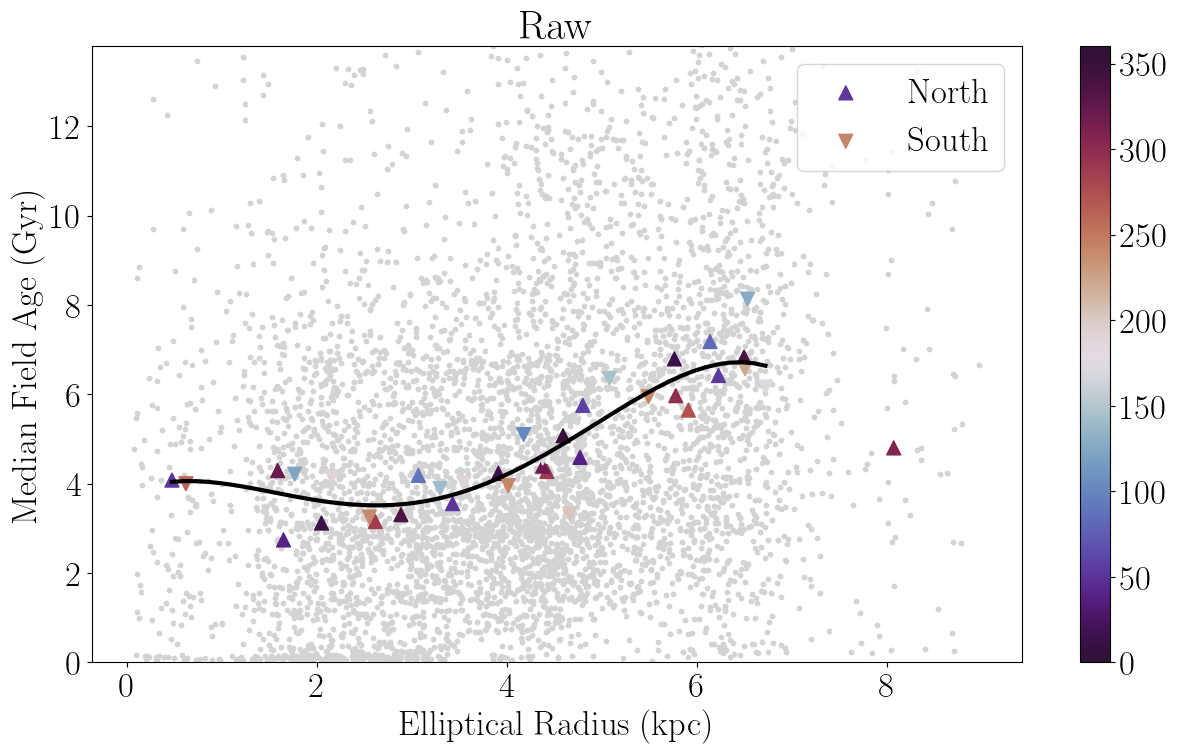

In [607]:
plt.figure(figsize=[15,8])
plt.scatter(lmcr,agetab['AGE'],c='lightgray',s=10)
plt.scatter(fld_radius[north_fld],med_fld_age[north_fld],marker='^',c=fld_pa[north_fld],s=100,label='North',cmap='twilight_shifted',vmin=0,vmax=360)
plt.scatter(fld_radius[south_fld],med_fld_age[south_fld],marker='v',c=fld_pa[south_fld],s=100,label='South',cmap='twilight_shifted',vmin=0,vmax=360)
plt.colorbar()
plt.legend()
xs_rads = np.linspace(min(fld_radius[np.argsort(fld_radius)][:-1]),max(fld_radius[np.argsort(fld_radius)][:-1]))
plt.plot(xs_rads,p_raw(xs_rads),c='k',lw=3)
plt.ylim(0,13.787)
plt.title(r'Raw')
plt.xlabel(r'Elliptical Radius (kpc)')
plt.ylabel(r'Median Field Age (Gyr)')
# plt.savefig('lmc_fld_age_radius_w_poly.png',bbox_inches='tight')
plt.show()

0.29801465472178545


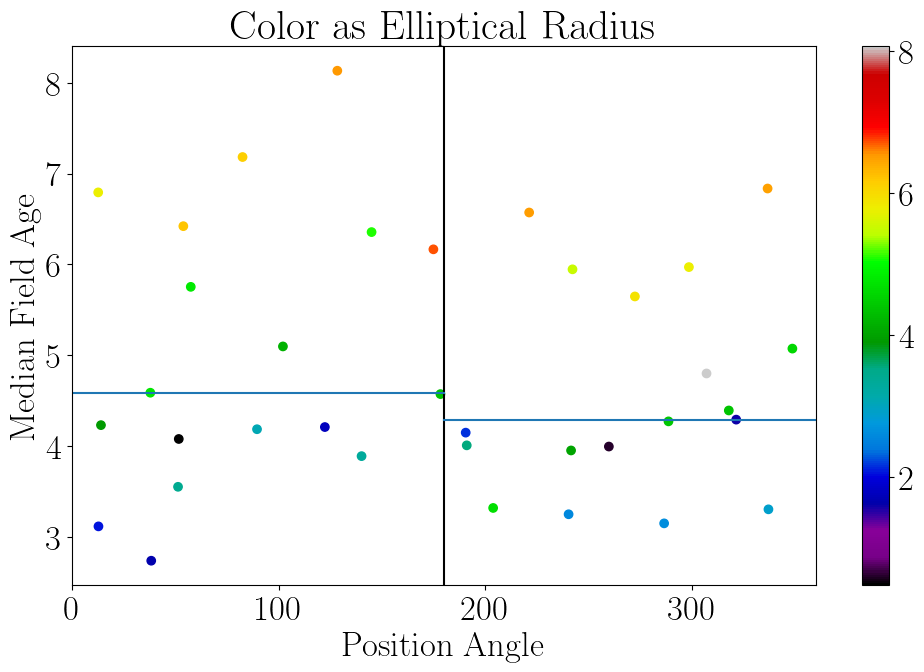

In [608]:
print(np.median(med_fld_age[fld_pa<180])-np.median(med_fld_age[fld_pa>180]))
plt.figure(figsize=[12,7])
plt.scatter(fld_pa,med_fld_age,c=fld_radius,cmap='nipy_spectral')
plt.colorbar()
plt.axvline(180,c='k')

plt.plot([0,180],[np.median(med_fld_age[fld_pa<180]),np.median(med_fld_age[fld_pa<180])],c='tab:blue')
plt.plot([180,360],[np.median(med_fld_age[fld_pa>180]),np.median(med_fld_age[fld_pa>180])],c='tab:blue')

plt.xlim(0,360)
plt.title(r'Color as Elliptical Radius')
plt.xlabel(r'Position Angle')
plt.ylabel(r'Median Field Age')
plt.show()

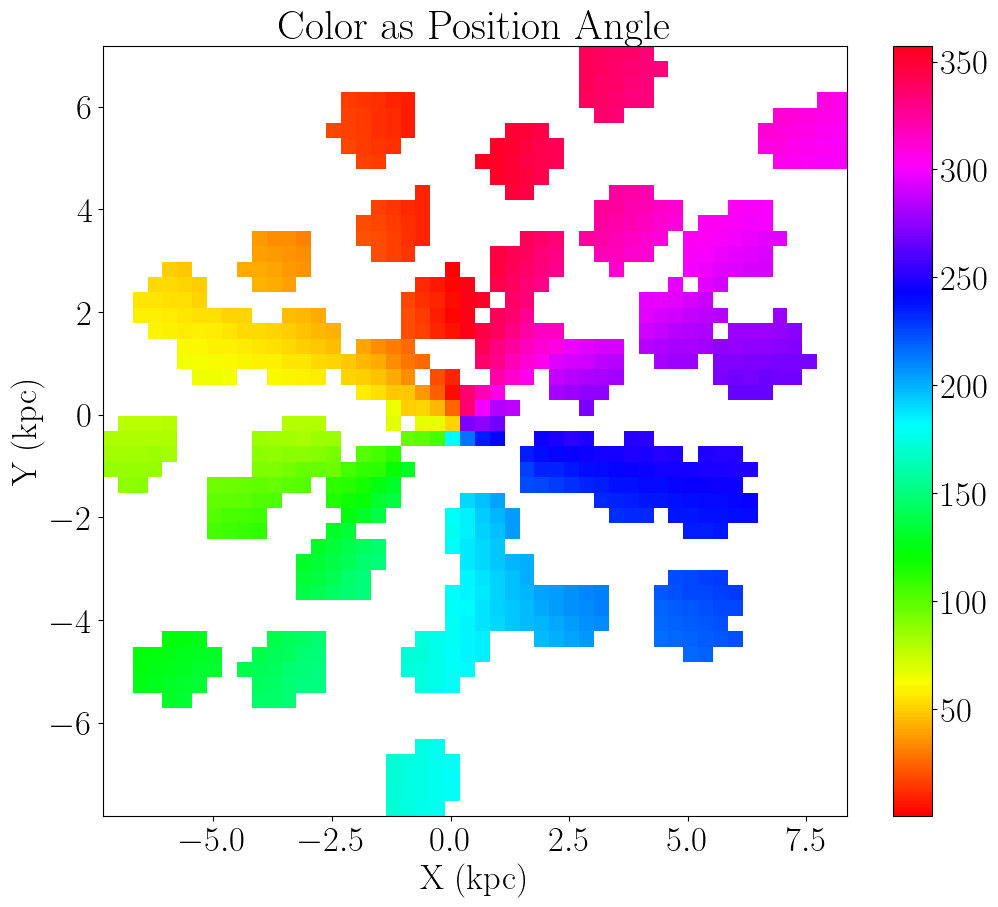

In [609]:
lmc_pa2 = 999999.0*np.ones(len(lmcdr17))

for i in range(len(lmcdr17)):
    rot_pa = lmcdr17['LMCPA'][i]+90.
    
    if rot_pa>360:
        lmc_pa2[i] = rot_pa-360
    else:
        lmc_pa2[i] = rot_pa

plt.figure(figsize=[12,10])
ret = binned_statistic_2d(lmcx,lmcy,lmcdr17['LMCPA'],'median',bins=50)
im = plt.imshow(ret.statistic.T, origin='lower',
                    extent=[ret.x_edge[0],ret.x_edge[-1],ret.y_edge[0],ret.y_edge[-1]],
                    aspect='auto',interpolation='nearest',cmap='hsv')
plt.colorbar()

plt.title(r'Color as Position Angle')
plt.xlabel(r'X (kpc)')
plt.ylabel(r'Y (kpc)')
# plt.savefig('lmc_map_ag.png',dpi=300,bbox_inches='tight')
plt.show()

In [610]:
# p2.deriv().roots

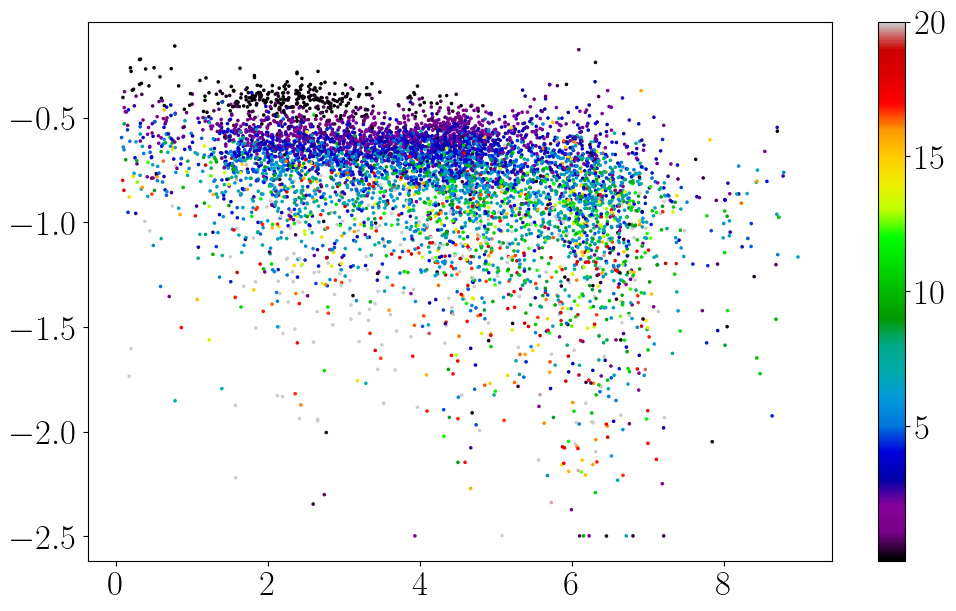

In [611]:
plt.figure(figsize=[12,7])
plt.scatter(lmcr,lmcdr17['FE_H'],c=agetab['AGE'],marker='.',s=10,cmap='nipy_spectral',vmax=20)
plt.colorbar()

# Median Field Age Map

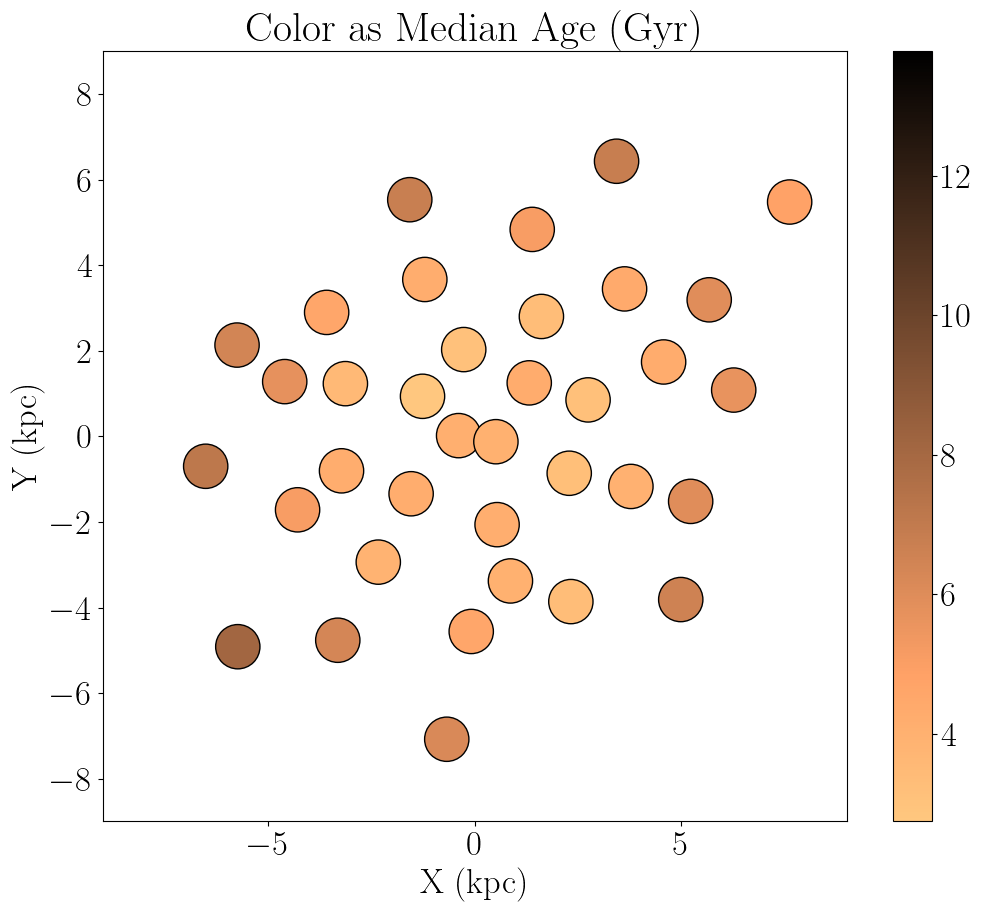

In [612]:
cen_xy = 999999.0*np.zeros((len(np.unique(lmcdr17['FIELD'])),2))

for i in range(len(np.unique(lmcdr17['FIELD']))):
    clus, = np.where(lmcdr17['FIELD']==np.unique(lmcdr17['FIELD'])[i])
    cen_xy[i,0] = np.nanmedian(lmcx[clus])
    cen_xy[i,1] = np.nanmedian(lmcy[clus])

fig, ax = plt.subplots(1,1,figsize=[12,10])
plt.title(r'Color as Median Age (Gyr)')

# set bounds for the plot
ax.set_xlim(-9,9)
ax.set_ylim(-9,9)

# convert 0.8 deg diameter to points and calculate the marker size
r = 49.9*np.tan(np.radians(0.8/2)) #0.8
r_ = ax.transData.transform([r,0])[0] - ax.transData.transform([0,0])[0]
marker_size = np.pi * r_**2

pl = ax.scatter(cen_xy[:,0],cen_xy[:,1],s=marker_size,c=med_fld_age,edgecolors='k',cmap='copper_r',vmax=13.787)
plt.colorbar(pl,ax=ax)

ax.set_xlabel(r'X (kpc)')
ax.set_ylabel(r'Y (kpc)')

# ax.scatter(cen_xy[:,0],cen_xy[:,1],s=marker_size,facecolors='none',edgecolors='k')
plt.show()

In [613]:
select_results = Table.read('lmc_rgbmembers_selectfunc.fits.gz')

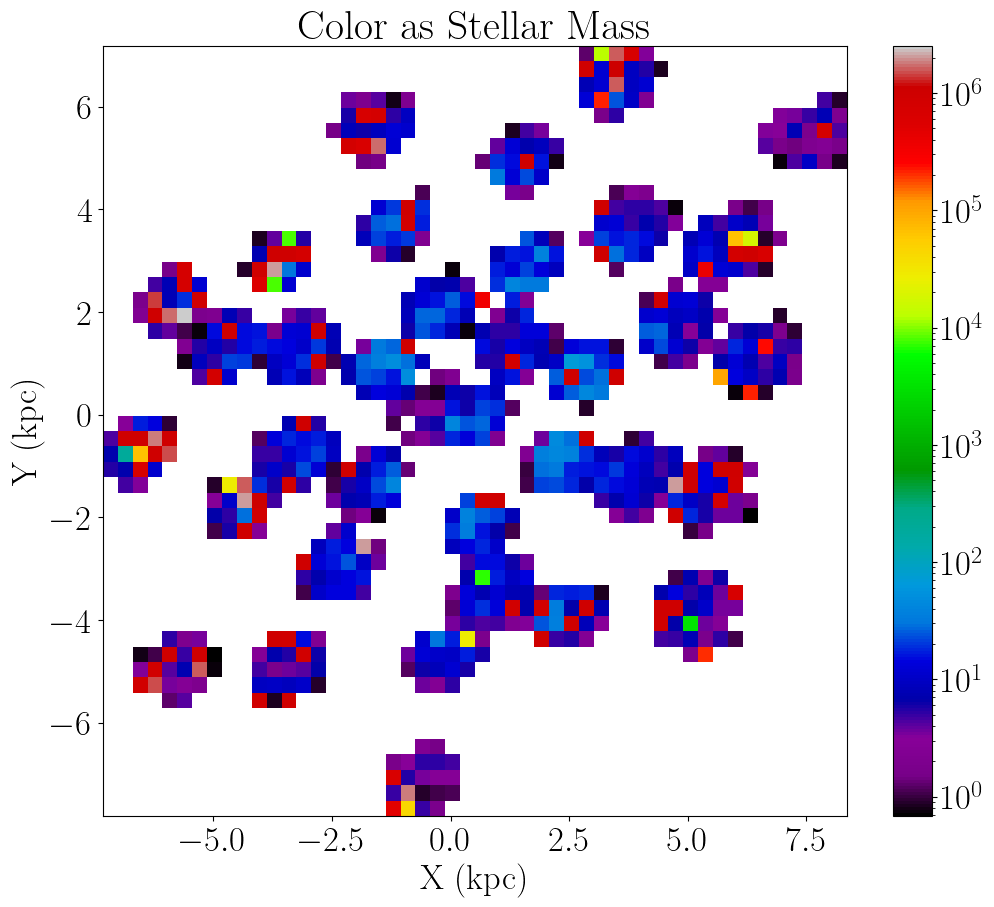

In [614]:
from matplotlib.colors import LogNorm
plt.figure(figsize=[12,10])
raw_mass, = np.where((agetab['MASS']!=999999.0)&(np.isfinite(agetab['MASS'])==True))
ret = binned_statistic_2d(lmcx[raw_mass],lmcy[raw_mass],agetab['MASS'][raw_mass],'sum',bins=50)
im = plt.imshow(ret.statistic.T, origin='lower',
                extent=[ret.x_edge[0],ret.x_edge[-1],ret.y_edge[0],ret.y_edge[-1]],
                aspect='auto',interpolation='nearest',cmap='nipy_spectral',norm=LogNorm())
plt.colorbar()

plt.title(r'Color as Stellar Mass')
plt.xlabel(r'X (kpc)')
plt.ylabel(r'Y (kpc)')
# plt.savefig('lmc_map_ag.png',dpi=300,bbox_inches='tight')
plt.show()

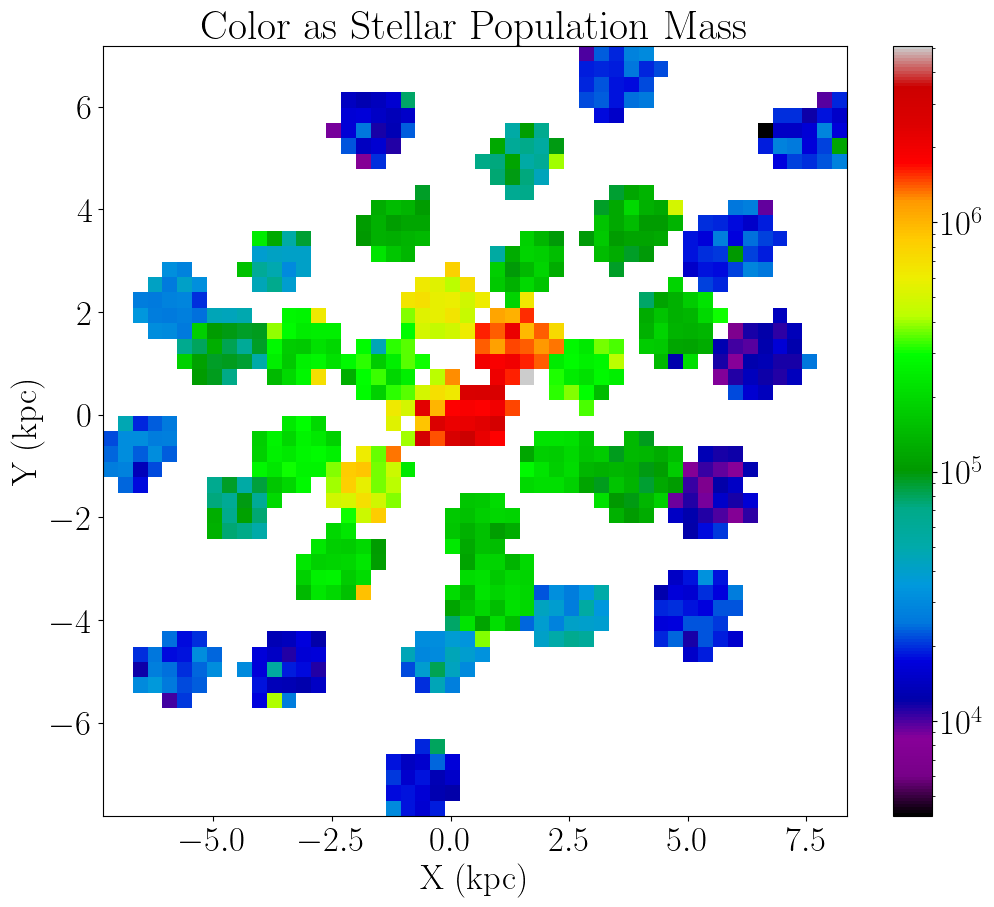

In [615]:
from matplotlib.colors import LogNorm
plt.figure(figsize=[12,10])
unmasked_mass, = np.where(select_results['stellarmass']!=select_results['stellarmass'][6])
ret = binned_statistic_2d(lmcx[unmasked_mass],lmcy[unmasked_mass],select_results['stellarmass'][unmasked_mass],
                          'median',bins=50)
im = plt.imshow(ret.statistic.T, origin='lower',
                extent=[ret.x_edge[0],ret.x_edge[-1],ret.y_edge[0],ret.y_edge[-1]],
                aspect='auto',interpolation='nearest',cmap='nipy_spectral',norm=LogNorm())
plt.colorbar()

plt.title(r'Color as Stellar Population Mass')
plt.xlabel(r'X (kpc)')
plt.ylabel(r'Y (kpc)')
# plt.savefig('lmc_map_ag.png',dpi=300,bbox_inches='tight')
plt.show()

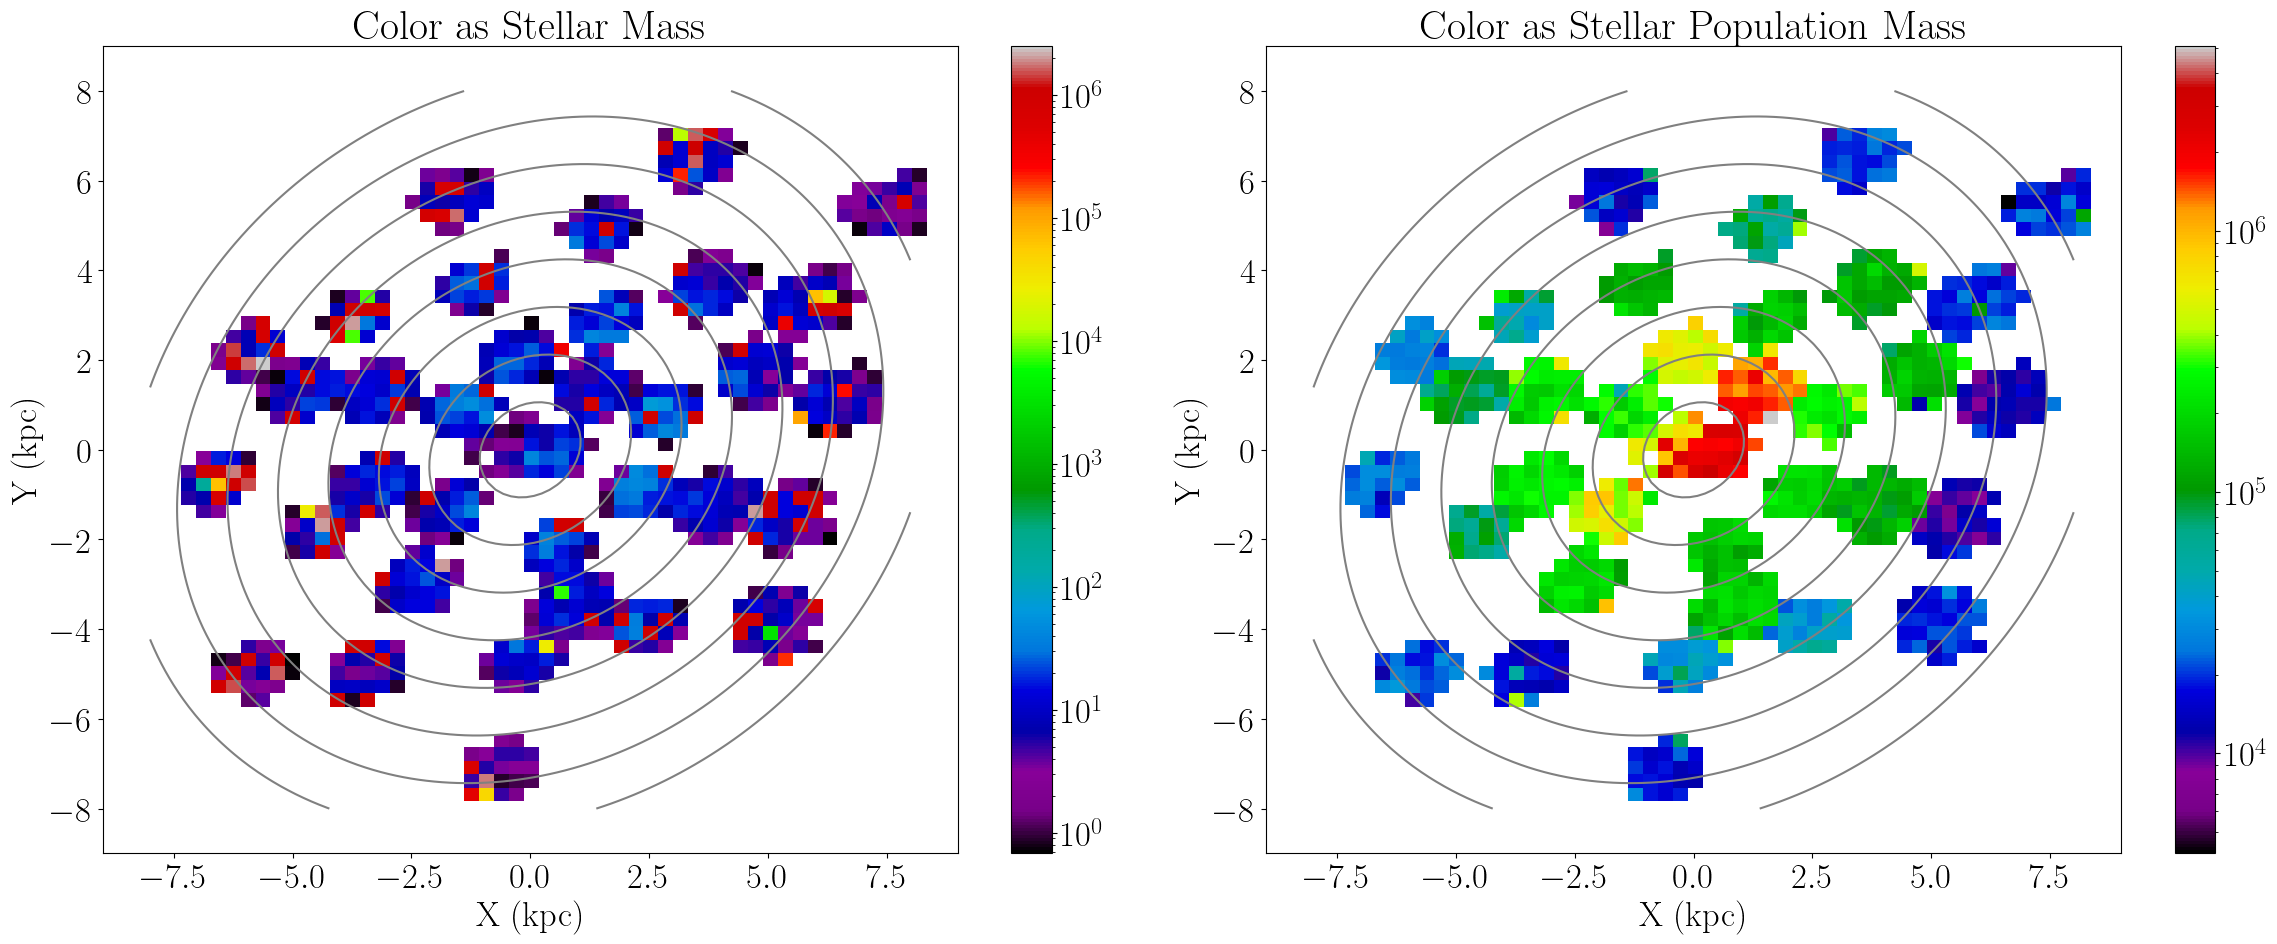

In [616]:
plt.figure(figsize=[24,10])

plt.subplot(121)
xx,yy = np.meshgrid(np.linspace(-8,8,100),np.linspace(-8,8,100))
CS = plt.contour(xx,yy,elliptical_radius(xx,yy),levels=[1,2,3,4,5,6,7,8],colors='grey')

raw_mass, = np.where((agetab['MASS']!=999999.0)&(np.isfinite(agetab['MASS'])==True))
ret = binned_statistic_2d(lmcx[raw_mass],lmcy[raw_mass],agetab['MASS'][raw_mass],'sum',bins=50)
im = plt.imshow(ret.statistic.T, origin='lower',
                extent=[ret.x_edge[0],ret.x_edge[-1],ret.y_edge[0],ret.y_edge[-1]],
                aspect='auto',interpolation='nearest',cmap='nipy_spectral',norm=LogNorm())
plt.colorbar()

plt.xlim(-9,9)
plt.ylim(-9,9)

plt.title(r'Color as Stellar Mass')
plt.xlabel(r'X (kpc)')
plt.ylabel(r'Y (kpc)')
# plt.savefig('lmc_map_ag.png',dpi=300,bbox_inches='tight')

plt.subplot(122)
xx,yy = np.meshgrid(np.linspace(-8,8,100),np.linspace(-8,8,100))
CS = plt.contour(xx,yy,elliptical_radius(xx,yy),levels=[1,2,3,4,5,6,7,8],colors='grey')
unmasked_mass, = np.where(select_results['stellarmass']!=select_results['stellarmass'][6])
ret = binned_statistic_2d(lmcx[unmasked_mass],lmcy[unmasked_mass],select_results['stellarmass'][unmasked_mass],
                          'median',bins=50)
im = plt.imshow(ret.statistic.T, origin='lower',
                extent=[ret.x_edge[0],ret.x_edge[-1],ret.y_edge[0],ret.y_edge[-1]],
                aspect='auto',interpolation='nearest',cmap='nipy_spectral',norm=LogNorm())
plt.colorbar()

plt.xlim(-9,9)
plt.ylim(-9,9)

plt.title(r'Color as Stellar Population Mass')
plt.xlabel(r'X (kpc)')
plt.ylabel(r'Y (kpc)')

plt.tight_layout()
plt.savefig('lmc_mass_map.png',bbox_inches='tight')
plt.show()

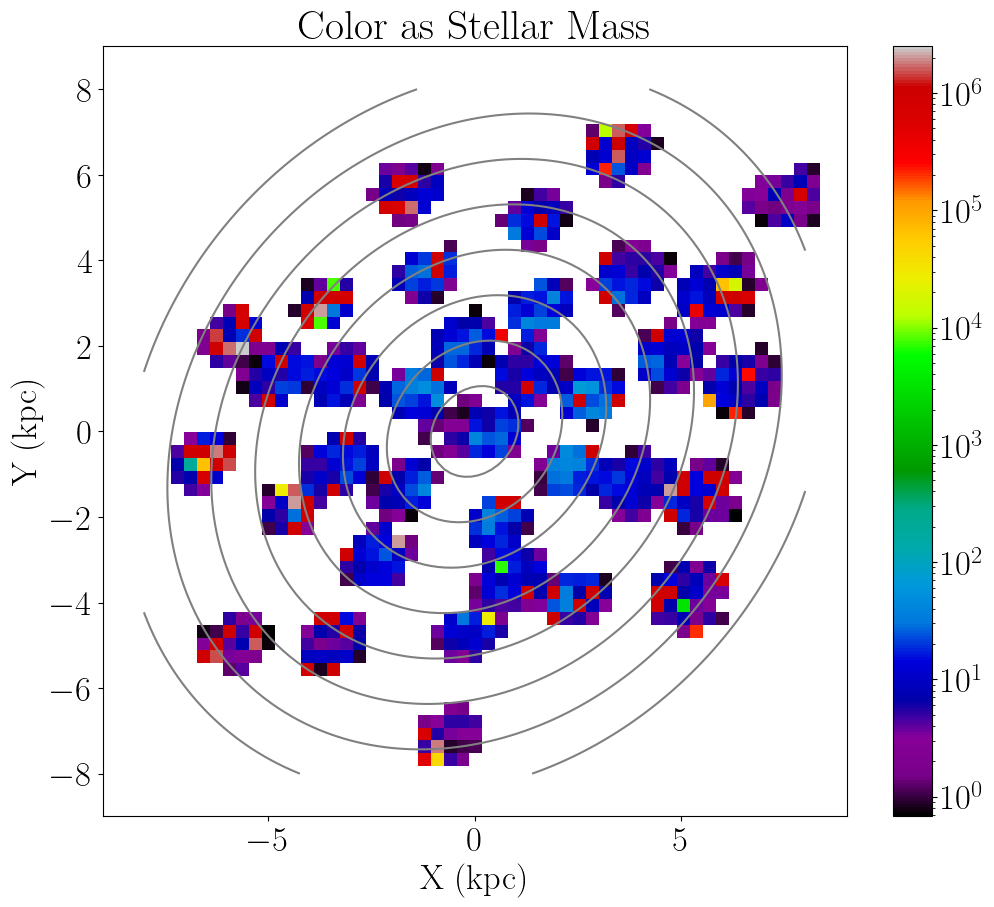

In [617]:
plt.figure(figsize=[12,10])
xx,yy = np.meshgrid(np.linspace(-8,8,100),np.linspace(-8,8,100))
CS = plt.contour(xx,yy,elliptical_radius(xx,yy),levels=[1,2,3,4,5,6,7,8],colors='grey')

raw_mass, = np.where((agetab['MASS']!=999999.0)&(np.isfinite(agetab['MASS'])==True))
ret = binned_statistic_2d(lmcx[raw_mass],lmcy[raw_mass],agetab['MASS'][raw_mass],'sum',bins=50)
im = plt.imshow(ret.statistic.T, origin='lower',
                extent=[ret.x_edge[0],ret.x_edge[-1],ret.y_edge[0],ret.y_edge[-1]],
                aspect='auto',interpolation='nearest',cmap='nipy_spectral',norm=LogNorm())
plt.colorbar()

plt.xlim(-9,9)
plt.ylim(-9,9)

plt.title(r'Color as Stellar Mass')
plt.xlabel(r'X (kpc)')
plt.ylabel(r'Y (kpc)')
plt.savefig('lmc_mass_map_raw.png')
plt.show()

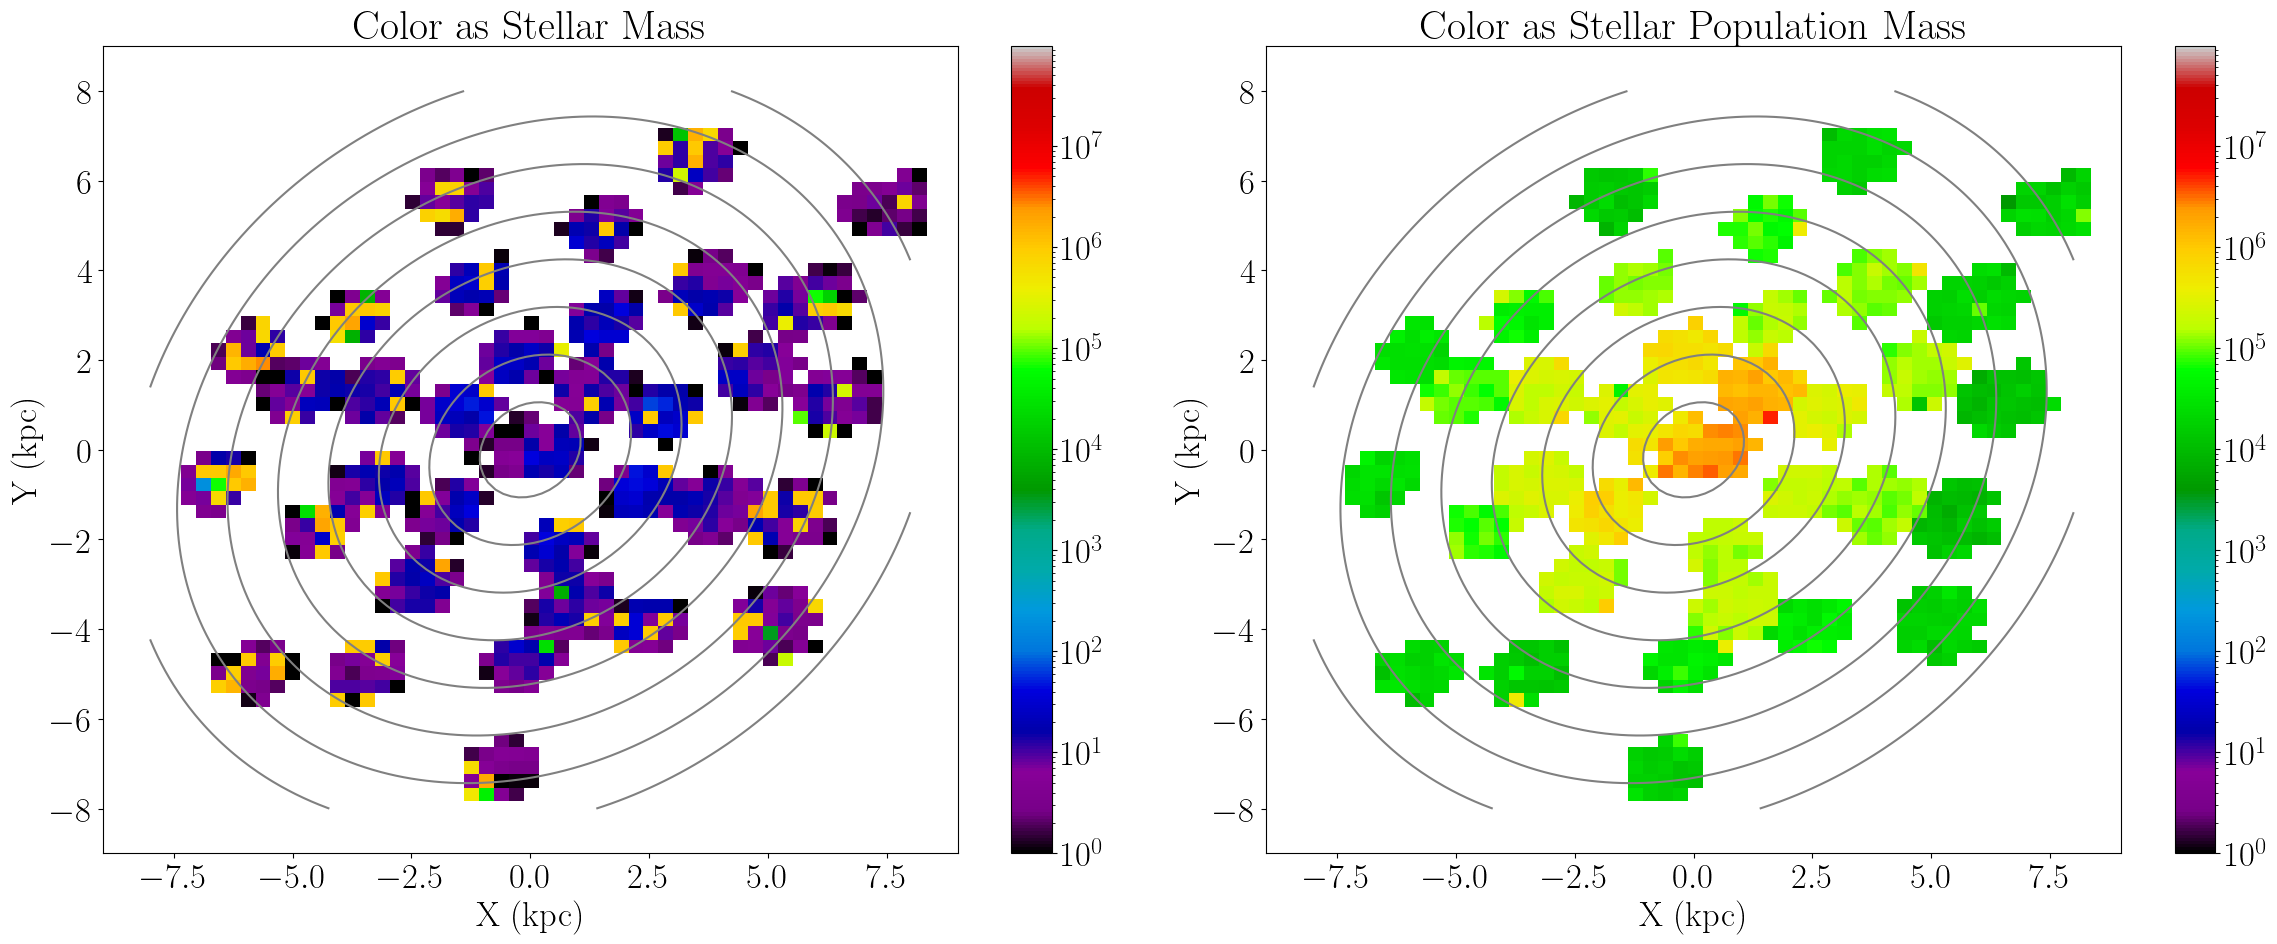

In [618]:
plt.figure(figsize=[24,10])

plt.subplot(121)
xx,yy = np.meshgrid(np.linspace(-8,8,100),np.linspace(-8,8,100))
CS = plt.contour(xx,yy,elliptical_radius(xx,yy),levels=[1,2,3,4,5,6,7,8],colors='grey')

raw_mass, = np.where((agetab['MASS']!=999999.0)&(np.isfinite(agetab['MASS'])==True))
ret = binned_statistic_2d(lmcx[raw_mass],lmcy[raw_mass],agetab['MASS'][raw_mass],'sum',bins=50)
im = plt.imshow(ret.statistic.T, origin='lower',
                extent=[ret.x_edge[0],ret.x_edge[-1],ret.y_edge[0],ret.y_edge[-1]],
                aspect='auto',interpolation='nearest',cmap='nipy_spectral',
                norm=LogNorm(vmin=1,vmax=max(select_results['stellarmass'][unmasked_mass])))
plt.colorbar()

plt.xlim(-9,9)
plt.ylim(-9,9)

plt.title(r'Color as Stellar Mass')
plt.xlabel(r'X (kpc)')
plt.ylabel(r'Y (kpc)')
# plt.savefig('lmc_map_ag.png',dpi=300,bbox_inches='tight')

plt.subplot(122)
xx,yy = np.meshgrid(np.linspace(-8,8,100),np.linspace(-8,8,100))
CS = plt.contour(xx,yy,elliptical_radius(xx,yy),levels=[1,2,3,4,5,6,7,8],colors='grey')
unmasked_mass, = np.where(select_results['stellarmass']!=select_results['stellarmass'][6])
ret = binned_statistic_2d(lmcx[unmasked_mass],lmcy[unmasked_mass],select_results['stellarmass'][unmasked_mass],
                          'median',bins=50)
im = plt.imshow(ret.statistic.T, origin='lower',
                extent=[ret.x_edge[0],ret.x_edge[-1],ret.y_edge[0],ret.y_edge[-1]],
                aspect='auto',interpolation='nearest',cmap='nipy_spectral',
                norm=LogNorm(vmin=1,vmax=max(select_results['stellarmass'][unmasked_mass])))
plt.colorbar()

plt.xlim(-9,9)
plt.ylim(-9,9)

plt.title(r'Color as Stellar Population Mass')
plt.xlabel(r'X (kpc)')
plt.ylabel(r'Y (kpc)')

plt.tight_layout()
# plt.savefig('lmc_mass_map.png',bbox_inches='tight')
plt.show()

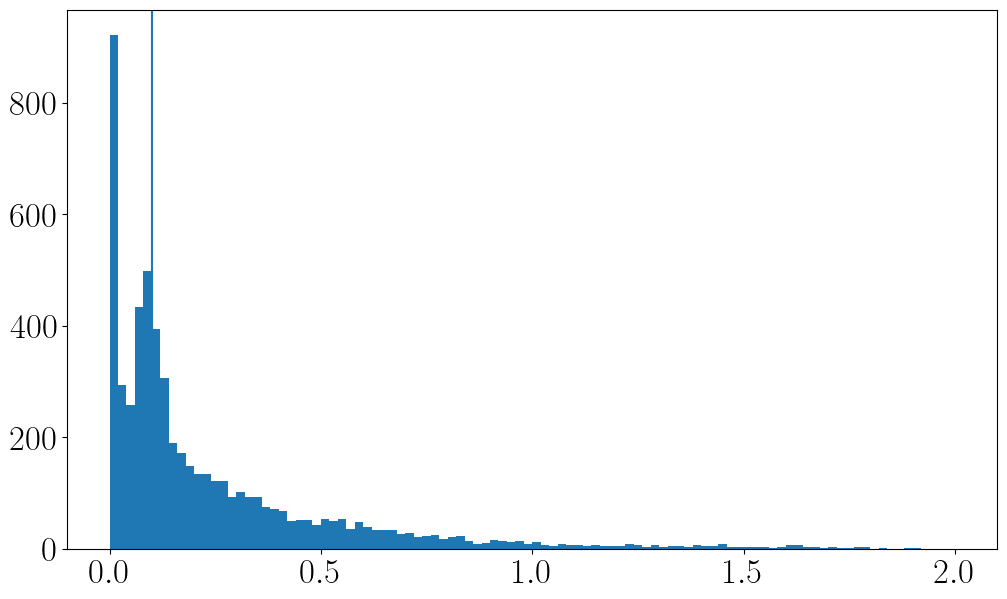

In [619]:
plt.figure(figsize=[12,7])
plt.hist(agetab['AGE_ERR'],range=(0,2),bins=100)
plt.axvline(0.1)

In [620]:
def bloop(j_k):
    '''
    Function used to cut the bloop using apparent 2Mass colors. The return is the K on the boundary as a function
    of J - K color.
    
    Inputs:
    ------
    j_k: J - K 2Mass color
    
    Outputs:
    -------
    k: apparent 2Mass K of bloop cut 
    '''
    
    j_k = np.asarray(j_k)
    
    bloop_bound = np.ones(len(j_k))
    
    for i in range(len(j_k)):
        if j_k[i] <= 0.85:
            bloop_bound[i] = 12.75
#             return 12.75 #k
        else:
            bloop_bound[i] = -4.25*j_k[i] + 16.36
#             return -4.25*j_k + 16.36
        
    return bloop_bound


bloop_cut, = np.where(lmcdr17['K']>bloop(lmcdr17['J']-lmcdr17['K'])) 

bloop_only = np.where(lmcdr17['K']<bloop(lmcdr17['J']-lmcdr17['K']))

In [621]:
lmcx

array([1.1593762 , 1.12119554, 1.11648163, ..., 4.33501294, 4.29291847,
       4.35752281])

  0%|          | 0/5828 [00:00<?, ?it/s]

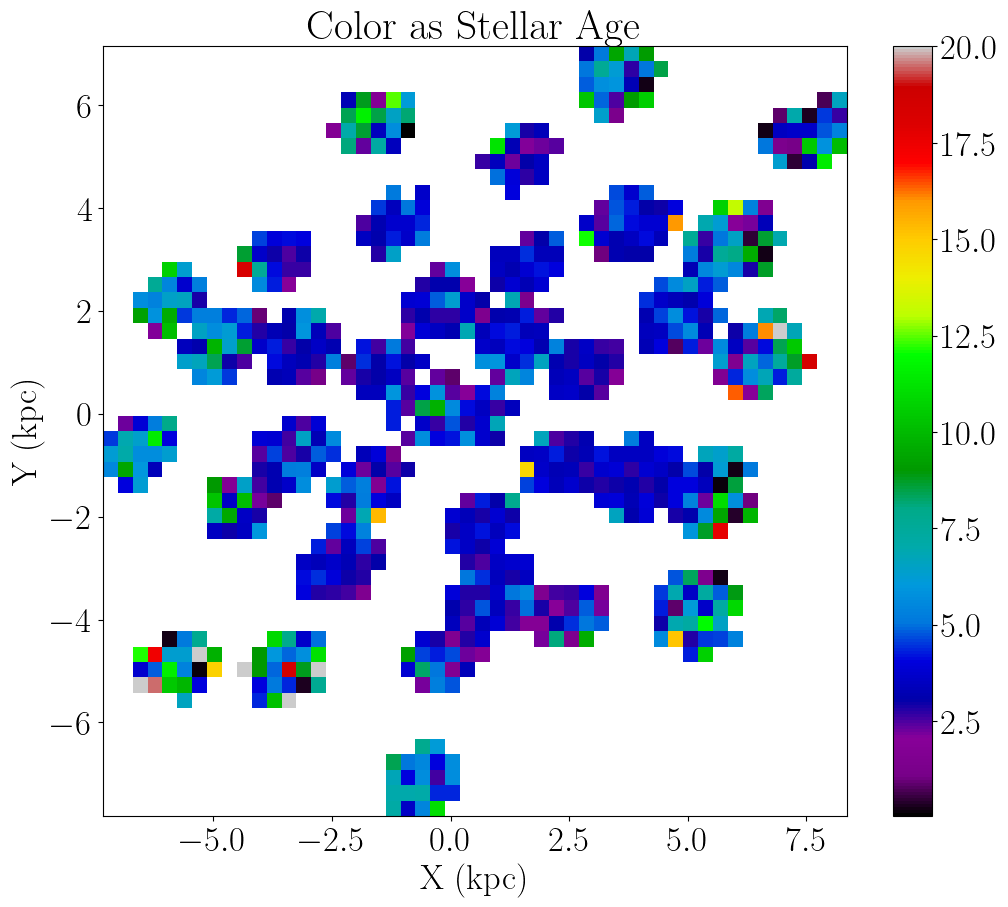

In [622]:
new_num_nobloop = 1/(agetab['DELTA_INT_IMF'][bloop_cut]*select_results['stellarmass'][bloop_cut])

age_num_norm2_nobloop = np.array([])
num_norm2_nobloop_x = np.array([])
num_norm2_nobloop_y = np.array([])

unmasked_mass_nobloop, = np.where(np.isfinite(new_num_nobloop)==True) 

for i in tqdm(range(len(agetab[unmasked_mass_nobloop]))):
    age_num_norm2_nobloop = np.append(age_num_norm2_nobloop,(agetab['AGE'][bloop_cut][unmasked_mass_nobloop][i]*np.ones(int(np.ceil(new_num_nobloop[unmasked_mass_nobloop][i])))).tolist())
    num_norm2_nobloop_x = np.append(num_norm2_nobloop_x,(lmcx[bloop_cut][unmasked_mass_nobloop][i]*np.ones(int(np.ceil(new_num_nobloop[unmasked_mass_nobloop][i])))).tolist())
    num_norm2_nobloop_y = np.append(num_norm2_nobloop_y,(lmcy[bloop_cut][unmasked_mass_nobloop][i]*np.ones(int(np.ceil(new_num_nobloop[unmasked_mass_nobloop][i])))).tolist())
    
plt.figure(figsize=[12,10])
ret = binned_statistic_2d(num_norm2_nobloop_x,num_norm2_nobloop_y,age_num_norm2_nobloop,'median',bins=50)
im = plt.imshow(ret.statistic.T, origin='lower',extent=[ret.x_edge[0],ret.x_edge[-1],ret.y_edge[0],ret.y_edge[-1]],
                aspect='auto',interpolation='nearest',cmap='nipy_spectral',vmax=20)
plt.colorbar()

plt.title(r'Color as Stellar Age')
plt.xlabel(r'X (kpc)')
plt.ylabel(r'Y (kpc)')
# plt.savefig('lmc_map_ag.png',dpi=300,bbox_inches='tight')
plt.show()

In [623]:
# stellar mass wgt feh by fld
# AMR

In [624]:
fld_wgt_avg = np.ones(len(np.unique(lmcdr17['FIELD'][bloop_cut])))
fld_disp = np.ones(len(np.unique(lmcdr17['FIELD'][bloop_cut])))

for i in range(len(np.unique(lmcdr17['FIELD'][bloop_cut]))):
    
    # fld, = np.where((lmcdr17[bloop_cut]['FIELD']==np.unique(lmcdr17['FIELD'][bloop_cut])[i])&(agetab['AGE'][bloop_cut]!=999999.0))
    
    fld, = np.where((lmcdr17['FIELD']==np.unique(lmcdr17['FIELD'])[i])&(agetab['AGE']<=20.0))
    
    fld_wgt_avg[i] = np.dot(agetab['AGE'][fld],select_results[fld]['stellarmass'])/np.sum(select_results[fld]['stellarmass'])
    fld_disp[i] = mad(np.multiply(agetab['AGE'][fld],select_results[fld]['stellarmass'])/np.sum(select_results[fld]['stellarmass']))
    #np.dot(agetab['AGE'][fld],select_results[fld]['stellarmass'])/np.sum(select_results[fld]['stellarmass'])
    
#     corr_fld_ages = np.array([])
    
#     for j in range(len(fld)):
#         corr_fld_ages = np.append(corr_fld_ages,(agetab['AGE'][bloop_cut][fld][i]*np.ones(int(np.ceil(new_num_nobloop[fld][i])))).tolist())
    
#     corrected_fld_medians[i] = np.nanmedian(corr_fld_ages)

In [625]:
fld_wgt_avg

array([ 3.93844168,  6.62035394, 12.92455119,  5.13586171,  9.63865174,
        3.69774096,  4.63327213,  6.56710959,  6.82262438,  7.39041028,
        4.59924113,  4.88839552,  7.49271567,  4.38039647,  5.66142534,
        4.90777779, 10.2484048 ,  6.47962571,  8.48485995,  6.85946151,
        5.140439  ,  6.47672555,  7.16983953,  5.11940211,  6.27790531,
        3.92009584,  6.43393039, 10.6558781 ,  4.12640786,  7.94184864,
        4.89874514,  4.6406608 ,  5.52458058,  6.65639788,  5.46445188,
        5.49412808])

In [626]:
fld_disp

array([0.05131076, 0.02272157, 0.00715773, 0.01462442, 0.02148027,
       0.01445609, 0.01679049, 0.01978649, 0.02940647, 0.02277782,
       0.01213665, 0.01647844, 0.02251178, 0.01281013, 0.01223639,
       0.01094656, 0.07543677, 0.05634686, 0.01529202, 0.03829483,
       0.01808363, 0.02139785, 0.01271435, 0.00844906, 0.00748097,
       0.0209786 , 0.01492366, 0.02281386, 0.01142776, 0.02952147,
       0.01030816, 0.01186564, 0.01286371, 0.0216626 , 0.01305429,
       0.01965354])

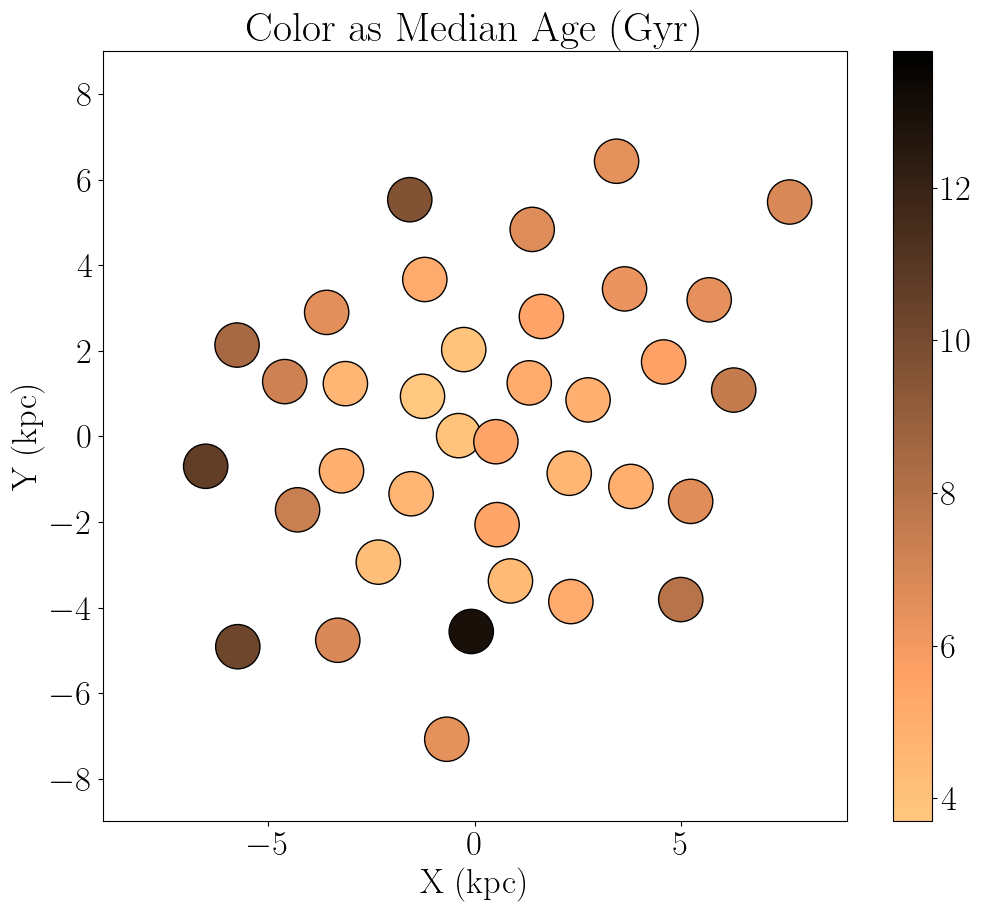

In [627]:
fig, ax = plt.subplots(1,1,figsize=[12,10])
plt.title(r'Color as Median Age (Gyr)')

# set bounds for the plot
ax.set_xlim(-9,9)
ax.set_ylim(-9,9)

# convert 0.8 deg diameter to points and calculate the marker size
r = 49.9*np.tan(np.radians(0.8/2)) #0.8
r_ = ax.transData.transform([r,0])[0] - ax.transData.transform([0,0])[0]
marker_size = np.pi * r_**2

pl = ax.scatter(cen_xy[:,0],cen_xy[:,1],s=marker_size,c=fld_wgt_avg,edgecolors='k',cmap='copper_r',vmax=13.787)
plt.colorbar(pl,ax=ax)

ax.set_xlabel(r'X (kpc)')
ax.set_ylabel(r'Y (kpc)')

# ax.scatter(cen_xy[:,0],cen_xy[:,1],s=marker_size,facecolors='none',edgecolors='k')
plt.show()

#####################################
#### Make ellipses for this plot ####
#####################################

# side by side raw + corrected map


In [628]:
fin, = np.where(np.isfinite(gaiax)==False)
fin

array([], dtype=int64)

/var/folders/rc/1rzbdsbd3pb_0pd6mhcfkh2r0000gn/T/ipykernel_2701/2120698659.py:74: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


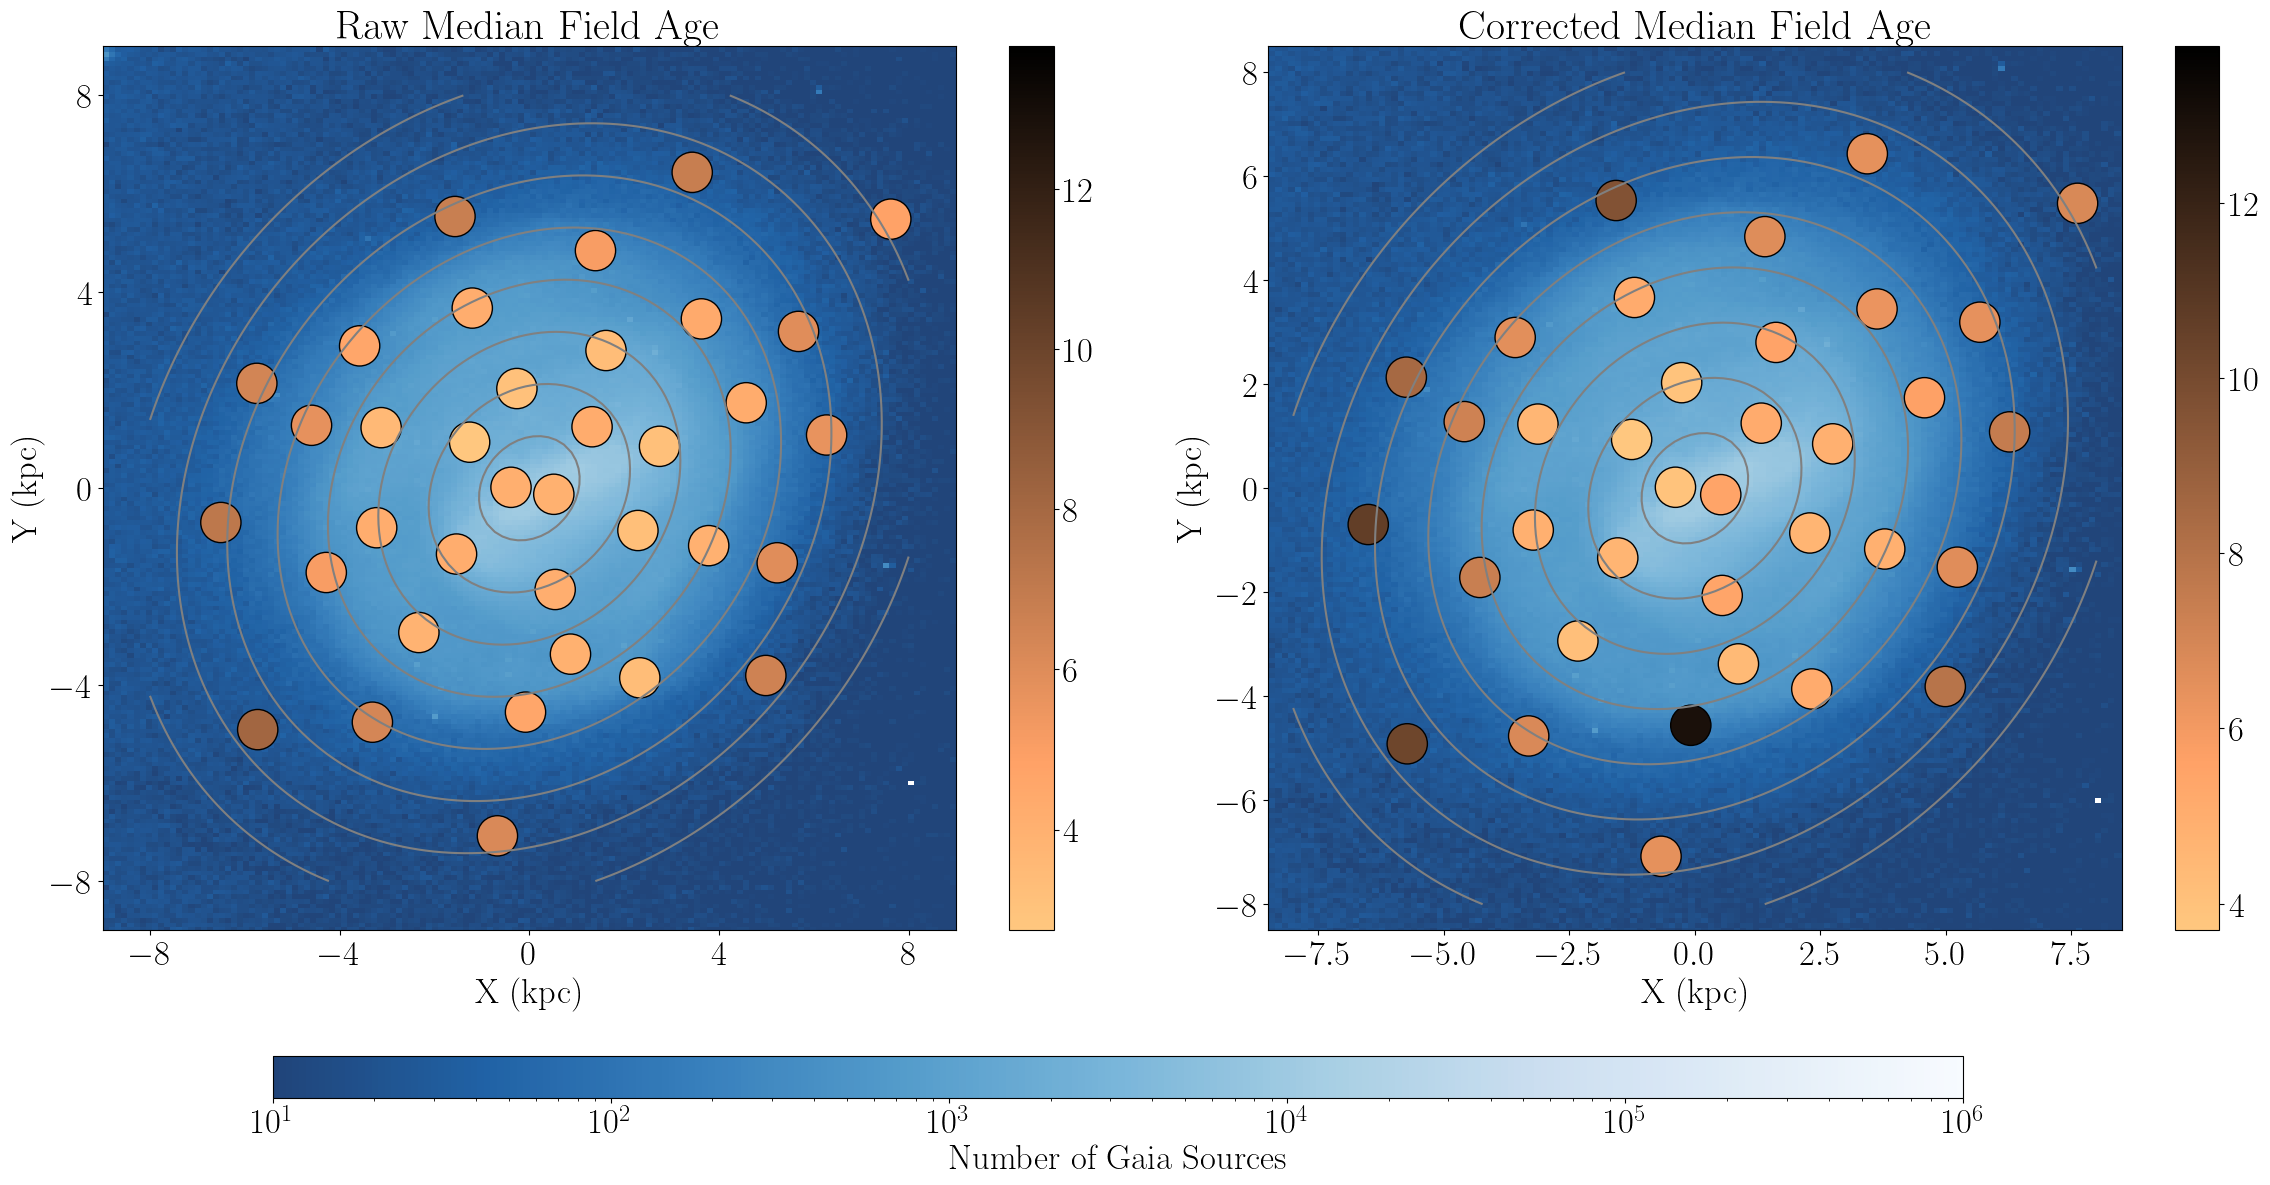

In [629]:
# psi = np.radians(227.24+90.0)
# b_a = 0.839

# clabx = (np.arange(7)+1)*np.sqrt(1/(np.cos(psi)**2+np.sin(psi)**2/b_a))

# locations = []
# for i in range(len(clabx)):
#     locations.append([clabx[i],0.0])

from matplotlib.colors import LogNorm
    
ret = binned_statistic_2d(gaiax,gaiay,gaiax,'count',bins=1000)
ret.statistic[ret.statistic==0] = np.nan

fig, ax = plt.subplots(1,2,figsize=[24,14])

xx,yy = np.meshgrid(np.linspace(-8,8,100),np.linspace(-8,8,100))
CS = ax[0].contour(xx,yy,elliptical_radius(xx,yy),levels=[1,2,3,4,5,6,7,8],colors='grey')
#ax[0].clabel(CS,colors='k',fontsize=25,manual=locations)

# fmt = {}
# strs = ['1', '2', '3', '4', '5', '6', '7']
# for l, s in zip(CS.levels, strs):
#     fmt[l] = s
# ax[0].clabel(CS, CS.levels[::2], inline=True, fmt=fmt, fontsize=10, manual=locations)

CS = ax[1].contour(xx,yy,elliptical_radius(xx,yy),levels=[1,2,3,4,5,6,7,8],colors='grey')
#ax[1].clabel(CS,colors='k',fontsize=25,manual=locations)

# for i in range(len(clabx)):
#     ax[0].text(clabx[i]*(1+0.01),0.0,'{}'.format(i+1))

plt.xlim(-8.5,8.5)
plt.ylim(-8.5,8.5)

# set bounds for the plot
for i in range(1):
    ax[i].set_xlim(-9,9)
    ax[i].set_ylim(-9,9)
    ax[i].set_xlabel(r'X (kpc)')
    ax[i].set_ylabel(r'Y (kpc)')

    ax[i].set_xticks([-8,-4.0,0,4.0,8])
    ax[i].set_yticks([-8,-4.0,0,4.0,8])
    
    

# convert 0.8 deg diameter to points and calculate the marker size
r = 49.9*np.tan(np.radians(0.8/2)) #0.8
r_ = ax[0].transData.transform([r,0])[0] - ax[0].transData.transform([0,0])[0]
marker_size = np.pi * r_**2

ax[0].imshow(ret.statistic.T, origin='lower',
             extent=[ret.x_edge[0],ret.x_edge[-1],ret.y_edge[0],ret.y_edge[-1]],
             aspect='auto',interpolation='nearest',cmap='Blues_r',alpha=0.9,norm=LogNorm(vmin=10**1,vmax=10**6))

im = ax[1].imshow(ret.statistic.T, origin='lower',
             extent=[ret.x_edge[0],ret.x_edge[-1],ret.y_edge[0],ret.y_edge[-1]],
             aspect='auto',interpolation='nearest',cmap='Blues_r',alpha=0.9,norm=LogNorm(vmin=10**1,vmax=10**6))

pl = ax[0].scatter(cen_xy[:,0],cen_xy[:,1],s=marker_size,c=med_fld_age,edgecolors='k',cmap='copper_r',vmax=13.787)
plt.colorbar(pl,ax=ax[0])
pl = ax[1].scatter(cen_xy[:,0],cen_xy[:,1],s=marker_size,c=fld_wgt_avg,edgecolors='k',cmap='copper_r',vmax=13.787)
plt.colorbar(pl,ax=ax[1])

plt.colorbar(im,ax=[ax[0],ax[1]],location='bottom',pad=-0.45,aspect=40,label='Number of Gaia Sources')#orientation='horizontal')

ax[0].set_title(r'Raw Median Field Age')
ax[1].set_title(r'Corrected Median Field Age')

ax[1].set_xlabel(r'X (kpc)')
ax[1].set_ylabel(r'Y (kpc)')

plt.tight_layout()

plt.savefig(r'lmc_median_field_age_map.png',bbox_inches='tight')
plt.show()

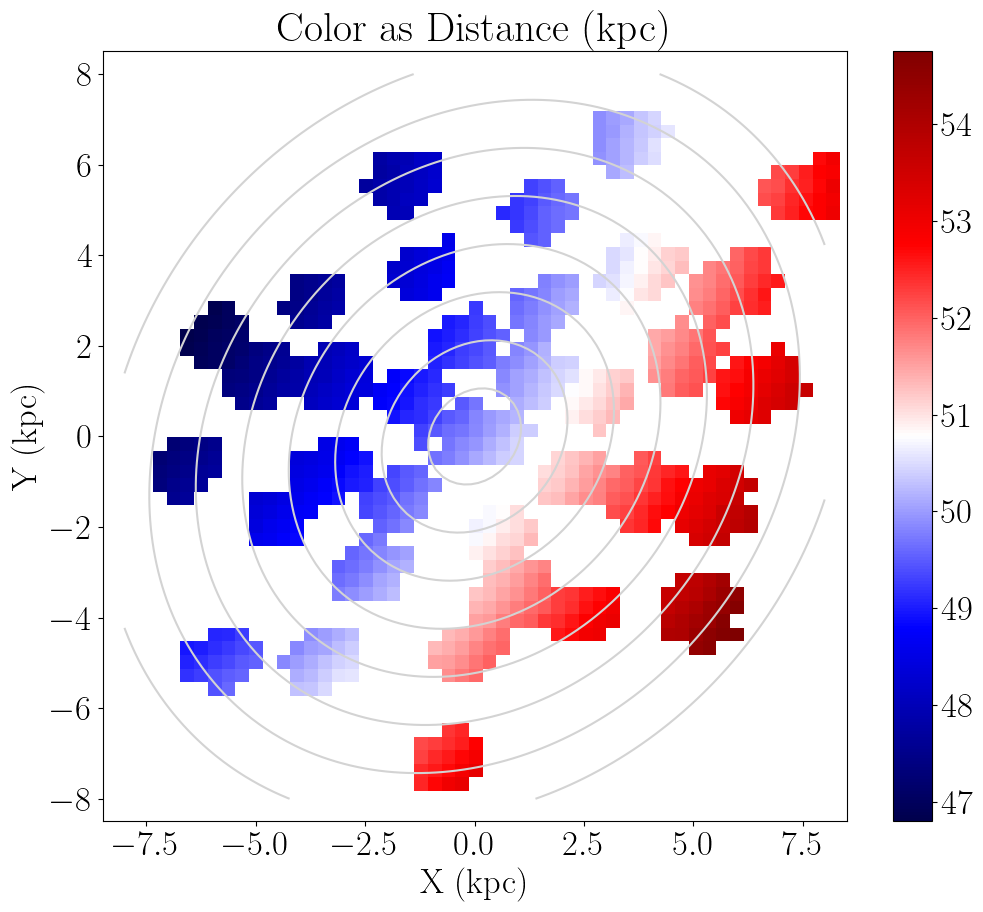

In [630]:
plt.figure(figsize=[12,10])

xx,yy = np.meshgrid(np.linspace(-8,8,100),np.linspace(-8,8,100))
CS = plt.contour(xx,yy,elliptical_radius(xx,yy),levels=[1,2,3,4,5,6,7,8],colors='lightgrey')

ret = binned_statistic_2d(lmcx,lmcy,lmcdis,'median',bins=50)
im = plt.imshow(ret.statistic.T, origin='lower',
                    extent=[ret.x_edge[0],ret.x_edge[-1],ret.y_edge[0],ret.y_edge[-1]],
                    aspect='auto',interpolation='nearest',cmap='seismic')
plt.colorbar()

plt.xlim(-8.5,8.5)
plt.ylim(-8.5,8.5)

plt.title(r'Color as Distance (kpc)')
plt.xlabel(r'X (kpc)')
plt.ylabel(r'Y (kpc)')
plt.savefig('lmc_map_distance.png',dpi=300,bbox_inches='tight')
plt.show()

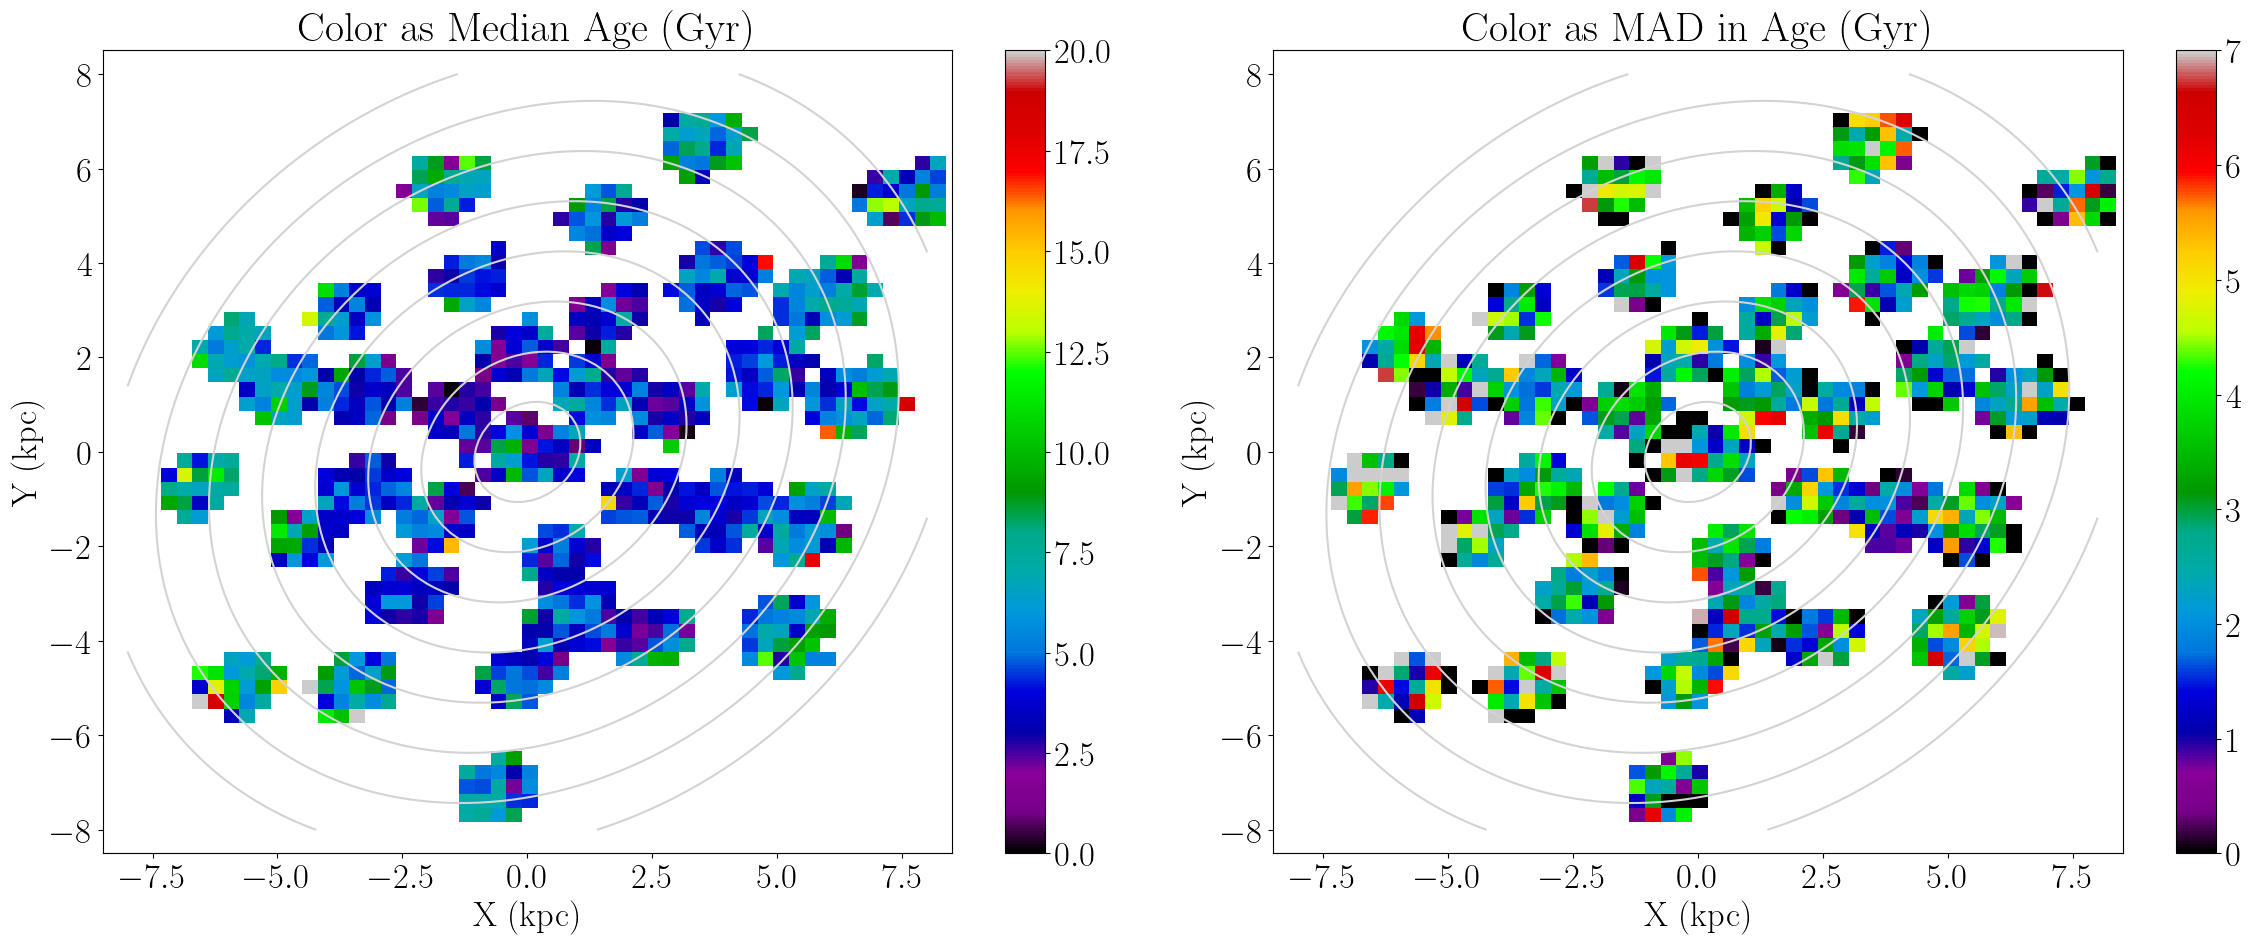

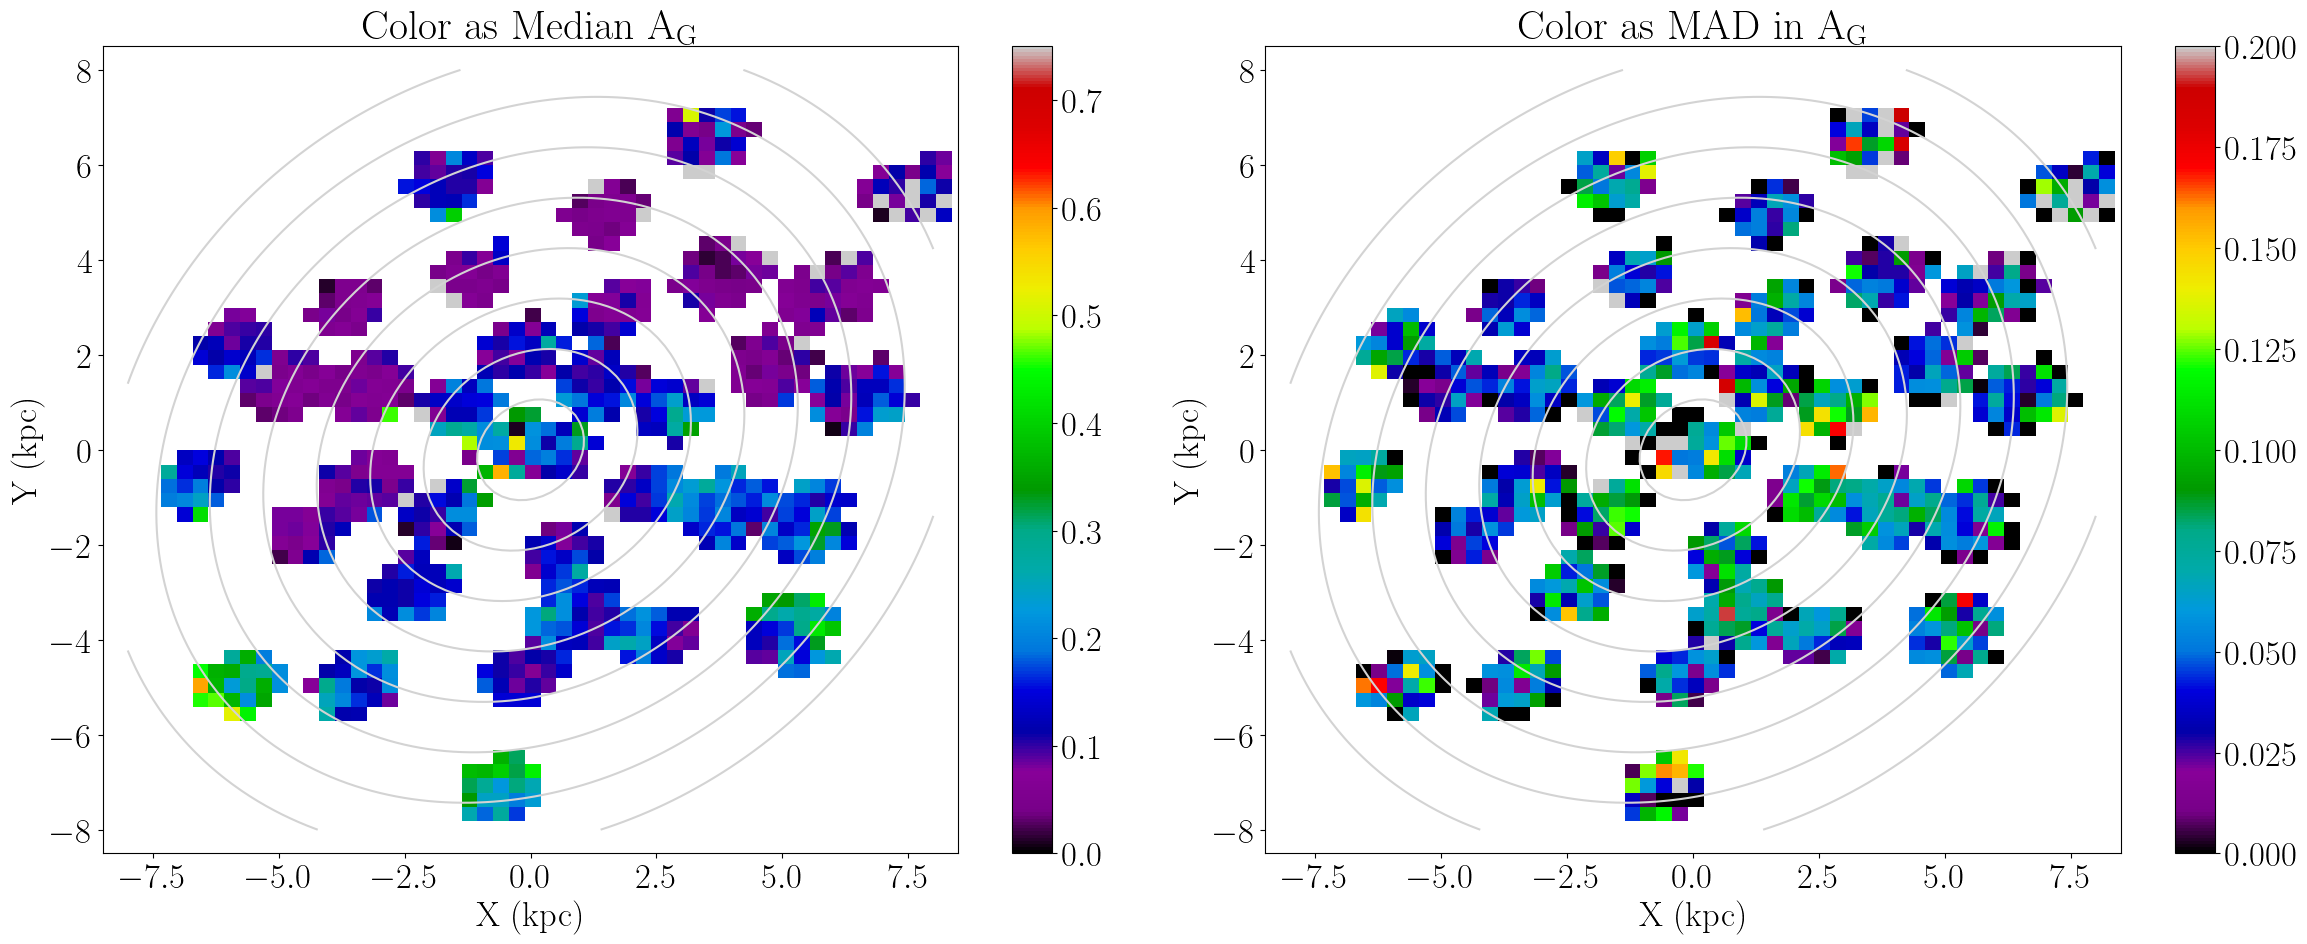

In [631]:
# plt.figure(figsize=[12,10])

# xx,yy = np.meshgrid(np.linspace(-8,8,100),np.linspace(-8,8,100))
# CS = plt.contour(xx,yy,elliptical_radius(xx,yy),levels=[1,2,3,4,5,6,7,8],colors='lightgrey')

# ret = binned_statistic_2d(lmcx,lmcy,agetab['AGE'],'median',bins=50)
# im = plt.imshow(ret.statistic.T, origin='lower',
#                     extent=[ret.x_edge[0],ret.x_edge[-1],ret.y_edge[0],ret.y_edge[-1]],
#                     aspect='auto',interpolation='nearest',cmap='nipy_spectral',vmin=0,vmax=20.)
# plt.colorbar()

# plt.xlim(-8.5,8.5)
# plt.ylim(-8.5,8.5)

# plt.title(r'Color as Median Age (Gyr)')
# plt.xlabel(r'X (kpc)')
# plt.ylabel(r'Y (kpc)')
# plt.savefig('lmc_raw_age_map.png',dpi=300,bbox_inches='tight')
# plt.show()

plt.figure(figsize=[24,10])

xx,yy = np.meshgrid(np.linspace(-8,8,100),np.linspace(-8,8,100))

plt.subplot(121)
CS = plt.contour(xx,yy,elliptical_radius(xx,yy),levels=[1,2,3,4,5,6,7,8],colors='lightgrey')
ret = binned_statistic_2d(lmcx,lmcy,agetab['AGE'],'median',bins=50)
im = plt.imshow(ret.statistic.T, origin='lower',
                    extent=[ret.x_edge[0],ret.x_edge[-1],ret.y_edge[0],ret.y_edge[-1]],
                    aspect='auto',interpolation='nearest',cmap='nipy_spectral',vmin=0,vmax=20.)
plt.colorbar()

plt.xlim(-8.5,8.5)
plt.ylim(-8.5,8.5)

plt.title(r'Color as Median Age (Gyr)')
plt.xlabel(r'X (kpc)')
plt.ylabel(r'Y (kpc)')

plt.subplot(122)
CS = plt.contour(xx,yy,elliptical_radius(xx,yy),levels=[1,2,3,4,5,6,7,8],colors='lightgrey')
ret = binned_statistic_2d(lmcx,lmcy,agetab['AGE'],mad,bins=50)
im = plt.imshow(ret.statistic.T, origin='lower',
                    extent=[ret.x_edge[0],ret.x_edge[-1],ret.y_edge[0],ret.y_edge[-1]],
                    aspect='auto',interpolation='nearest',cmap='nipy_spectral',vmin=0,vmax=7)
plt.colorbar()

plt.xlim(-8.5,8.5)
plt.ylim(-8.5,8.5)

plt.title(r'Color as MAD in Age (Gyr)')
plt.xlabel(r'X (kpc)')
plt.ylabel(r'Y (kpc)')

plt.tight_layout()
plt.savefig('lmc_raw_age_map.png',dpi=300,bbox_inches='tight')
plt.show()

plt.figure(figsize=[24,10])

xx,yy = np.meshgrid(np.linspace(-8,8,100),np.linspace(-8,8,100))

plt.subplot(121)
CS = plt.contour(xx,yy,elliptical_radius(xx,yy),levels=[1,2,3,4,5,6,7,8],colors='lightgrey')
ret = binned_statistic_2d(lmcx,lmcy,agetab['EXT'][:,1],'median',bins=50)
im = plt.imshow(ret.statistic.T, origin='lower',
                    extent=[ret.x_edge[0],ret.x_edge[-1],ret.y_edge[0],ret.y_edge[-1]],
                    aspect='auto',interpolation='nearest',cmap='nipy_spectral',vmin=0,vmax=0.75)
plt.colorbar()

plt.xlim(-8.5,8.5)
plt.ylim(-8.5,8.5)

plt.title(r'Color as Median A$_{\rm G}$')
plt.xlabel(r'X (kpc)')
plt.ylabel(r'Y (kpc)')

plt.subplot(122)
CS = plt.contour(xx,yy,elliptical_radius(xx,yy),levels=[1,2,3,4,5,6,7,8],colors='lightgrey')
ret = binned_statistic_2d(lmcx,lmcy,agetab['EXT'][:,1],mad,bins=50)
im = plt.imshow(ret.statistic.T, origin='lower',
                    extent=[ret.x_edge[0],ret.x_edge[-1],ret.y_edge[0],ret.y_edge[-1]],
                    aspect='auto',interpolation='nearest',cmap='nipy_spectral',vmin=0,vmax=0.2)
plt.colorbar()

plt.xlim(-8.5,8.5)
plt.ylim(-8.5,8.5)

plt.title(r'Color as MAD in A$_{\rm G}$')
plt.xlabel(r'X (kpc)')
plt.ylabel(r'Y (kpc)')

plt.tight_layout()
plt.savefig('lmc_g_ext_map.png',dpi=300,bbox_inches='tight')
plt.show()

In [679]:
# import numpy as np

# def weighted_median(values, weights):
#     ''' compute the weighted median of values list. The 
# weighted median is computed as follows:
#     1- sort both lists (values and weights) based on values.
#     2- select the 0.5 point from the weights and return the corresponding values as results
#     e.g. values = [1, 3, 0] and weights=[0.1, 0.3, 0.6] assuming weights are probabilities.
#     sorted values = [0, 1, 3] and corresponding sorted weights = [0.6,     0.1, 0.3] the 0.5 point on
#     weight corresponds to the first item which is 0. so the weighted     median is 0.'''

#     #convert the weights into probabilities
#     sum_weights = sum(weights)
#     weights = np.array([(w*1.0)/sum_weights for w in weights])
#     #sort values and weights based on values
#     values = np.array(values)
#     sorted_indices = np.argsort(values)
#     values_sorted  = values[sorted_indices]
#     weights_sorted = weights[sorted_indices]
#     #select the median point
#     it = np.nditer(weights_sorted, flags=['f_index'])
#     accumulative_probability = 0
#     median_index = -1
#     while not it.finished:
#         accumulative_probability += it[0]
#         if accumulative_probability > 0.5:
#             median_index = it.index
#             return values_sorted[median_index]
#         elif accumulative_probability == 0.5:
#             median_index = it.index
#             it.iternext()
#             next_median_index = it.index
#             return np.mean(values_sorted[[median_index, next_median_index]])
#         it.iternext()

#     return values_sorted[median_index]
# #compare weighted_median function and np.median
# # print(weighted_median([1, 3, 0, 7], [2,3,3,9]))
# # print(np.median([1,1,0,0,0,3,3,3,7,7,7,7,7,7,7,7,7]))



7
7.0


/var/folders/rc/1rzbdsbd3pb_0pd6mhcfkh2r0000gn/T/ipykernel_2701/3241788130.py:39: RuntimeWarning: invalid value encountered in true_divide
  im = plt.imshow(age_mass_wgt.statistic.T/mass_wgt.statistic.T, origin='lower',


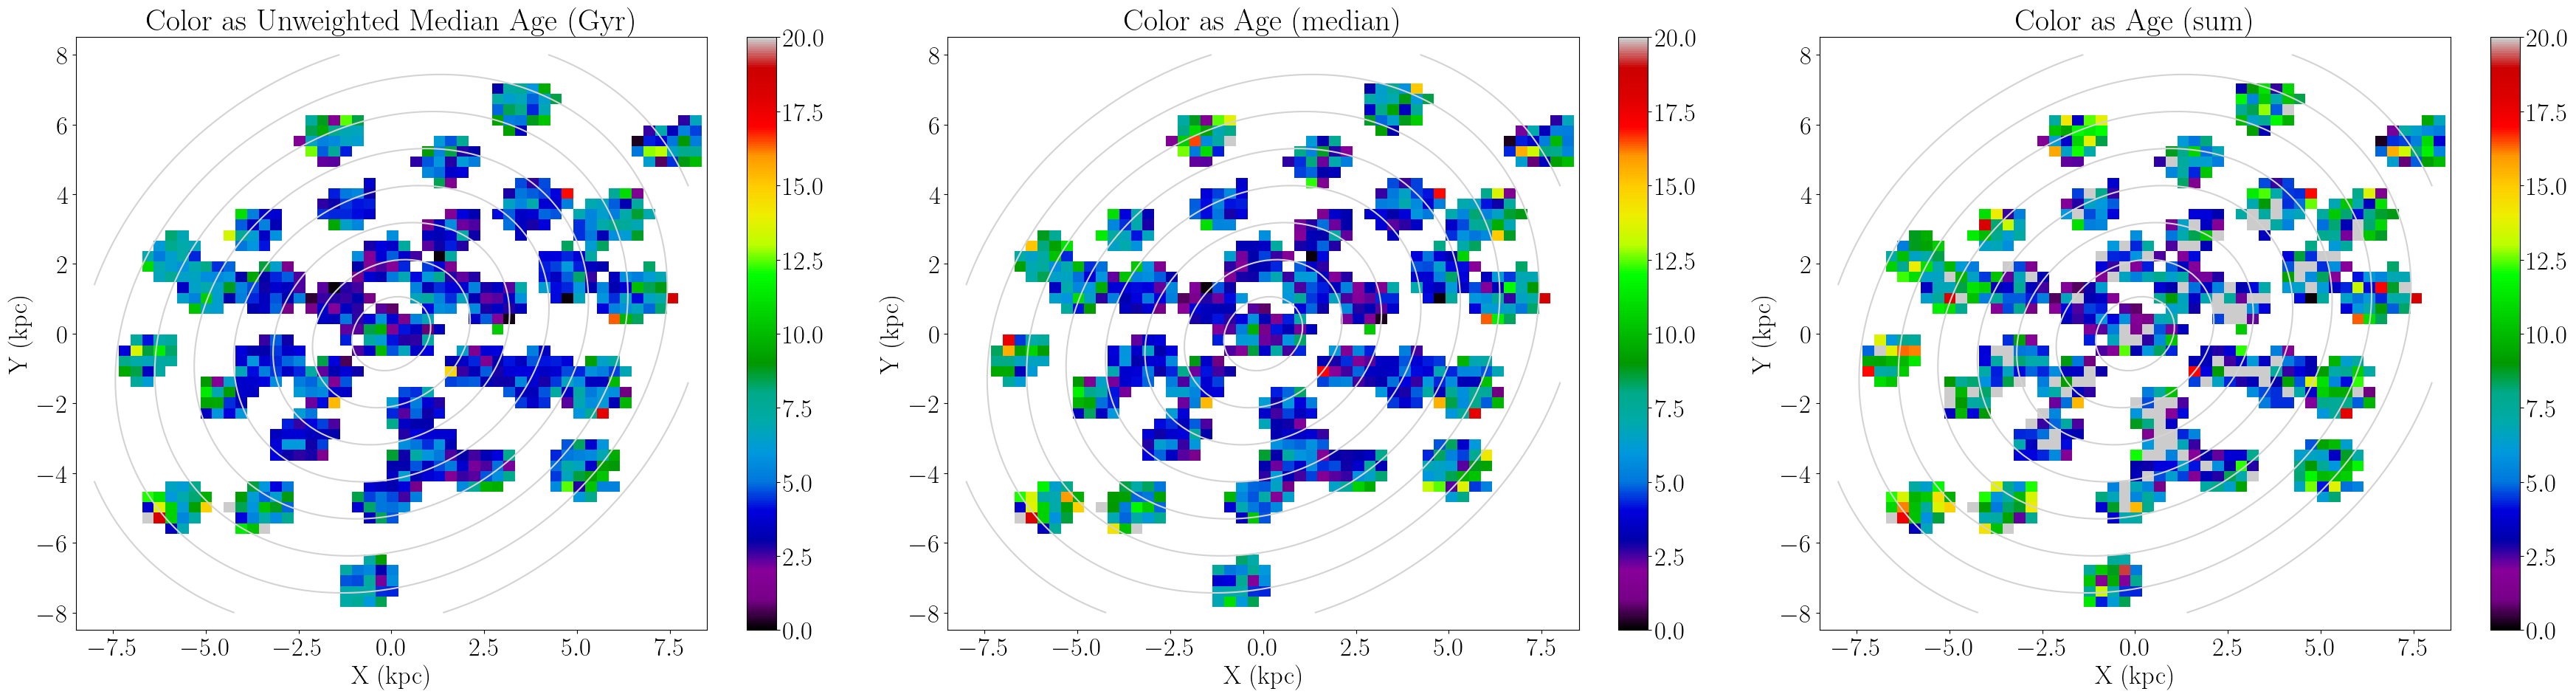

In [688]:
plt.figure(figsize=[36,10])
plt.subplot(131)
CS = plt.contour(xx,yy,elliptical_radius(xx,yy),levels=[1,2,3,4,5,6,7,8],colors='lightgrey')
ret = binned_statistic_2d(lmcx,lmcy,agetab['AGE'],'median',bins=50)
im = plt.imshow(ret.statistic.T, origin='lower',
                    extent=[ret.x_edge[0],ret.x_edge[-1],ret.y_edge[0],ret.y_edge[-1]],
                    aspect='auto',interpolation='nearest',cmap='nipy_spectral',vmin=0,vmax=20.)
plt.colorbar()

plt.xlim(-8.5,8.5)
plt.ylim(-8.5,8.5)

plt.title(r'Color as Unweighted Median Age (Gyr)')
plt.xlabel(r'X (kpc)')
plt.ylabel(r'Y (kpc)')

plt.subplot(132)
age_mass_wgt = binned_statistic_2d(lmcx, lmcy, np.multiply(agetab['AGE'],select_results['stellarmass']),'median',bins=50)
mass_wgt = binned_statistic_2d(lmcx, lmcy, select_results['stellarmass'],'median',bins=50)

CS = plt.contour(xx,yy,elliptical_radius(xx,yy),levels=[1,2,3,4,5,6,7,8],colors='lightgrey')
im = plt.imshow(age_mass_wgt.statistic.T/mass_wgt.statistic.T, origin='lower',
                    extent=[age_wgt.x_edge[0],age_wgt.x_edge[-1],age_wgt.y_edge[0],age_wgt.y_edge[-1]],
                    aspect='auto',interpolation='nearest',cmap='nipy_spectral',vmin=0,vmax=20)
plt.colorbar()

plt.xlim(-8.5,8.5)
plt.ylim(-8.5,8.5)

plt.title(r'Color as Age (median)')
plt.xlabel(r'X (kpc)')
plt.ylabel(r'Y (kpc)')

plt.subplot(133)
age_mass_wgt = binned_statistic_2d(lmcx, lmcy, np.multiply(agetab['AGE'],select_results['stellarmass']),'sum',bins=50)
mass_wgt = binned_statistic_2d(lmcx, lmcy, select_results['stellarmass'],'sum',bins=50)

CS = plt.contour(xx,yy,elliptical_radius(xx,yy),levels=[1,2,3,4,5,6,7,8],colors='lightgrey')
im = plt.imshow(age_mass_wgt.statistic.T/mass_wgt.statistic.T, origin='lower',
                    extent=[age_wgt.x_edge[0],age_wgt.x_edge[-1],age_wgt.y_edge[0],age_wgt.y_edge[-1]],
                    aspect='auto',interpolation='nearest',cmap='nipy_spectral',vmin=0,vmax=20)
plt.colorbar()

plt.xlim(-8.5,8.5)
plt.ylim(-8.5,8.5)

plt.title(r'Color as Age (sum)')
plt.xlabel(r'X (kpc)')
plt.ylabel(r'Y (kpc)')

plt.tight_layout()

In [641]:
# import numpy as np
# import matplotlib.pyplot as plt

# N = 1000
# x = np.random.uniform(0, 10, N)
# y = np.random.uniform(0, 10, N)
# z = np.cos(x) * np.sin(y)

# counts, xbins, ybins = np.histogram2d(lmcx, lmcy, weights=np.multiply(agetab['AGE'],select_results['stellarmass']),
#                                       bins=50)#, bins=(30, 20))
# sums = binned_statistic_2d(lmcx, lmcy, select_results['stellarmass'], 'median', bins=(xbins, ybins))

# fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(15, 4))
# m1 = ax1.pcolormesh(ybins, xbins, counts, cmap='coolwarm')
# plt.colorbar(m1, ax=ax1)
# ax1.set_title('counts')
# m2 = ax2.pcolormesh(ybins, xbins, sums, cmap='coolwarm')
# plt.colorbar(m2, ax=ax2)
# ax2.set_title('sums')
# with np.errstate(divide='ignore', invalid='ignore'):  # suppress possible divide-by-zero warnings
#     m3 = ax3.pcolormesh(ybins, xbins, sums.statistic / counts, cmap='nipy_spectral', vmin=0, vmax=20)
# plt.colorbar(m3, ax=ax3)
# ax3.set_title('mean values')
# plt.tight_layout()
# plt.show()

<Column name='stellarmassperstar_agemetal' dtype='float64' length=6130>
 43866.97373616077
 76162.63663020439
 55942.67729254205
 107352.9167548668
234959.38166208545
138326.06191548647
 51629.85262583322
  141364.907602101
 83252.97934143557
               ...
 8900.402095855341
 5786.704147154423
 75910.41124582739
17339.830155136635
11206.626849980188
 4096.095649728482
14635.274843628436
 10554.17994380206

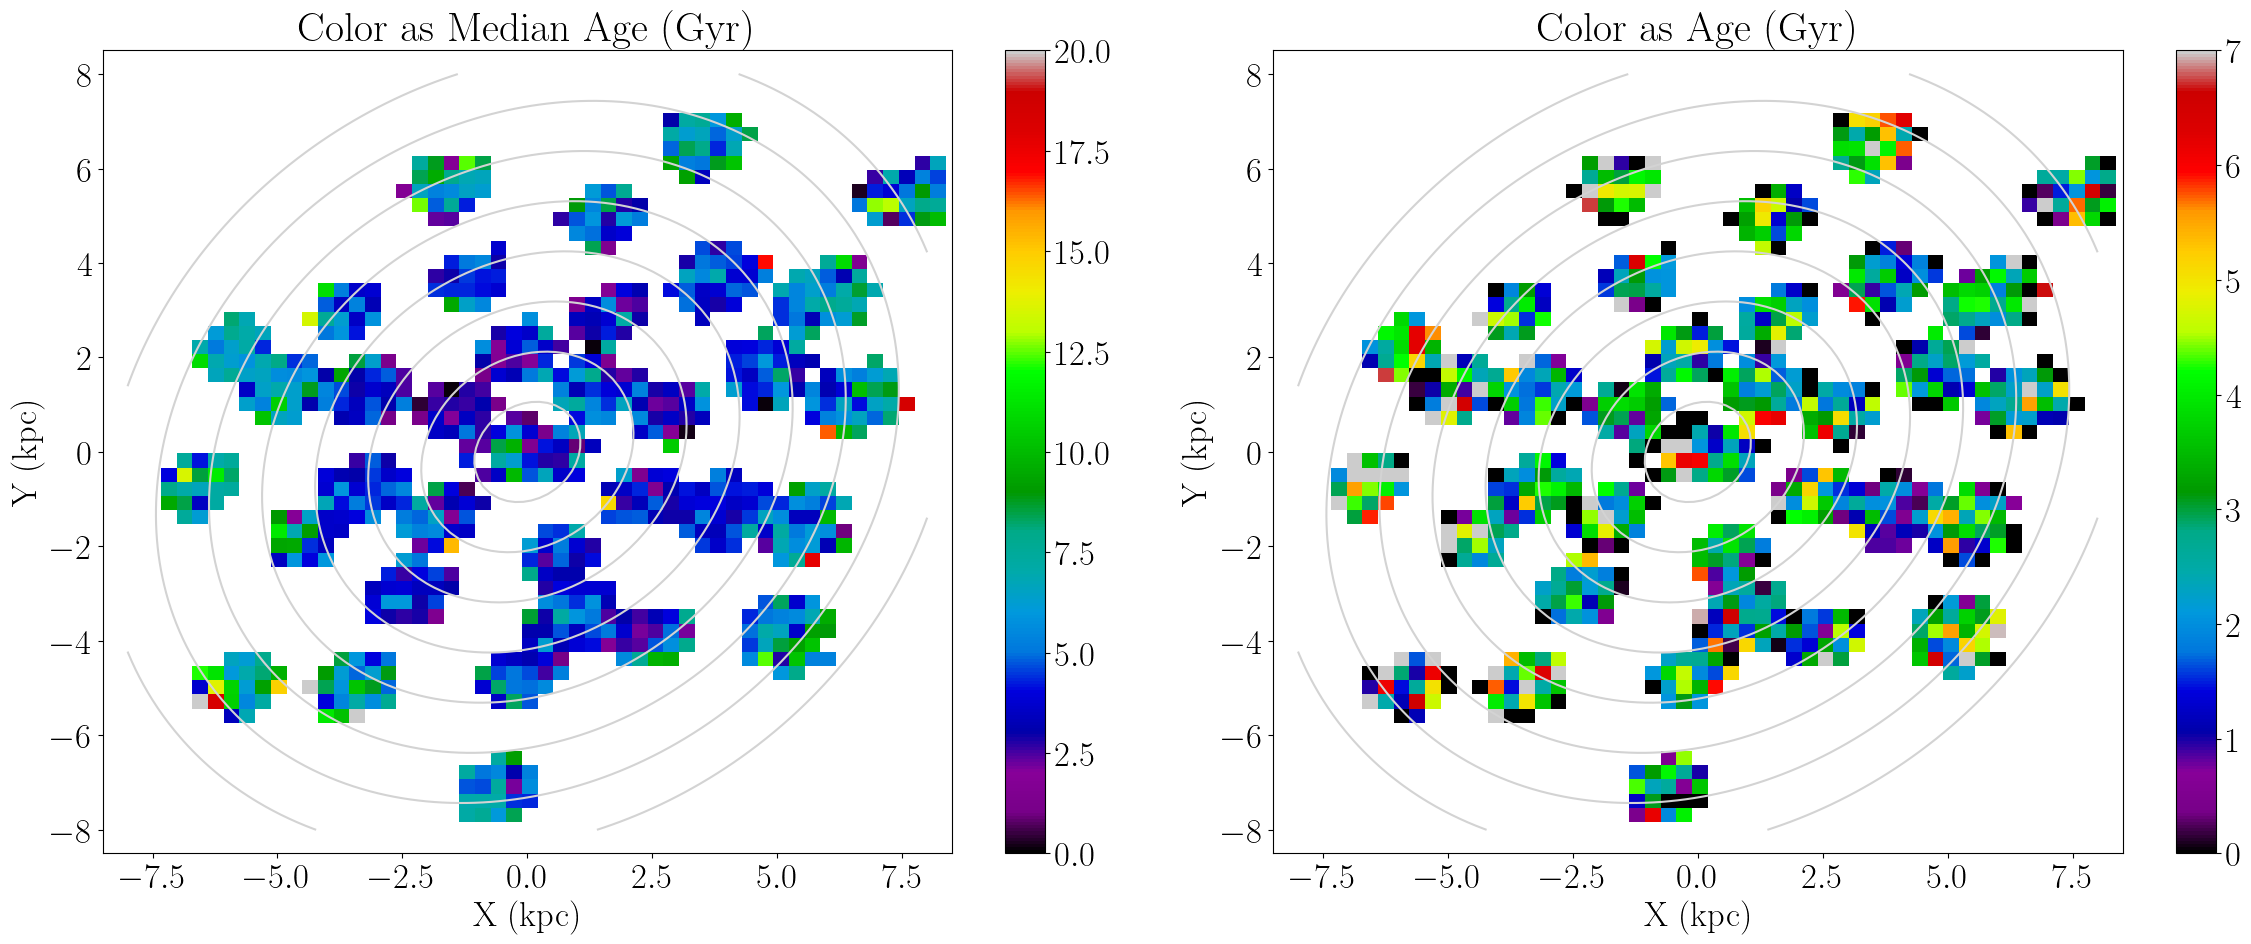

In [646]:
plt.figure(figsize=[24,10])

xx,yy = np.meshgrid(np.linspace(-8,8,100),np.linspace(-8,8,100))

plt.subplot(121)
CS = plt.contour(xx,yy,elliptical_radius(xx,yy),levels=[1,2,3,4,5,6,7,8],colors='lightgrey')
ret = binned_statistic_2d(lmcx,lmcy,agetab['AGE'],'median',bins=50)
im = plt.imshow(ret.statistic.T, origin='lower',
                    extent=[ret.x_edge[0],ret.x_edge[-1],ret.y_edge[0],ret.y_edge[-1]],
                    aspect='auto',interpolation='nearest',cmap='nipy_spectral',vmin=0,vmax=20.)
plt.colorbar()

plt.xlim(-8.5,8.5)
plt.ylim(-8.5,8.5)

plt.title(r'Color as Median Age (Gyr)')
plt.xlabel(r'X (kpc)')
plt.ylabel(r'Y (kpc)')

plt.subplot(122)
CS = plt.contour(xx,yy,elliptical_radius(xx,yy),levels=[1,2,3,4,5,6,7,8],colors='lightgrey')
ret = binned_statistic_2d(lmcx,lmcy,agetab['AGE'],mad,bins=50)
im = plt.imshow(ret.statistic.T, origin='lower',
                    extent=[ret.x_edge[0],ret.x_edge[-1],ret.y_edge[0],ret.y_edge[-1]],
                    aspect='auto',interpolation='nearest',cmap='nipy_spectral',vmin=0,vmax=7)
plt.colorbar()

# H, xedges, yedges = np.histogram2d(lmcx,lmcy,agetab['AGE'],bins=(xedges, yedges))

plt.xlim(-8.5,8.5)
plt.ylim(-8.5,8.5)

plt.title(r'Color as Age (Gyr)')
plt.xlabel(r'X (kpc)')
plt.ylabel(r'Y (kpc)')

plt.tight_layout()
# plt.savefig('lmc_raw_age_map.png',dpi=300,bbox_inches='tight')
plt.show()

In [ ]:
plt.figure(figsize=[12,7])
plt.hist(agetab['AGE'],weights=select_results['stellarmass'],range=(0,20),bins=100,histtype='step')
plt.yscale('log')

In [ ]:
plt.scatter(agetab['AGE'],select_results['stellarmass'])
plt.xlim(0,20)
plt.yscale('log')

In [ ]:
plt.figure(figsize=[12,10])
cut, = np.where((agetab['AGE']<=20)&(agetab['AGE_ERR']<=2)&
                (np.isfinite(agetab['AGE'])==True)&(np.isfinite(agetab['AGE_ERR'])==True))
ret = binned_statistic_2d(agetab['AGE'][cut],agetab['AGE_ERR'][cut],lmcdr17['FE_H'][cut],'median',bins=50)
im = plt.imshow(ret.statistic.T, origin='lower',
                    extent=[ret.x_edge[0],ret.x_edge[-1],ret.y_edge[0],ret.y_edge[-1]],
                    aspect='auto',interpolation='nearest',cmap='nipy_spectral')
# plt.scatter(agetab['AGE'],agetab['AGE_ERR'],c=lmcdr17['FE_H'],cmap='nipy_spectral')
plt.colorbar()
plt.xlim(0,20)
plt.ylim(0,2)
plt.title(r'Color as [Fe/H]')
plt.xlabel(r'Age (Gyr)')
plt.ylabel(r'Age Error (Gyr)')
plt.show()

In [ ]:
plt.figure(figsize=[12,10])
cut, = np.where((agetab['AGE']<=20)&(agetab['AGE_ERR']<=2)&
                (np.isfinite(agetab['AGE'])==True)&(np.isfinite(agetab['AGE_ERR'])==True))
ret = binned_statistic_2d(agetab['AGE'][cut],agetab['AGE_ERR'][cut],agetab['AGE'][cut],'count',bins=50)
ret.statistic[ret.statistic==0] = np.nan
im = plt.imshow(ret.statistic.T, origin='lower',
                    extent=[ret.x_edge[0],ret.x_edge[-1],ret.y_edge[0],ret.y_edge[-1]],
                    aspect='auto',interpolation='nearest',cmap='jet_r')
# plt.scatter(agetab['AGE'],agetab['AGE_ERR'],c=lmcdr17['FE_H'],cmap='nipy_spectral')

p_age_err = np.poly1d(robust.polyfit(agetab['AGE'][cut],agetab['AGE_ERR'][cut],1))
plt.plot(np.linspace(0,20),p_age_err(np.linspace(0,20)),c='k',lw=3.0)

plt.colorbar()
plt.xlim(0,20)
plt.ylim(0,2)
plt.title(r'Color as Number')
plt.xlabel(r'Age (Gyr)')
plt.ylabel(r'Age Error (Gyr)')
plt.show()

In [ ]:
bad_err = np.where((agetab['AGE'][cut]>2.5)&(agetab['AGE_ERR'][cut]<0.1))
good_err = np.where((agetab['AGE'][cut]>2.5)&(agetab['AGE_ERR'][cut]<0.1))

plt.hist(agetab['AGE_ERR'][cut],bins=25,density=True)
plt.hist(agetab['AGE_ERR'][cut][bad_err],bins=10,density=True)

In [ ]:
new_err = np.copy(agetab['AGE_ERR'])

for i in range(len(agetab)):
    if (agetab['AGE'][i]>2.5)&(agetab['AGE_ERR'][i]<0.05):
        new_err[i] = p_age_err(agetab['AGE'][i])


plt.figure(figsize=[24,10])
cut, = np.where((agetab['AGE']<=20)&(agetab['AGE_ERR']<=2)&
                (np.isfinite(agetab['AGE'])==True)&(np.isfinite(agetab['AGE_ERR'])==True))
plt.subplot(121)
ret = binned_statistic_2d(agetab['AGE'][cut],agetab['AGE_ERR'][cut],agetab['AGE'][cut],'count',bins=50)
ret.statistic[ret.statistic==0] = np.nan
im = plt.imshow(ret.statistic.T, origin='lower',
                    extent=[ret.x_edge[0],ret.x_edge[-1],ret.y_edge[0],ret.y_edge[-1]],
                    aspect='auto',interpolation='nearest',cmap='jet_r')
# plt.scatter(agetab['AGE'],agetab['AGE_ERR'],c=lmcdr17['FE_H'],cmap='nipy_spectral')

p_age_err = np.poly1d(robust.polyfit(agetab['AGE'][cut],agetab['AGE_ERR'][cut],1))
# plt.plot(np.linspace(0,20),p_age_err(np.linspace(0,20)),c='k',lw=3.0)

plt.colorbar()
plt.xlim(0,20)
plt.ylim(0,2)
plt.title(r'Color as Number')
plt.xlabel(r'Age (Gyr)')
plt.ylabel(r'Age Error (Gyr)')

plt.subplot(122)
cut2, = np.where((agetab['AGE']<=20)&(new_err<=2)&
                (np.isfinite(agetab['AGE'])==True)&(np.isfinite(new_err)==True))

ret = binned_statistic_2d(agetab['AGE'][cut2],new_err[cut2],agetab['AGE'][cut2],'count',bins=50)
ret.statistic[ret.statistic==0] = np.nan
im = plt.imshow(ret.statistic.T, origin='lower',
                    extent=[ret.x_edge[0],ret.x_edge[-1],ret.y_edge[0],ret.y_edge[-1]],
                    aspect='auto',interpolation='nearest',cmap='jet_r')
# plt.scatter(agetab['AGE'],agetab['AGE_ERR'],c=lmcdr17['FE_H'],cmap='nipy_spectral')

# p_age_err = np.poly1d(robust.polyfit(agetab['AGE'][cut],agetab['AGE_ERR'][cut],1))
# plt.plot(np.linspace(0,20),p_age_err(np.linspace(0,20)),c='k',lw=3.0)

plt.colorbar()
plt.xlim(0,20)
plt.ylim(0,2)
plt.title(r'Color as Number')
plt.xlabel(r'Age (Gyr)')
plt.ylabel(r'Age Error (Gyr)')
plt.show()

In [ ]:
plt.hist(new_err,bins=25,range=(0,2))

In [ ]:
plt.figure(figsize=[12,10])

xx,yy = np.meshgrid(np.linspace(-8,8,100),np.linspace(-8,8,100))
CS = plt.contour(xx,yy,elliptical_radius(xx,yy),levels=[1,2,3,4,5,6,7,8],colors='lightgrey')

ret = binned_statistic_2d(lmcx,lmcy,new_err,'median',bins=50)
im = plt.imshow(ret.statistic.T, origin='lower',
                    extent=[ret.x_edge[0],ret.x_edge[-1],ret.y_edge[0],ret.y_edge[-1]],
                    aspect='auto',interpolation='nearest',cmap='nipy_spectral',vmin=0,vmax=1.5)
plt.colorbar()

plt.xlim(-8.5,8.5)
plt.ylim(-8.5,8.5)

plt.title(r'Color as Age Error (Gyr)')
plt.xlabel(r'X (kpc)')
plt.ylabel(r'Y (kpc)')
# plt.savefig('lmc_map_distance.png',dpi=300,bbox_inches='tight')
plt.show()

In [ ]:
ret = binned_statistic_2d(gaiax,gaiay,gaiax,'count',bins=1000)
ret.statistic[ret.statistic==0] = np.nan

plt.figure(figsize=[12,10])
im  = plt.imshow(ret.statistic.T, origin='lower',
             extent=[ret.x_edge[0],ret.x_edge[-1],ret.y_edge[0],ret.y_edge[-1]],
             aspect='auto',interpolation='nearest',cmap='Greys_r',alpha=0.5,norm=LogNorm(vmin=10**1,vmax=10**6))
plt.colorbar()
plt.xlim(-8.5,8.5)
plt.ylim(-8.5,8.5)

In [ ]:
np.nanmax(lmcdr17['LMCRAD'])

In [ ]:
fig, ax = plt.subplots(1,2,figsize=[24,10])

xx,yy = np.meshgrid(np.linspace(-8,8,100),np.linspace(-8,8,100))
CS = ax[0].contour(xx,yy,superellipse_radius(xx,yy),levels=[1,2,3,4,5,6,7,8],colors='k')
#ax[0].clabel(CS,colors='k',fontsize=25,manual=locations)

# fmt = {}
# strs = ['1', '2', '3', '4', '5', '6', '7']
# for l, s in zip(CS.levels, strs):
#     fmt[l] = s
# ax[0].clabel(CS, CS.levels[::2], inline=True, fmt=fmt, fontsize=10, manual=locations)

CS = ax[1].contour(xx,yy,superellipse_radius(xx,yy),levels=[1,2,3,4,5,6,7,8],colors='k')
#ax[1].clabel(CS,colors='k',fontsize=25,manual=locations)

# for i in range(len(clabx)):
#     ax[0].text(clabx[i]*(1+0.01),0.0,'{}'.format(i+1))

plt.xlim(-8.5,8.5)
plt.ylim(-8.5,8.5)

# set bounds for the plot
for i in range(1):
    ax[i].set_xlim(-9,9)
    ax[i].set_ylim(-9,9)
    ax[i].set_xlabel(r'X (kpc)')
    ax[i].set_ylabel(r'Y (kpc)')

    ax[i].set_xticks([-8,-4.0,0,4.0,8])
    ax[i].set_yticks([-8,-4.0,0,4.0,8])

# convert 0.8 deg diameter to points and calculate the marker size
r = 49.9*np.tan(np.radians(0.8/2)) #0.8
r_ = ax[0].transData.transform([r,0])[0] - ax[0].transData.transform([0,0])[0]
marker_size = np.pi * r_**2

pl = ax[0].scatter(cen_xy[:,0],cen_xy[:,1],s=marker_size,c=med_fld_age,edgecolors='k',cmap='copper_r',vmax=13.787)
plt.colorbar(pl,ax=ax[0])
pl = ax[1].scatter(cen_xy[:,0],cen_xy[:,1],s=marker_size,c=fld_wgt_avg,edgecolors='k',cmap='copper_r',vmax=13.787)
plt.colorbar(pl,ax=ax[1])

ax[0].set_title(r'Raw Median Field Age')
ax[1].set_title(r'Corrected Median Field Age')

ax[1].set_xlabel(r'X (kpc)')
ax[1].set_ylabel(r'Y (kpc)')

plt.tight_layout()
plt.show()

In [ ]:
chi_sq = []

sidx = np.argsort(fld_radius)
for i in range(5)[1:]:
    
    p = np.poly1d(robust.polyfit(fld_radius[sidx],fld_wgt_avg[sidx],i))
    
    chi_sq.append(sum(np.square(np.divide(fld_wgt_avg[sidx]-p(fld_radius[sidx]),fld_wgt_avg[sidx])))) #/(len(fld_radius[:-1]-(i+1))))
    
chi_sq = np.array(chi_sq)
    
plt.scatter(range(5)[1:],chi_sq)
plt.xlabel(r'Polynomial Order')
plt.ylabel(r'Chi Sq')
# plt.savefig(r'chisq_age_radius_polyfit.png',bbox_inches='tight')
plt.show()

In [ ]:
plt.figure(figsize=[12,7])
age_xs = np.linspace(0,max(fld_radius[fld_radius<8]))

plt.plot(age_xs,p_raw(age_xs),c='r')
plt.scatter(fld_radius,med_fld_age,c='r',label='Raw Field Age')

p_corr = np.poly1d(robust.polyfit(fld_radius[fld_radius<8],fld_wgt_avg[fld_radius<8],4))
plt.plot(age_xs,p_corr(age_xs),c='k')
plt.scatter(fld_radius,fld_wgt_avg,c='k',label='Corrected Field Age')

plt.legend(loc='upper left')

plt.ylim(0.,13.787)

plt.xlabel(r'Elliptical Radius (kpc)')
plt.ylabel(r'Median Age (Gyr)')

print('Raw:', p_raw)
print('Corr:', p_corr)

In [ ]:
plt.figure(figsize=[12,7])
plt.scatter(lmcr,agetab['AGE'],c='lightgray',s=10)
plt.scatter(fld_radius[north_fld],fld_wgt_avg[north_fld],marker='^',c=fld_pa[north_fld],s=100,label='North',cmap='twilight_shifted',vmin=0,vmax=360)
plt.scatter(fld_radius[south_fld],fld_wgt_avg[south_fld],marker='v',c=fld_pa[south_fld],s=100,label='South',cmap='twilight_shifted',vmin=0,vmax=360)
plt.colorbar()
plt.legend()
xs_rads = np.linspace(min(fld_radius[np.argsort(fld_radius)][:-1]),max(fld_radius[np.argsort(fld_radius)][:-1]))
plt.plot(xs_rads,p_corr(xs_rads),c='k',lw=3)
plt.ylim(0,13.787)
plt.title(r'Corrected')
plt.xlabel(r'Elliptical Radius (kpc)')
plt.ylabel(r'Median Field Age (Gyr)')
# plt.savefig('lmc_fld_age_radius_w_poly.png',bbox_inches='tight')
plt.show()

In [ ]:
corr_res_fld_age = p_corr(fld_radius)-fld_wgt_avg

plt.figure(figsize=[12,7])
plt.scatter(fld_radius,corr_res_fld_age,c=fld_pa,marker='.',s=100,cmap='twilight_shifted',vmin=0,vmax=360)
plt.colorbar()
plt.axhline(0.0,c='k')

plt.title(r'Corrected')
plt.xlabel(r'Elliptical Radius (kpc)')
plt.ylabel(r'Age-Radius Relation - Data')
plt.show()

plt.figure(figsize=[12,7])
plt.scatter(fld_pa[north_fld],corr_res_fld_age[north_fld],c=fld_radius[north_fld],marker='^',s=100,cmap='twilight_shifted_r',vmin=0,vmax=max(fld_radius),label='North')
plt.scatter(fld_pa[south_fld],corr_res_fld_age[south_fld],c=fld_radius[south_fld],marker='v',s=100,cmap='twilight_shifted_r',vmin=0,vmax=max(fld_radius),label='South')
plt.colorbar()
# plt.legend()
plt.axhline(0.0,c='k')
plt.ylim(-3,3)
plt.title(r'Corrected; Color as Radius')
plt.xlabel(r'Position Angle')
plt.ylabel(r'Age-Radius Relation - Data')
plt.show()

In [ ]:
from matplotlib.colors import LinearSegmentedColormap

class roll_cmap(LinearSegmentedColormap):

    def __init__(self, cmap, shift):
        
        shift = shift/360.

        assert 0. < shift < 1.
        self.cmap = cmap
        self.N = cmap.N
        self.monochrome = self.cmap.monochrome
        self._x = np.linspace(0.0, 1.0, 255)
        self._y = np.roll(np.linspace(0.0, 1.0, 255),int(255.*shift))

    def __call__(self, xi, alpha=1.0, **kw):
        yi = np.interp(xi, self._x, self._y)
        return self.cmap(yi, alpha)
    
cmap = plt.cm.twilight_shifted_r
cmap_rolled = roll_cmap(cmap, shift=280)
    
corr_res_fld_age = p_corr(fld_radius)-fld_wgt_avg

plt.figure(figsize=[12,7])
plt.scatter(fld_radius,corr_res_fld_age,c=fld_pa,marker='.',s=100,cmap=cmap_rolled,vmin=0,vmax=360)
plt.colorbar()
plt.axhline(0.0,c='k')

plt.title(r'Corrected')
plt.xlabel(r'Elliptical Radius (kpc)')
plt.ylabel(r'Age-Radius Relation - Data')
plt.show()

In [ ]:
plt.figure(figsize=[24,14])
plt.plot(lmcr[np.argsort(lmcr)][::-1],np.cumsum(lmcdr17['GAIAEDR3_PHOT_G_MEAN_MAG'][np.argsort(lmcr)][::-1]),c='tab:blue',label='G Elliptical')
plt.plot(lmcr[np.argsort(lmcr)][::-1],np.cumsum(lmcdr17['GAIAEDR3_PHOT_BP_MEAN_MAG'][np.argsort(lmcr)][::-1]),c='tab:orange',label='BP Elliptical')
plt.plot(lmcr[np.argsort(lmcr)][::-1],np.cumsum(lmcdr17['GAIAEDR3_PHOT_RP_MEAN_MAG'][np.argsort(lmcr)][::-1]),c='tab:green',label='RP Elliptical')

plt.plot(lmcsr[np.argsort(lmcsr)][::-1],np.cumsum(lmcdr17['GAIAEDR3_PHOT_G_MEAN_MAG'][np.argsort(lmcsr)][::-1]),c='tab:blue',ls='--',label='G Superellipse')
plt.plot(lmcsr[np.argsort(lmcsr)][::-1],np.cumsum(lmcdr17['GAIAEDR3_PHOT_BP_MEAN_MAG'][np.argsort(lmcsr)][::-1]),c='tab:orange',ls='--',label='BP Superellipse')
plt.plot(lmcsr[np.argsort(lmcsr)][::-1],np.cumsum(lmcdr17['GAIAEDR3_PHOT_RP_MEAN_MAG'][np.argsort(lmcsr)][::-1]),c='tab:green',ls='--',label='RP Superellipse')

plt.plot(np.sqrt(lmcx**2+lmcy**2)[np.argsort(np.sqrt(lmcx**2+lmcy**2))][::-1],
         np.cumsum(lmcdr17['GAIAEDR3_PHOT_G_MEAN_MAG'][np.argsort(np.sqrt(lmcx**2+lmcy**2))][::-1]),c='tab:blue',ls=':',label='G Circular')
plt.plot(np.sqrt(lmcx**2+lmcy**2)[np.argsort(np.sqrt(lmcx**2+lmcy**2))][::-1],
         np.cumsum(lmcdr17['GAIAEDR3_PHOT_BP_MEAN_MAG'][np.argsort(np.sqrt(lmcx**2+lmcy**2))][::-1]),c='tab:orange',ls=':',label='BP Circular')
plt.plot(np.sqrt(lmcx**2+lmcy**2)[np.argsort(np.sqrt(lmcx**2+lmcy**2))][::-1],
         np.cumsum(lmcdr17['GAIAEDR3_PHOT_RP_MEAN_MAG'][np.argsort(np.sqrt(lmcx**2+lmcy**2))][::-1]),c='tab:green',ls=':',label='RP Circular')

plt.legend()

# plt.axhline(0.5*np.nanmax(np.cumsum(lmcdr17['GAIAEDR3_PHOT_G_MEAN_MAG'][np.argsort(lmcr)])))
# plt.axvline(4.25)
plt.xlabel(r'Radius (kpc)')
plt.ylabel(r'Cummulative Brightness')
plt.show()

In [ ]:
north

In [ ]:
# radii = np.array([fld_raidus[north],])

quad_north_ys = np.array([med_fld_age[north_fld],fld_wgt_avg[north_fld],raw_res_fld_age[north_fld],
                          corr_res_fld_age[north_fld]])
quad_north_xs = np.array([fld_radius[north_fld],fld_radius[north_fld],
                          fld_radius[north_fld],fld_radius[north_fld]])
quad_north_pa = np.array([fld_pa[north_fld],fld_pa[north_fld],fld_pa[north_fld],fld_pa[north_fld]])

quad_south_ys = np.array([med_fld_age[south_fld],fld_wgt_avg[south_fld],raw_res_fld_age[south_fld],
                          corr_res_fld_age[south_fld]])
quad_south_xs = np.array([fld_radius[south_fld],fld_radius[south_fld],
                          fld_radius[south_fld],fld_radius[south_fld]])
quad_south_pa = np.array([fld_pa[south_fld],fld_pa[south_fld],fld_pa[south_fld],fld_pa[south_fld]])

labels = np.array(['A','B','C','D'])

fig,ax = plt.subplots(2,2,figsize=[25,20])
axs = ax.ravel() 

for i in range(len(ax.ravel().tolist())):
    axs[i].grid()
    
    # top plots
    if i < 2:
        axs[i].scatter(lmcr,agetab['AGE'],c='lightgray',s=10)
        axs[i].set_ylim(0,14)#13.787)
        axs[i].set_ylabel(r'Age (Gyr)')
        axs[i].text(0.25,13,r'({})'.format(labels[i]))
        
    if i > 1:
        axs[i].set_ylim(-3,3)
        axs[i].axhline(0,c='k',lw=3.0)
        axs[i].set_ylabel(r'Age-Radius Relation - Age (Gyr)')
        axs[i].text(0.25,2.6,r'({})'.format(labels[i]))
        
    # left column
    if i in [0,2]:
        axs[i].set_title(r'Raw')
    
    # right column
    if i in [1,3]:
        axs[i].set_title(r'Corrected')
        
    axs[i].scatter(quad_north_xs[i],quad_north_ys[i],marker='^',
                          c=quad_north_pa[i],cmap=cmap_rolled,s=500,label='North',vmin=0,vmax=360)
    im = axs[i].scatter(quad_south_xs[i],quad_south_ys[i],marker='v',
                          c=quad_south_pa[i],cmap=cmap_rolled,s=500,label='South',vmin=0,vmax=360)
    
    axs[i].legend(loc='upper right')
    axs[i].set_xlabel(r'Elliptical Radius (kpc)')
    
    axs[i].set_xlim(-0.5,9)
    
axs[0].plot(xs_rads,p_raw(xs_rads),c='k',lw=3)
axs[1].plot(xs_rads,p_corr(xs_rads),c='k',lw=3)

# axs[2].scatter(lmcr,p_raw(lmcr)-agetab['AGE'],zorder=0,c='lightgrey',s=10)
# axs[3].scatter(lmcr,p_corr(lmcr)-agetab['AGE'],zorder=0,c='lightgrey',s=10)
    
plt.colorbar(im,ax=axs,label='Position Angle (deg)')
plt.savefig('lmc_age_radius.png',bbox_inches='tight')
plt.show()

In [ ]:
print(p_raw)

In [ ]:
fld_radius[fld_radius<8],med_fld_age[fld_radius<8]
np.std(p_raw(fld_radius)-med_fld_age)

In [ ]:
print(p_corr)

In [ ]:
fld_radius[fld_radius<8],med_fld_age[fld_radius<8]
np.std(p_corr(fld_radius)-corr_res_fld_age)

In [ ]:
# plt.figure(figsize=[12,7])
# plt.scatter(agetab['AGE'],lmcdr17['FE_H'],c='lightgrey',s=10)
# plt.xlim(0,20)
# plt.xlabel(r'Age (Gyr)')
# plt.ylabel(r'[Fe/H]')

In [ ]:
feh_upper_carrera = np.array([0.5,-0.25,-0.75,-1.5]) 
feh_lower_carrera = np.array([-0.25,-0.75,-1.5,-3.5])

age_upper_carrera = np.array([2,6,10,13.787]) 
age_lower_carrera = np.array([0,2,6,10])

feh_carrera = np.ones(4)
feh_wid_carrera = np.ones(4)
age_carrera = np.ones(4)
age_wid_carrera = np.ones(4)

for i in range(4):
    feh_carrera[i] = np.mean([feh_upper_carrera[i],feh_lower_carrera[i]])
    feh_wid_carrera[i] = np.diff([feh_upper_carrera[i],feh_lower_carrera[i]])/2
    
    age_carrera[i] = np.mean([age_upper_carrera[i],age_lower_carrera[i]])
    age_wid_carrera[i] = np.diff([age_upper_carrera[i],age_lower_carrera[i]])/2

In [ ]:
plt.figure(figsize=[12,7])
plt.scatter(agetab['AGE'],lmcdr17['FE_H'],c='lightgray',s=10)
plt.scatter(med_fld_age,fld_feh,c='tab:red',marker='.',s=500)
plt.xlim(0,20)
# xs_rads = np.linspace(min(fld_radius[np.argsort(fld_radius)][:-1]),max(fld_radius[np.argsort(fld_radius)][:-1]))
# plt.plot(xs_rads,p2(xs_rads),c='k',lw=3)
# plt.ylim(0,13)
plt.xlabel(r'Age')
plt.ylabel(r'[Fe/H]')
# plt.savefig('lmc_fld_age_radius_w_poly.png',bbox_inches='tight')
plt.show()


#### 
#### plot star make size mass 
#### maybe sq stellar mass
#### logage instead of linear age?
#### binned values in age or feh?
#### look at carrera paper

In [ ]:
plt.figure(figsize=[12,7])
plt.scatter(agetab['AGE'],lmcdr17['FE_H'],c='lightgrey',s=10)
plt.scatter(age_carrera,feh_carrera,s=25,c='k')
plt.scatter(med_fld_age[north_fld],fld_feh[north_fld],c=fld_pa[north_fld],marker='^',s=100,
            cmap=cmap_rolled,vmin=0,vmax=360)
plt.scatter(med_fld_age[south_fld],fld_feh[south_fld],c=fld_pa[south_fld],marker='v',s=100,
            cmap=cmap_rolled,vmin=0,vmax=360)
plt.errorbar(age_carrera,feh_carrera,xerr=age_wid_carrera,yerr=feh_wid_carrera,ls=' ',c='k')
plt.colorbar()
plt.xlim(0,20)
plt.xlabel(r'Age (Gyr)')
plt.ylabel(r'[Fe/H]')

In [ ]:
# amr_spl = bspline(agetab['AGE'],lmcdr17['FE_H'])

amr_cut, = np.where((agetab['AGE']<=20.)&(np.isfinite(agetab['AGE'])==True)&(np.isfinite(lmcdr17['FE_H'])==True))

bin_stat,bin_edge,bin_num = binned_statistic(agetab['AGE'][amr_cut],lmcdr17['FE_H'][amr_cut],'median',bins=20)

amr_spl = bspline(bin_edge[:-1]+0.5*np.diff(bin_edge),bin_stat,extrapolate=True)

plt.figure(figsize=[12,7])
plt.scatter(agetab['AGE'],lmcdr17['FE_H'],c='lightgrey',s=10)
# plt.scatter(age_carrera,feh_carrera,s=25,c='k')
plt.plot(np.linspace(0,20),amr_spl(np.linspace(0,20)),c='r',lw=3.)
plt.errorbar(age_carrera,feh_carrera,xerr=age_wid_carrera,yerr=feh_wid_carrera,ls=' ',c='k',
             label='Carrera et al. 2011')
plt.legend(frameon=False)
plt.xlim(0,20)
plt.xlabel(r'Age (Gyr)')
plt.ylabel(r'[Fe/H]')

# plt.axvline(1)

In [ ]:
amr_cut, = np.where((agetab['AGE']<=20.)&(np.isfinite(agetab['AGE'])==True)&(np.isfinite(lmcdr17['FE_H'])==True))

bin_stat,bin_edge,bin_num = binned_statistic(agetab['AGE'][amr_cut],lmcdr17['FE_H'][amr_cut],'median',bins=20)

bin_disp = np.ones(len(bin_stat))
for i in range(len(bin_disp)):
    wht_bin, = np.where(bin_num==np.unique(bin_num)[i])
    bin_disp[i] = mad(lmcdr17['FE_H'][amr_cut][wht_bin]) 

amr_spl = bspline(bin_edge[:-1]+0.5*np.diff(bin_edge),bin_stat,extrapolate=True)

# amr_spl(np.linspace(0,20))

In [ ]:
plt.figure(figsize=[12,7])
plt.scatter(agetab['AGE'],lmcdr17['FE_H'],c='lightgrey',s=10)
# plt.plot(np.linspace(0,20),amr_spl(np.linspace(0,20)),c='r',lw=3.)
plt.errorbar(bin_edge[:-1]+0.5*np.diff(bin_edge),bin_stat,xerr=0.5*np.ones(len(bin_stat)),yerr=bin_disp,ls=' ',c='r')
# plt.legend(frameon=False)
# plt.errorbar(age_carrera,feh_carrera,xerr=age_wid_carrera,yerr=feh_wid_carrera,ls=' ',c='k',
#              label='Carrera et al. 2011')
# plt.ylim(-3,0.5)
plt.xlim(0,20)
plt.xlabel(r'Age (Gyr)')
plt.ylabel(r'[Fe/H]')
plt.savefig('lmc_amr.png',bbox_inches='tight')
plt.show()

In [ ]:
len()

In [ ]:
plt.figure(figsize=[12,7])
plt.scatter(agetab['AGE'],lmcdr17['FE_H'],c='lightgrey',s=10)
# plt.scatter(age_carrera,feh_carrera,s=25,c='k')
plt.scatter(fld_wgt_avg[north_fld],fld_feh[north_fld],c=fld_pa[north_fld],marker='^',s=100,
            cmap=cmap_rolled,vmin=0,vmax=360)
plt.scatter(fld_wgt_avg[south_fld],fld_feh[south_fld],c=fld_pa[south_fld],marker='v',s=100,
            cmap=cmap_rolled,vmin=0,vmax=360)
# plt.errorbar(age_carrera,feh_carrera,xerr=age_wid_carrera,yerr=feh_wid_carrera,ls=' ',c='k')
plt.colorbar()
plt.xlim(0,20)
plt.title('Corrected')
plt.xlabel(r'Age (Gyr)')
plt.ylabel(r'[Fe/H]')
plt.savefig('lmc_amr_corr.png',bbox_inches='tight')
plt.show()

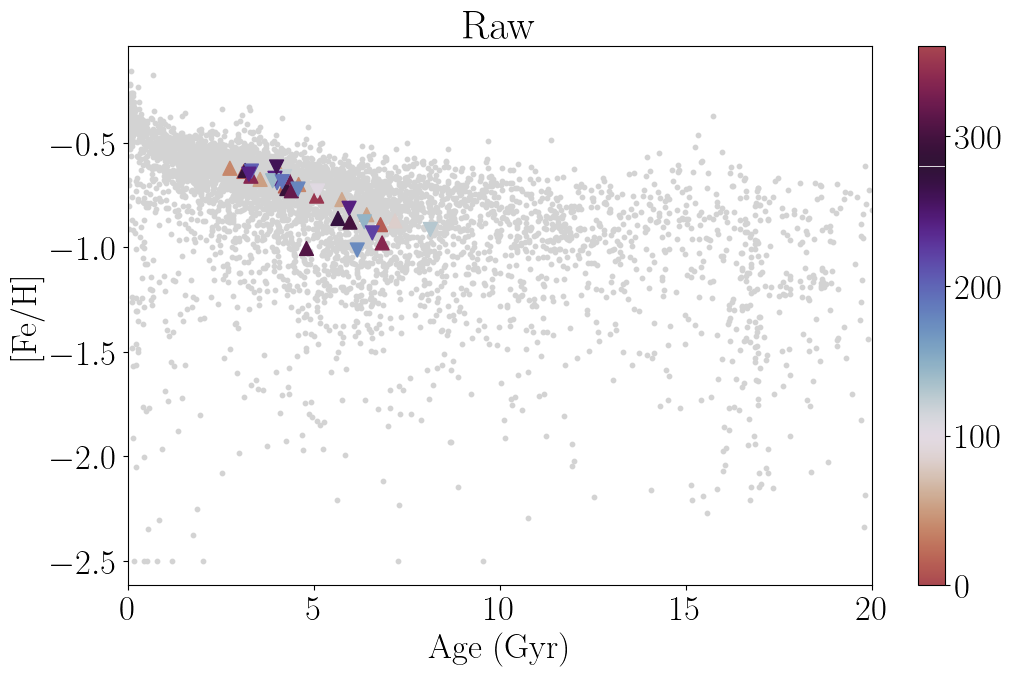

In [690]:
plt.figure(figsize=[12,7])
plt.scatter(agetab['AGE'],lmcdr17['FE_H'],c='lightgrey',s=10)
# plt.scatter(age_carrera,feh_carrera,s=25,c='k')
plt.scatter(med_fld_age[north_fld],fld_feh[north_fld],c=fld_pa[north_fld],marker='^',s=100,
            cmap=cmap_rolled,vmin=0,vmax=360)
plt.scatter(med_fld_age[south_fld],fld_feh[south_fld],c=fld_pa[south_fld],marker='v',s=100,
            cmap=cmap_rolled,vmin=0,vmax=360)
# plt.errorbar(age_carrera,feh_carrera,xerr=age_wid_carrera,yerr=feh_wid_carrera,ls=' ',c='k')
plt.colorbar()
plt.xlim(0,20)
plt.title('Raw')
plt.xlabel(r'Age (Gyr)')
plt.ylabel(r'[Fe/H]')
plt.savefig('lmc_amr_raw.png',bbox_inches='tight')
plt.show()

# sorted_binned AMR

In [753]:
import pandas as pd

'''@article{harris2009star,
  title={The star formation history of the large magellanic cloud},
  author={Harris, Jason and Zaritsky, Dennis},
  journal={The Astronomical Journal},
  volume={138},
  number={5},
  pages={1243},
  year={2009},
  publisher={IOP Publishing}
}'''

df = pd.read_csv('harris_zaritsky_09_lmc_clusters_table3.csv',skipfooter=6)
df

/var/folders/rc/1rzbdsbd3pb_0pd6mhcfkh2r0000gn/T/ipykernel_2701/3933023042.py:14: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  df = pd.read_csv('harris_zaritsky_09_lmc_clusters_table3.csv',skipfooter=6)


Cluster  [Fe/H]  sigma_[Fe/H]  log(Age)  sigma_log(Age)  \
0   Reticulum   -1.66          0.12     10.13            0.05   
1       BRHTb   -0.40          0.00      8.00            0.00   
2      ESO121   -0.97          0.10      9.96            0.04   
3        R136   -0.40          0.00      7.00            0.00   
4      OHSC33   -1.05          0.20      9.18            0.03   
..        ...     ...           ...       ...             ...   
84   NGC 2257   -1.63          0.21     10.20            0.10   
85  NGC 2213    -0.70          0.10      9.23            0.04   
86   NGC 2214   -0.20          0.20      8.00            0.00   
87   NGC 2249   -0.45          0.10      9.35            0.03   
88   NGC 2257   -1.63          0.21     10.20            0.10   

                  Reference           Notes  
0   Mackey & Gilmore (2004)               a  
1      Piatti et al. (2003)              bc  
2      Mackey et al. (2006)   sdotsdotsdot   
3      Hunter et al. (1995)              bc  
4        Bica et al. (1998)   sdotsdotsdot   
..                      ...             ...  
84     Dirsch et al. (2000)   sdotsdotsdot   
85     Kerber et al. (2007)               e  
86  Sagar & Richtler (1991)               c  
87     Kerber et al. (2007)    sdotsdotsdot  
88     Dirsch et al. (2000)   sdotsdotsdot   

[89 rows x 7 columns]

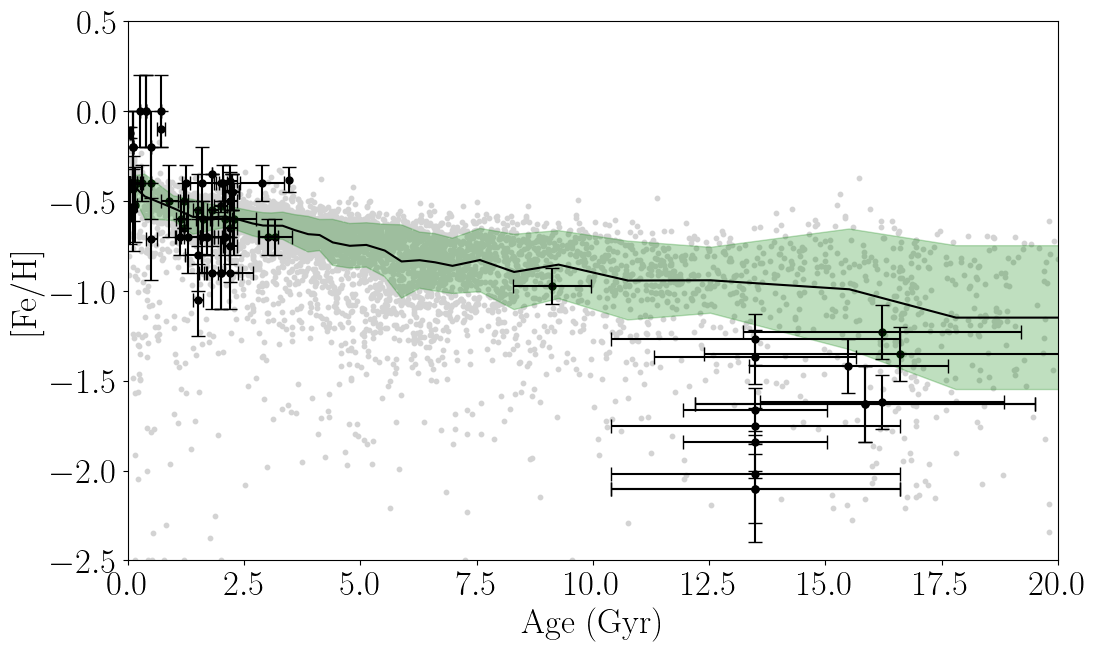

In [781]:
sidx = np.argsort(agetab['AGE'])

nbins = 200
chunks = np.array_split(sidx, len(sidx)/nbins)

binned_feh = 999999.0*np.ones(len(chunks))
binned_feh_mad = 999999.0*np.ones(len(chunks))
binned_age = 999999.0*np.ones(len(chunks))
binned_age_mad = 999999.0*np.ones(len(chunks))

for i in range(len(chunks)):

    binned_age[i] = np.nanmedian(agetab['AGE'][chunks[i]])
    binned_age_mad[i] = mad(agetab['AGE'][chunks[i]])
    binned_feh[i] = np.nanmedian(lmcdr17['FE_H'][chunks[i]])
    binned_feh_mad[i] = mad(lmcdr17['FE_H'][chunks[i]])
    
plt.figure(figsize=[12,7])
plt.scatter(agetab['AGE'],lmcdr17['FE_H'],c='lightgrey',s=10)
plt.scatter(10**df['log(Age)']/10**9,df['[Fe/H]'],c='k',s=25)
hz09_err = (10**df['log(Age)'])*np.log(10)*df['sigma_log(Age)']/10**9
plt.errorbar(10**df['log(Age)']/10**9,df['[Fe/H]'],c='k',yerr=df['sigma_[Fe/H]'],xerr=hz09_err,ls=' ',capsize=5)
plt.fill_between(binned_age,binned_feh+binned_feh_mad,binned_feh-binned_feh_mad,alpha=0.25,color='green')
plt.plot(binned_age,binned_feh,c='k')
plt.xlim(0,20)
plt.ylim(-2.5,0.5)
plt.xlabel(r'Age (Gyr)')
plt.ylabel(r'[Fe/H]')
plt.savefig('lmc_amr_numbin.png',bbox_inches='tight')
plt.show()

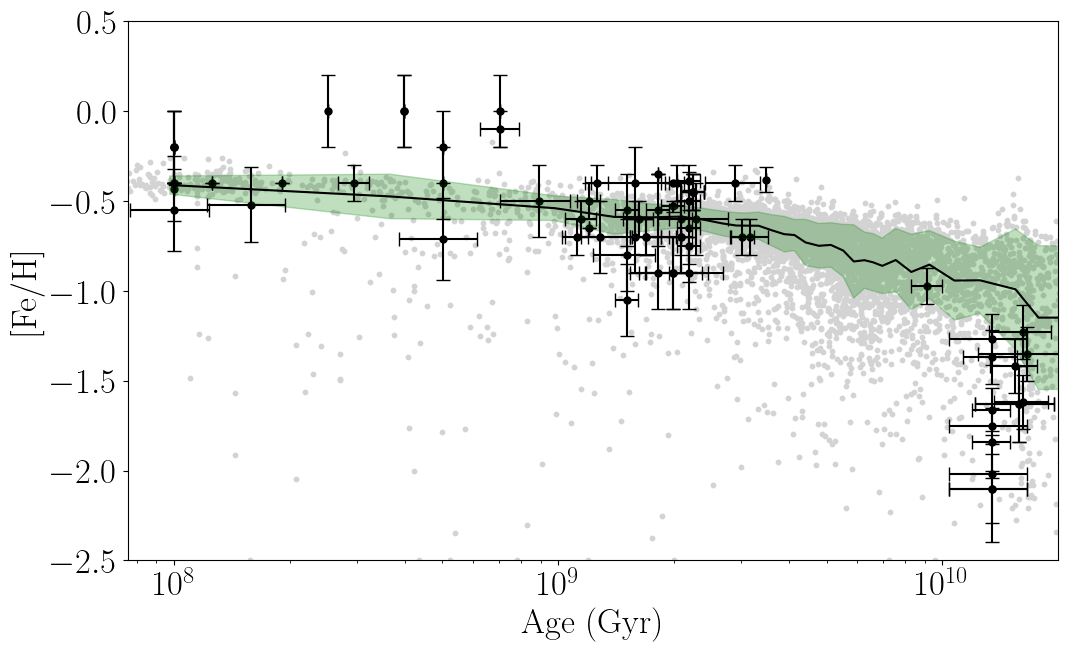

In [780]:
plt.figure(figsize=[12,7])
plt.scatter(agetab['AGE']*10**9,lmcdr17['FE_H'],c='lightgrey',s=10)
plt.scatter(10**df['log(Age)'],df['[Fe/H]'],c='k',s=25)
hz09_err = (10**df['log(Age)'])*np.log(10)*df['sigma_log(Age)']
plt.errorbar(10**df['log(Age)'],df['[Fe/H]'],c='k',yerr=df['sigma_[Fe/H]'],xerr=hz09_err,ls=' ',capsize=5)
plt.fill_between(binned_age*10**9,binned_feh+binned_feh_mad,binned_feh-binned_feh_mad,alpha=0.25,color='green')
plt.plot(binned_age*10**9,binned_feh,c='k')
plt.xlim(10**7.88,10**10.301)
plt.ylim(-2.5,0.5)
plt.xlabel(r'Age (Gyr)')
plt.ylabel(r'[Fe/H]')
plt.xscale('log')
plt.savefig('lmc_amr_numbin_logscale.png',bbox_inches='tight')
plt.show()

In [762]:
np.log10(20*10**9)

10.301029995663981

In [ ]:
len(np.array_split(sidx,62.3))

In [ ]:
massive.columns